# NLP Challenge

This is an analysis done as part of a challenge on an unknown dataset. From an initial look into the dataset, it seems to be a collection of news headlines. I do an exploratory analysis here trying to understand the entire data rather than go for bulding a predictive model. Personally speaking, a predictive model seems a bit unlikely for this dataset in the raw form. Maybe, after a bit of preprocessing of the upvotes into a categorical variable, we could go for a rating prediction of the articles. Also given the authors, there could be a relation to the kind of the articles they publish, so maybe a Naive Bayes classifier for author prediction from articles if we have enough data for some authors. Let's see what we can explore.  

In [1]:
# import key libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import nltk
from nltk.corpus import wordnet,stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from textblob import TextBlob
import gensim
import re
import string

In [2]:
# In case I need GPU (unlikely since I am not training an ML model)
from tensorflow.python.compiler.mlcompute import mlcompute
mlcompute.set_mlc_device(device_name='any')

In [3]:
# seed for REPRODUCIBILITY
SEED = 101  

In [4]:
# load the data
df = pd.read_csv('Eluvio_DS_Challenge.csv')
df.head()

time_created date_created  up_votes  down_votes  \
0    1201232046   2008-01-25         3           0   
1    1201232075   2008-01-25         2           0   
2    1201232523   2008-01-25         3           0   
3    1201233290   2008-01-25         1           0   
4    1201274720   2008-01-25         4           0   

                                             title  over_18    author  \
0                Scores killed in Pakistan clashes    False     polar   
1                 Japan resumes refuelling mission    False     polar   
2                  US presses Egypt on Gaza border    False     polar   
3     Jump-start economy: Give health care to all     False   fadi420   
4  Council of Europe bashes EU&UN terror blacklist    False  mhermans   

    category  
0  worldnews  
1  worldnews  
2  worldnews  
3  worldnews  
4  worldnews

In [5]:
df.dtypes

time_created     int64
date_created    object
up_votes         int64
down_votes       int64
title           object
over_18           bool
author          object
category        object
dtype: object

In [6]:
df.head()

time_created date_created  up_votes  down_votes  \
0    1201232046   2008-01-25         3           0   
1    1201232075   2008-01-25         2           0   
2    1201232523   2008-01-25         3           0   
3    1201233290   2008-01-25         1           0   
4    1201274720   2008-01-25         4           0   

                                             title  over_18    author  \
0                Scores killed in Pakistan clashes    False     polar   
1                 Japan resumes refuelling mission    False     polar   
2                  US presses Egypt on Gaza border    False     polar   
3     Jump-start economy: Give health care to all     False   fadi420   
4  Council of Europe bashes EU&UN terror blacklist    False  mhermans   

    category  
0  worldnews  
1  worldnews  
2  worldnews  
3  worldnews  
4  worldnews

In [7]:
len(df)

509236

<AxesSubplot:xlabel='category', ylabel='count'>

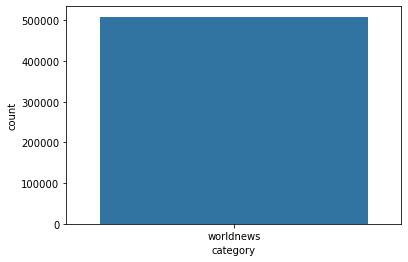

In [8]:
sns.countplot(x = 'category', data=df)

So, just one category, no need of the last column.

In [9]:
df.drop(['category'], axis=1, inplace=True)

<AxesSubplot:>

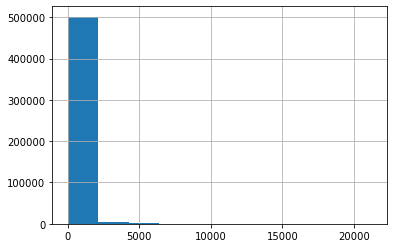

In [10]:
df.up_votes.hist(bins=10)

In [11]:
df.down_votes.value_counts()

0    509236
Name: down_votes, dtype: int64

In [12]:
# no need of the down_votes column, let's drop it
df.drop(['down_votes'], axis=1, inplace=True)

In [13]:
df.author.value_counts()

davidreiss666     8897
anutensil         5730
DoremusJessup     5037
maxwellhill       4023
igeldard          4013
                  ... 
Nykone               1
animatedspray1       1
PartA                1
hxn_ansari           1
troskenhagen         1
Name: author, Length: 85838, dtype: int64

Thats a lot of authors. One idea could be to look at a few of the more popular ones and see what content each of them publish.

In [14]:
df.over_18.value_counts()

False    508916
True        320
Name: over_18, dtype: int64

**over_18** : Very imbalanced column. We will characterize these classes below. Before that, let's first pre-process the data a bit to get a better handle on it.

## Data pre-processing

**Stemming** or **Lemmatization** : Stemming is usually the easier of the two to implement. But it tends to produce some non-sensical words, for example 'economies' become 'economi', 'deputy' becomes 'deputi' and so on. Lemmatization, on the other hand, needs a bit of work to implement but produces the correct root of the words. So, I will implement lemmatization to each of our text. 

This is a huge dataset. Let's analyze a random subset of it, to start with. Once we have a general idea, we can expand the analysis to the entire dataset.

In [15]:
df2 = df.sample(100000, random_state=SEED).reset_index()

In [16]:
# First we need to find the POS (or parts of speech) tag for the words. We define this
# helper function to pass it our lemmatizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [17]:
# In the following function, I implement all the basic pre-processing tasks like stopwords
# removal, lemmatization, punctuation stripping and so on...

def process_text(text):
    """Process individual text.
    Input:
        text: a string representing individual rows of the 'title' column
    Output:
        texts_clean: a list of words containing the processed tweet

    """
    lemmatizer = WordNetLemmatizer()
    
    stopwords_english = stopwords.words('english')
    # remove hyperlinks
    text = re.sub(r'https?:\/\/.*[\r\n]*', '', text)
    # remove punctuation
    text = re.sub(f'[{re.escape(string.punctuation)}]', '', text)
    # finally lemmatizing. gensim.utils.simple_preprocess uses tokenize() internally and does lowercasing as well
    return [lemmatizer.lemmatize(token, get_wordnet_pos(token)) for token in gensim.utils.simple_preprocess(text) if token not in stopwords_english and len(token) >= 2]

In [18]:
df2['title_processed'] = df2['title'].apply(process_text)

In [19]:
df2['title_processed_joined'] = df2['title_processed'].apply(lambda x: ' '.join(x))

In [20]:
df2.head(10)

index  time_created date_created  up_votes  \
0    2572    1207032715   2008-04-01         2   
1  174001    1365986500   2013-04-15         1   
2  279154    1401459395   2014-05-30         0   
3   59328    1277362604   2010-06-24         7   
4  361394    1429196161   2015-04-16         0   
5  234143    1386345508   2013-12-06      3986   
6   30112    1237489920   2009-03-19         0   
7    1355    1205734057   2008-03-17         0   
8   28711    1236150492   2009-03-04         2   
9  397182    1442518307   2015-09-17        17   

                                               title  over_18  \
0  Deputies say neglect caused boy to waste away ...    False   
1  Is your old t-shirt hurting African economies?...    False   
2  Indonesian authorities said they were testing ...    False   
3  New Australian PM announces her cabinet. Retai...    False   
4  China Suspends Rules on Tech Companies Serving...    False   
5  Japan passes a democracy-muzzling Patriot Act....    False   
6  Charlie Miller Wins Pwn2Own Again Thanks to Sa...    False   
7  Basic Greenhouse Equations  Totally Wrong  - W...    False   
8                    Blackwater Founder, CEO Resigns    False   
9  US plans to accept Russia offer to join milita...    False   

               author                                    title_processed  \
0              yorosa  [deputy, say, neglect, cause, boy, waste, away...   
1  bridgesfreezefirst  [old, tshirt, hurt, african, economy, tshirt, ...   
2         XKryptonite  [indonesian, authority, say, test, product, ma...   
3           shigawire  [new, australian, pm, announces, cabinet, reta...   
4          cyberogism  [china, suspends, rule, tech, company, serve, ...   
5       SubTerFuge666  [japan, pass, patriot, act, obamasupported, st...   
6              hotice  [charlie, miller, win, pwn, thanks, safari, fl...   
7           BravoLima  [basic, greenhouse, equation, totally, wrong, ...   
8          bananatalk                [blackwater, founder, ceo, resigns]   
9               emwac  [u, plan, accept, russia, offer, join, militar...   

                              title_processed_joined  
0  deputy say neglect cause boy waste away pound ...  
1  old tshirt hurt african economy tshirt may qui...  
2  indonesian authority say test product make bri...  
3  new australian pm announces cabinet retains pr...  
4        china suspends rule tech company serve bank  
5  japan pass patriot act obamasupported state se...  
6  charlie miller win pwn thanks safari flaw repo...  
7   basic greenhouse equation totally wrong surprise  
8                     blackwater founder ceo resigns  
9  u plan accept russia offer join military talk ...

## Exploratory analysis

Let's begin exporing our dataset now. First let's check the popular words in the **over_18** classes

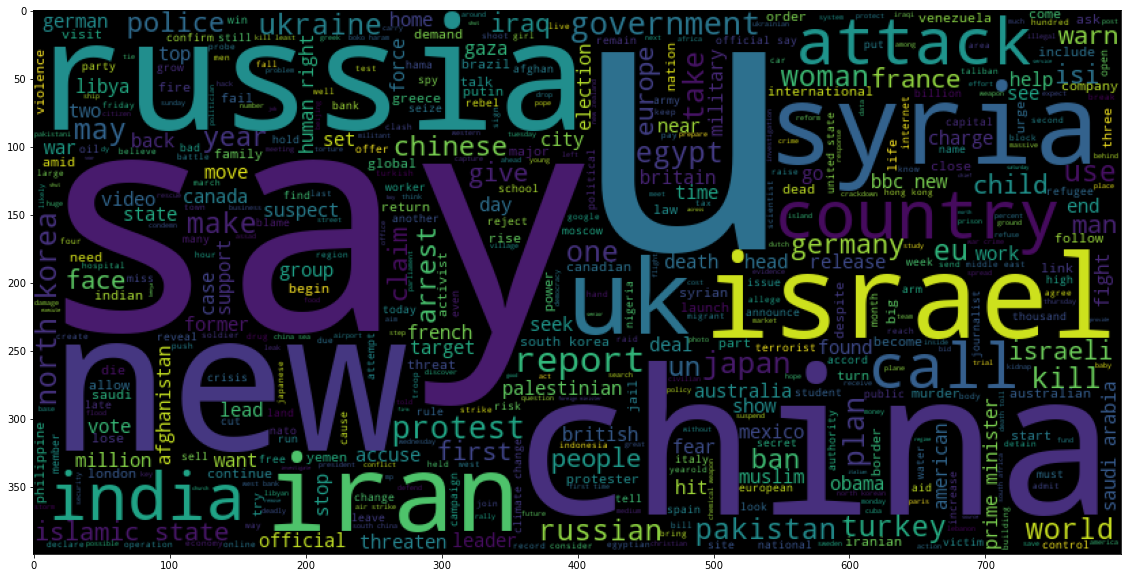

In [21]:
plt.figure(figsize=(20,10))
wc = WordCloud(max_words=500, width = 800, height = 400).generate(' '.join(df2.loc[df2['over_18'] == False, 'title_processed_joined']))
plt.imshow(wc)

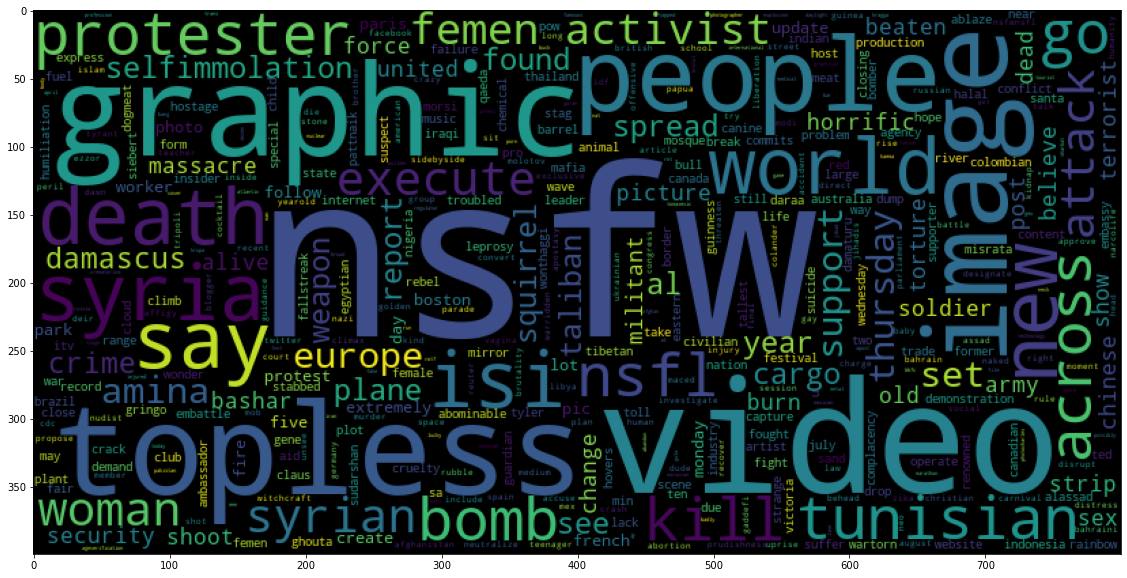

In [22]:
plt.figure(figsize=(20,10))
wc1 = WordCloud(max_words=500, width = 800, height = 400).generate(' '.join(df2.loc[df2['over_18'] == True, 'title_processed_joined']))
plt.imshow(wc1)

**NSFW** (not safe for work), **topless**, etc. clearly demonstrates the kind of content that is marked over_18.

Next, it will be interesting to see how the up_votes really capture the sentiment in the news. Or is there actually any such correlation? To do that, let's use a pre_trained sentiment classifier to classify the sentiments in the text and compare it against the up_votes

In [23]:
df2['sentiment'] = df2['title_processed_joined'].apply(lambda x: TextBlob(x).sentiment.polarity)
df2.head()

index  time_created date_created  up_votes  \
0    2572    1207032715   2008-04-01         2   
1  174001    1365986500   2013-04-15         1   
2  279154    1401459395   2014-05-30         0   
3   59328    1277362604   2010-06-24         7   
4  361394    1429196161   2015-04-16         0   

                                               title  over_18  \
0  Deputies say neglect caused boy to waste away ...    False   
1  Is your old t-shirt hurting African economies?...    False   
2  Indonesian authorities said they were testing ...    False   
3  New Australian PM announces her cabinet. Retai...    False   
4  China Suspends Rules on Tech Companies Serving...    False   

               author                                    title_processed  \
0              yorosa  [deputy, say, neglect, cause, boy, waste, away...   
1  bridgesfreezefirst  [old, tshirt, hurt, african, economy, tshirt, ...   
2         XKryptonite  [indonesian, authority, say, test, product, ma...   
3           shigawire  [new, australian, pm, announces, cabinet, reta...   
4          cyberogism  [china, suspends, rule, tech, company, serve, ...   

                              title_processed_joined  sentiment  
0  deputy say neglect cause boy waste away pound ...  -0.200000  
1  old tshirt hurt african economy tshirt may qui...   0.125000  
2  indonesian authority say test product make bri...   0.000000  
3  new australian pm announces cabinet retains pr...   0.068182  
4        china suspends rule tech company serve bank   0.000000

<AxesSubplot:>

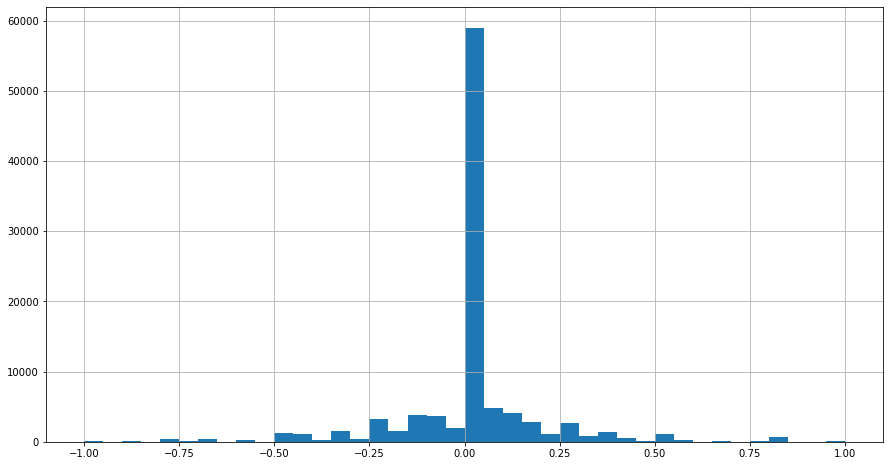

In [24]:
df2.sentiment.hist(bins=40,figsize=(15,8))

In [25]:
len(df2.loc[(df2['sentiment'] > 0.2) | (df2['sentiment'] < -0.2),:])

16293

In [26]:
df2.loc[(df2['sentiment'] > 0.2) | (df2['sentiment'] < -0.2),:].sample(10)

index  time_created date_created  up_votes  \
16027  499030    1476252168   2016-10-12         2   
84040   52366    1269528414   2010-03-25         0   
14685  284064    1403363104   2014-06-21       527   
62896  394861    1441686121   2015-09-08         4   
86419  475935    1468149700   2016-07-10         0   
66784  140845    1350047117   2012-10-12         2   
77968   66040    1287490870   2010-10-19         5   
84143  143777    1351610879   2012-10-30         9   
36039  467373    1465321516   2016-06-07        15   
96357  117098    1331900834   2012-03-16      1210   

                                                   title  over_18  \
16027  Aboriginal survival rests on success of royal ...    False   
84040  Minutes from the buzzing bars and bistros in t...    False   
14685  Anger in Vietnam as China sends four more oil ...    False   
62896  At least 6 held hostage after suspected Islami...    False   
86419  Ecuador sees first conviction for race-based h...    False   
66784  Hillsborough victims  families welcome inquiry...    False   
77968  Germany and the Failure of Multiculturalism\r\...    False   
84143  Qatar accuses Syrian government of genocide af...    False   
36039  Brazil prosecutor seeks arrest of senior membe...    False   
96357  A Jewish man wins his fight against a German m...    False   

                    author                                    title_processed  \
16027       askmeaboutinkl  [aboriginal, survival, rest, success, royal, c...   
84040            carsonbiz  [minute, buzzing, bar, bistro, trendy, canal, ...   
14685           silence_hr  [anger, vietnam, china, sends, four, oil, rig,...   
62896               TRAV1S  [least, held, hostage, suspect, islamist, stor...   
86419        madazzahatter  [ecuador, see, first, conviction, racebased, h...   
66784            BrendanMM  [hillsborough, victim, family, welcome, inquir...   
77968     DrRichardCranium     [germany, failure, george, friedman, stratfor]   
84143  BackFromTheFuture12  [qatar, accuses, syrian, government, genocide,...   
36039             Wagamaga  [brazil, prosecutor, seek, arrest, senior, mem...   
96357       DrJulianBashir  [jewish, man, win, fight, german, museum, retu...   

                                  title_processed_joined  sentiment  
16027  aboriginal survival rest success royal commiss...   0.300000  
84040  minute buzzing bar bistro trendy canal st mart...   0.300000  
14685  anger vietnam china sends four oil rig dispute...  -0.700000  
62896  least held hostage suspect islamist storm hote...  -0.300000  
86419  ecuador see first conviction racebased hatred ...   0.375000  
66784  hillsborough victim family welcome inquiry pol...   0.362500  
77968           germany failure george friedman stratfor  -0.316667  
84143  qatar accuses syrian government genocide fail ...  -0.500000  
36039  brazil prosecutor seek arrest senior member em...  -0.238889  
96357  jewish man win fight german museum return thou...   0.275000

Pretty neutral dataset sentiment-wise. Some of the more polarised news texts(positive or negative) are sampled above. We will focus more on the characterizing the general topics here. The up_votes distribution as shown below is also quite skewed to the left.

<AxesSubplot:>

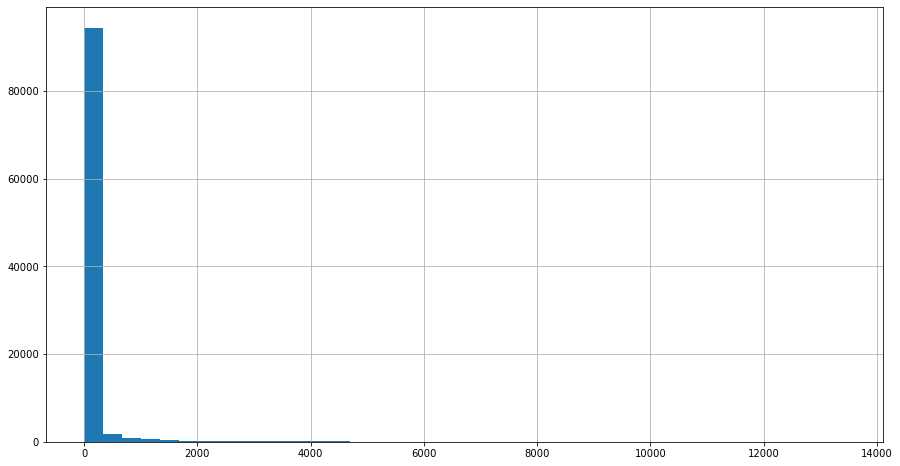

In [27]:
df2.up_votes.hist(bins=40,figsize=(15,8))

In [28]:
df2[df2['up_votes']<=5].up_votes.count()

54187

In [29]:
df2[(df2['up_votes']>5) & (df2['up_votes']<=20)].up_votes.count()

24256

In [30]:
df2[(df2['up_votes']>20) & (df2['up_votes']<=100)].up_votes.count()

11788

In [31]:
df2[(df2['up_votes']>100) & (df2['up_votes']<=500)].up_votes.count()

5346

In [32]:
df2[df2['up_votes'] > 500].up_votes.count()

4423

Let's create a categorical feature from the up_votes column to characterize the distribution better.

In [33]:
ratings = []

for i in range(len(df2)):
    if df2.loc[i, 'up_votes'] > 500:
        ratings.append(5)
    elif df2.loc[i, 'up_votes'] > 100:
        ratings.append(4)
    elif df2.loc[i, 'up_votes'] > 20:
        ratings.append(3)
    elif df2.loc[i, 'up_votes'] > 5:
        ratings.append(2)
    else:
        ratings.append(1)

In [34]:
df2['ratings'] = ratings

In [35]:
df2.head()

index  time_created date_created  up_votes  \
0    2572    1207032715   2008-04-01         2   
1  174001    1365986500   2013-04-15         1   
2  279154    1401459395   2014-05-30         0   
3   59328    1277362604   2010-06-24         7   
4  361394    1429196161   2015-04-16         0   

                                               title  over_18  \
0  Deputies say neglect caused boy to waste away ...    False   
1  Is your old t-shirt hurting African economies?...    False   
2  Indonesian authorities said they were testing ...    False   
3  New Australian PM announces her cabinet. Retai...    False   
4  China Suspends Rules on Tech Companies Serving...    False   

               author                                    title_processed  \
0              yorosa  [deputy, say, neglect, cause, boy, waste, away...   
1  bridgesfreezefirst  [old, tshirt, hurt, african, economy, tshirt, ...   
2         XKryptonite  [indonesian, authority, say, test, product, ma...   
3           shigawire  [new, australian, pm, announces, cabinet, reta...   
4          cyberogism  [china, suspends, rule, tech, company, serve, ...   

                              title_processed_joined  sentiment  ratings  
0  deputy say neglect cause boy waste away pound ...  -0.200000        1  
1  old tshirt hurt african economy tshirt may qui...   0.125000        1  
2  indonesian authority say test product make bri...   0.000000        1  
3  new australian pm announces cabinet retains pr...   0.068182        2  
4        china suspends rule tech company serve bank   0.000000        1

In [36]:
set(df2['ratings'])

{1, 2, 3, 4, 5}

<AxesSubplot:ylabel='ratings'>

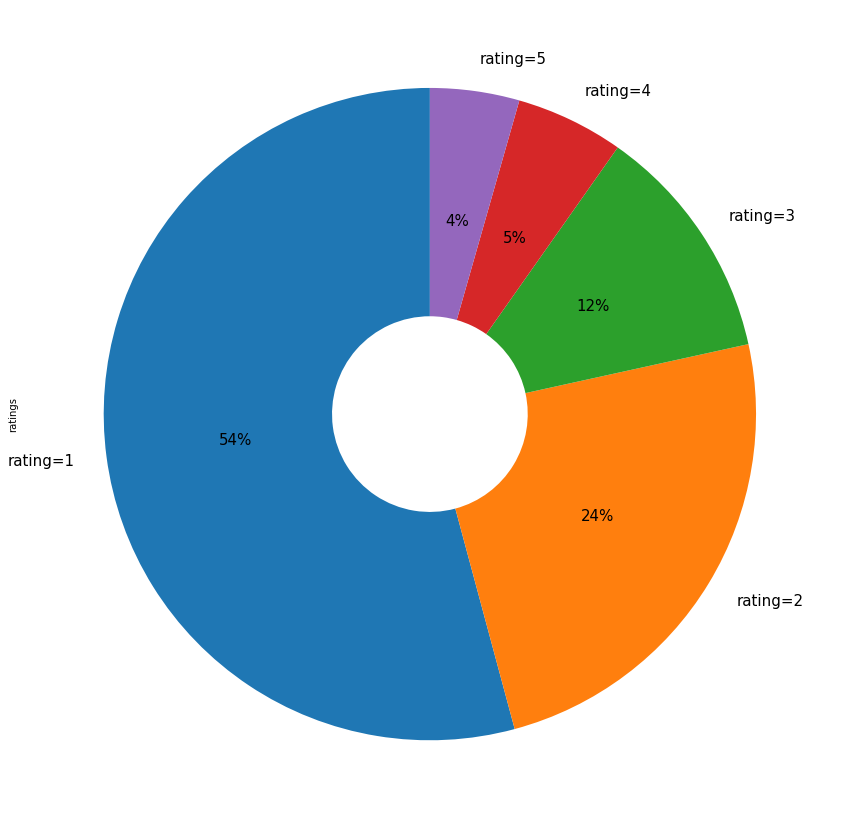

In [37]:
df2.ratings.value_counts().plot(kind='pie', 
                labels = ['rating=1','rating=2', 'rating=3', 'rating=4', 'rating=5'],
                wedgeprops=dict(width=.7),
                autopct='%1.0f%%', startangle= 90, 
                textprops={'fontsize': 15},
                figsize = (30,15))

**Let's use a word cloud to show the 50 most common words for each rating.**

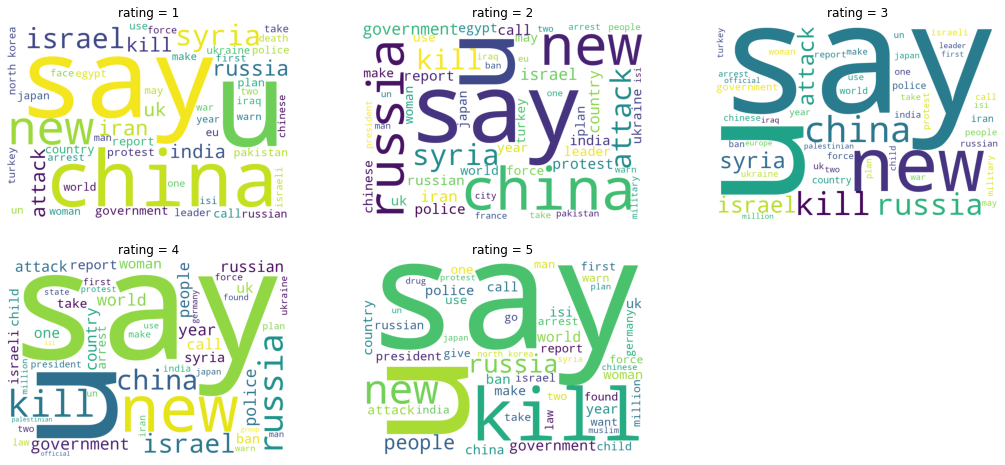

In [38]:
ncols = 3
nrows = 2
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)
for idx , rating in enumerate(set(df2['ratings'])):
    plt.subplot(nrows,ncols,idx+1).axis('Off')
    plt.title(f'rating = {rating}')
    plt.imshow(WordCloud(max_words=50, width = 1000, height = 700, background_color='white').generate(' '.join(df2.loc[df2['ratings'] == rating, 'title_processed_joined'])))

#plt.subplots_adjust(wspace=0.90, hspace=0.3)
plt.show()

In [39]:
# Let's filter the word 'say' which appears to cloud the other important words

def remove_say(words_list):
    return [token for token in words_list if token != 'say']

df_filtered = df2.copy()
df_filtered['title_processed'] = df_filtered['title_processed'].apply(remove_say)
df_filtered['title_processed_joined'] = df_filtered['title_processed'].apply(lambda x: ' '.join(x))

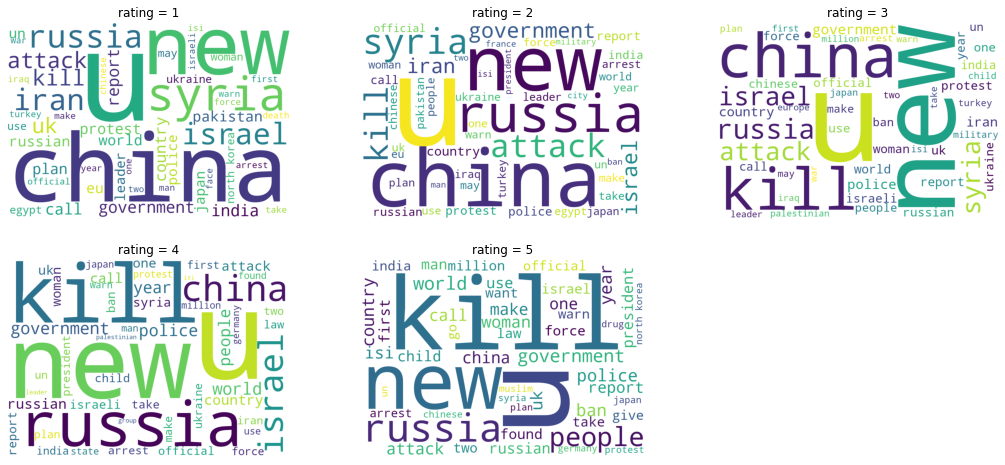

In [40]:
# Let's plot it again

ncols = 3
nrows = 2
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)
for idx , rating in enumerate(set(df_filtered['ratings'])):
    plt.subplot(nrows,ncols,idx+1).axis('Off')
    plt.title(f'rating = {rating}')
    plt.imshow(WordCloud(max_words=50, width = 1000, height = 700, background_color='white').generate(' '.join(df_filtered.loc[df_filtered['ratings'] == rating, 'title_processed_joined'])))

#plt.subplots_adjust(wspace=0.90, hspace=0.3)
plt.show()

**Some conclusions** :
<br>
1. Lower rated news seem to be centered around words like new, China and the word 'u' which actually is US if we check back the un-processed texts. 
2. The word 'new' could be related to something new happening around the world like a 'new' law passed somewhere or a new president/prime minister elected and so on.
3. Higher rated or news with most upvotes belong to the words like 'kill', 'russia', etc apart from the previously seen words from lower rated news like 'u' and 'new'. 'kill' is probably related to killings related to terrorism mostly given that these seem to be mostly global news.

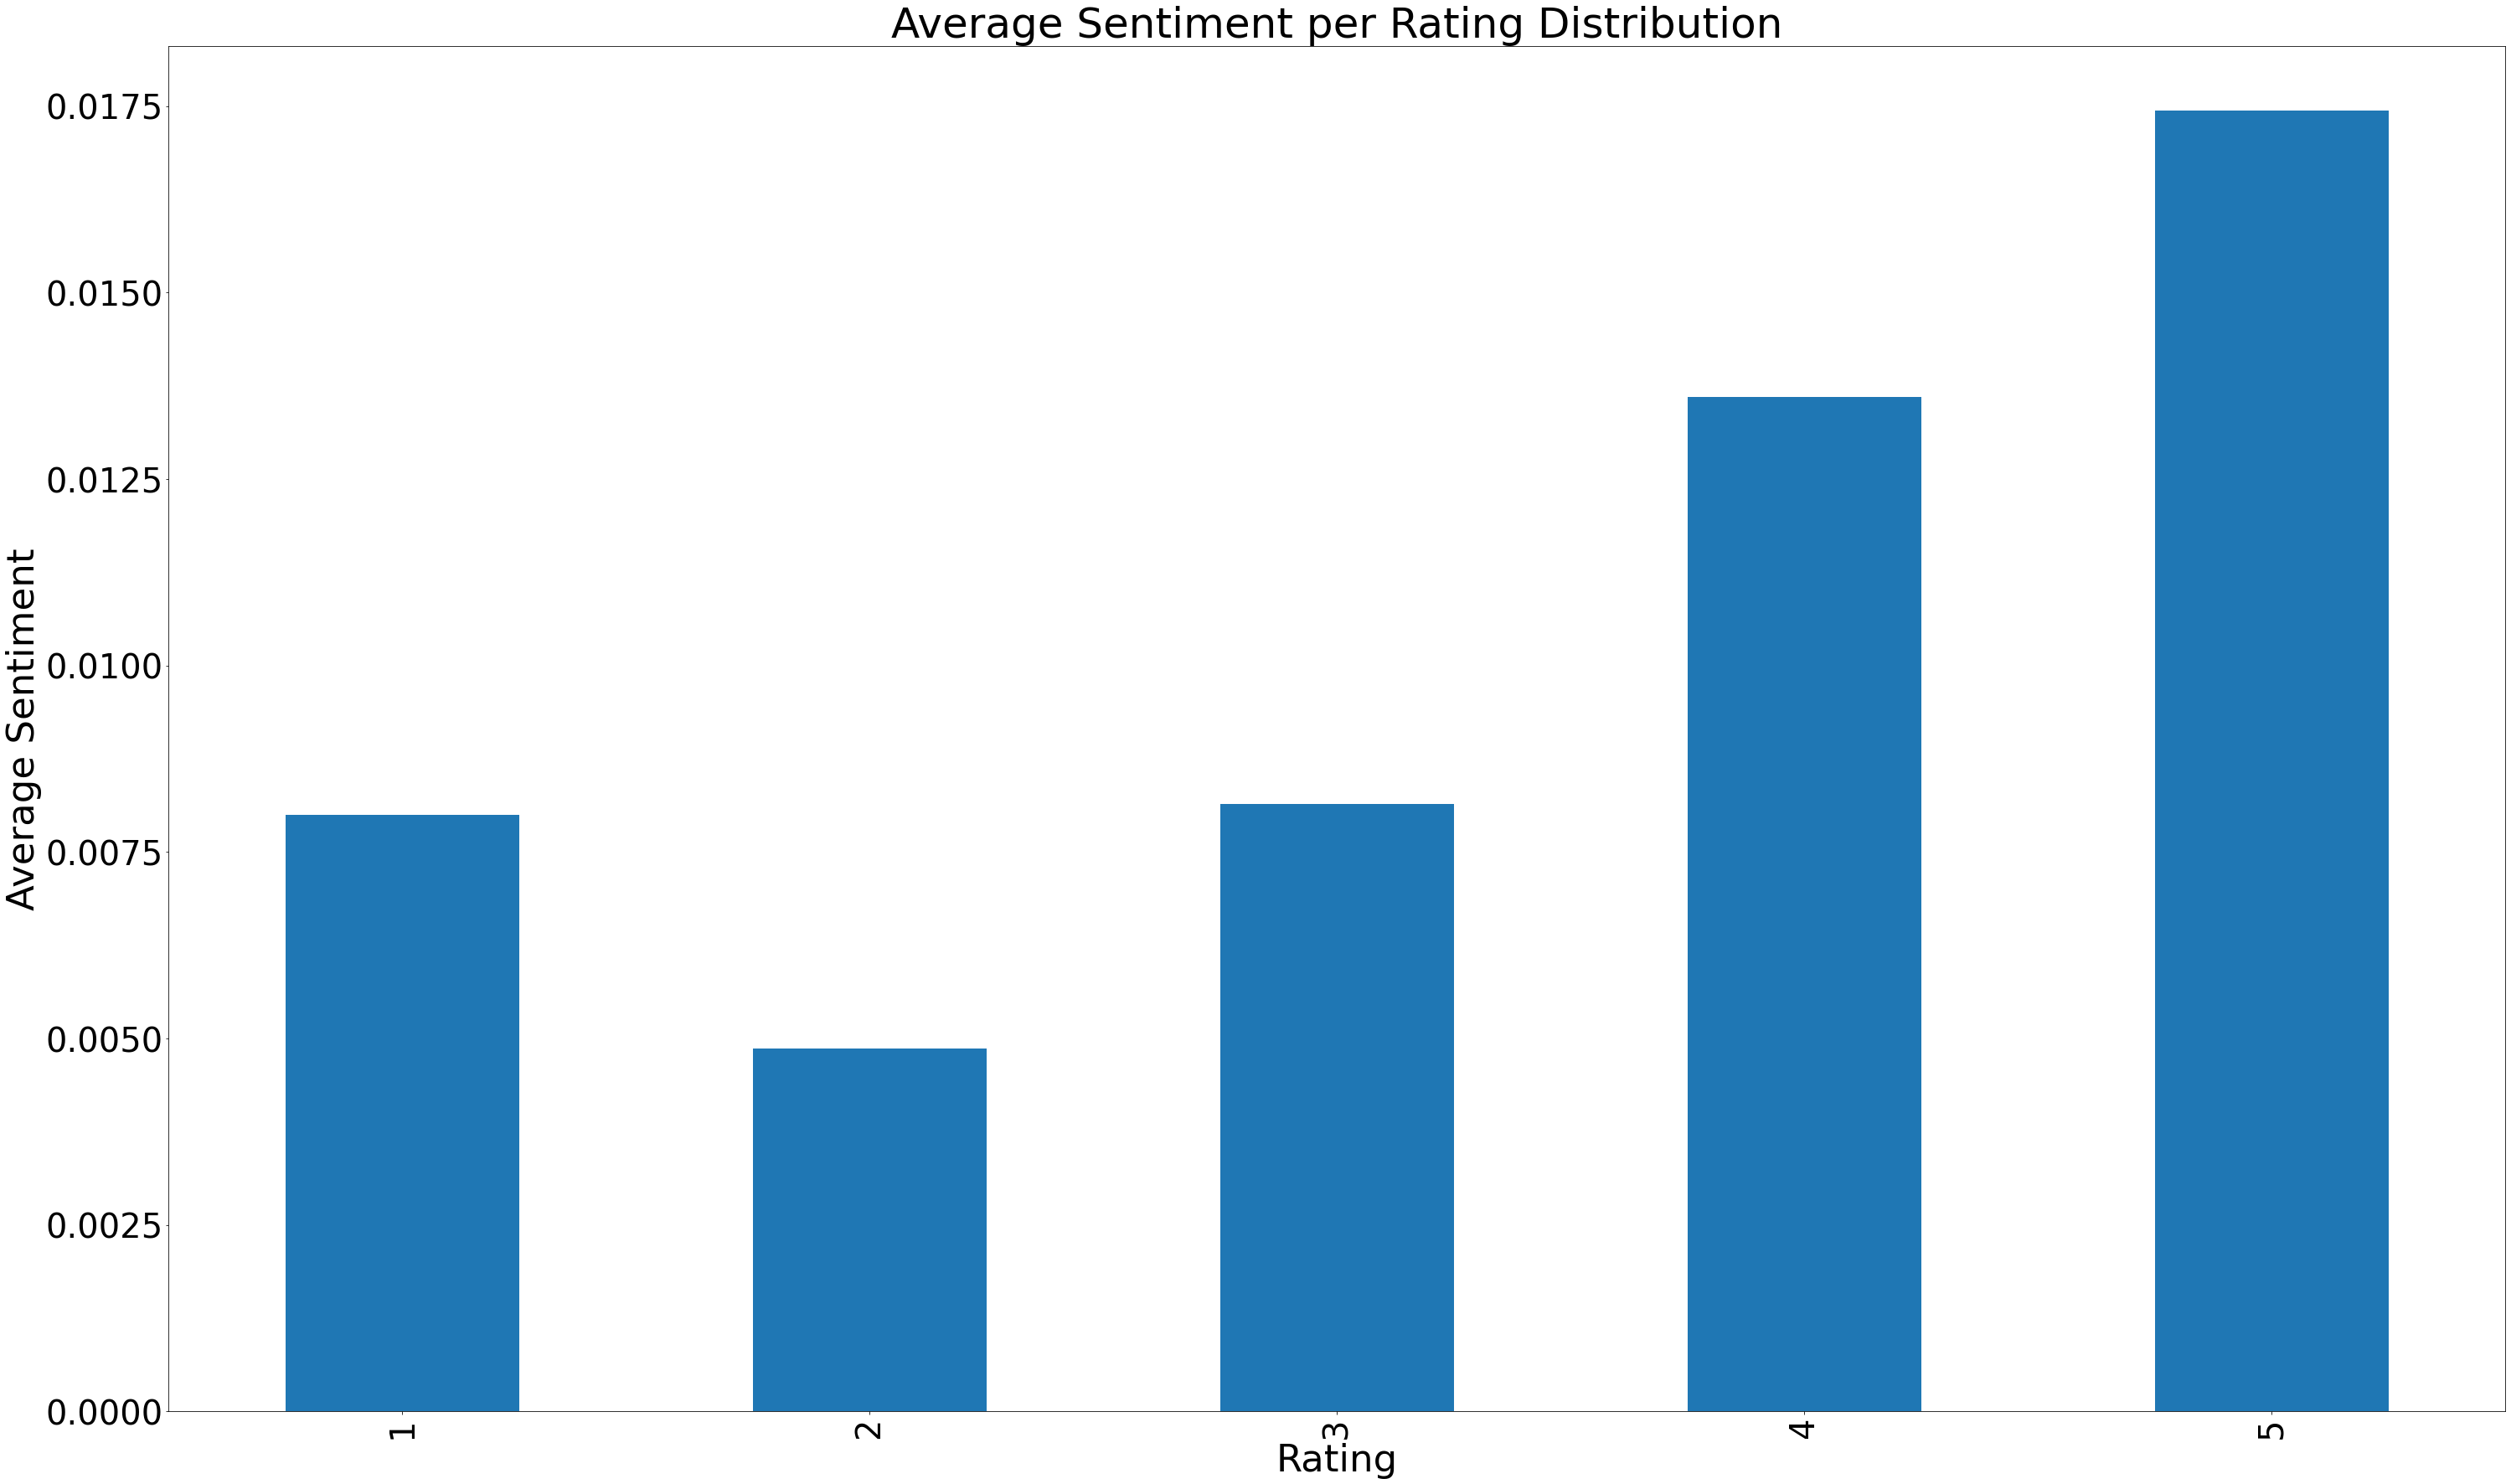

In [41]:
## Average sentiment polarity per rating
## Probably not a lot to be extracted given that the dataset appears to be pretty neutral sentiment-wise

polarity_avg = df_filtered.groupby('ratings')['sentiment'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=45)
plt.ylabel('Average Sentiment', fontsize=45)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Sentiment per Rating Distribution', fontsize=50)
plt.show()

Even though there is a positive sentiment for all of them with the rating 5 taking the lead, this does not tell us much since the differences in the polarities as well as the polarity values themselves are quite tiny. 

How about the number of words in each of these classes of ratings? Could there be any correlation of that to the ratings? Let's see

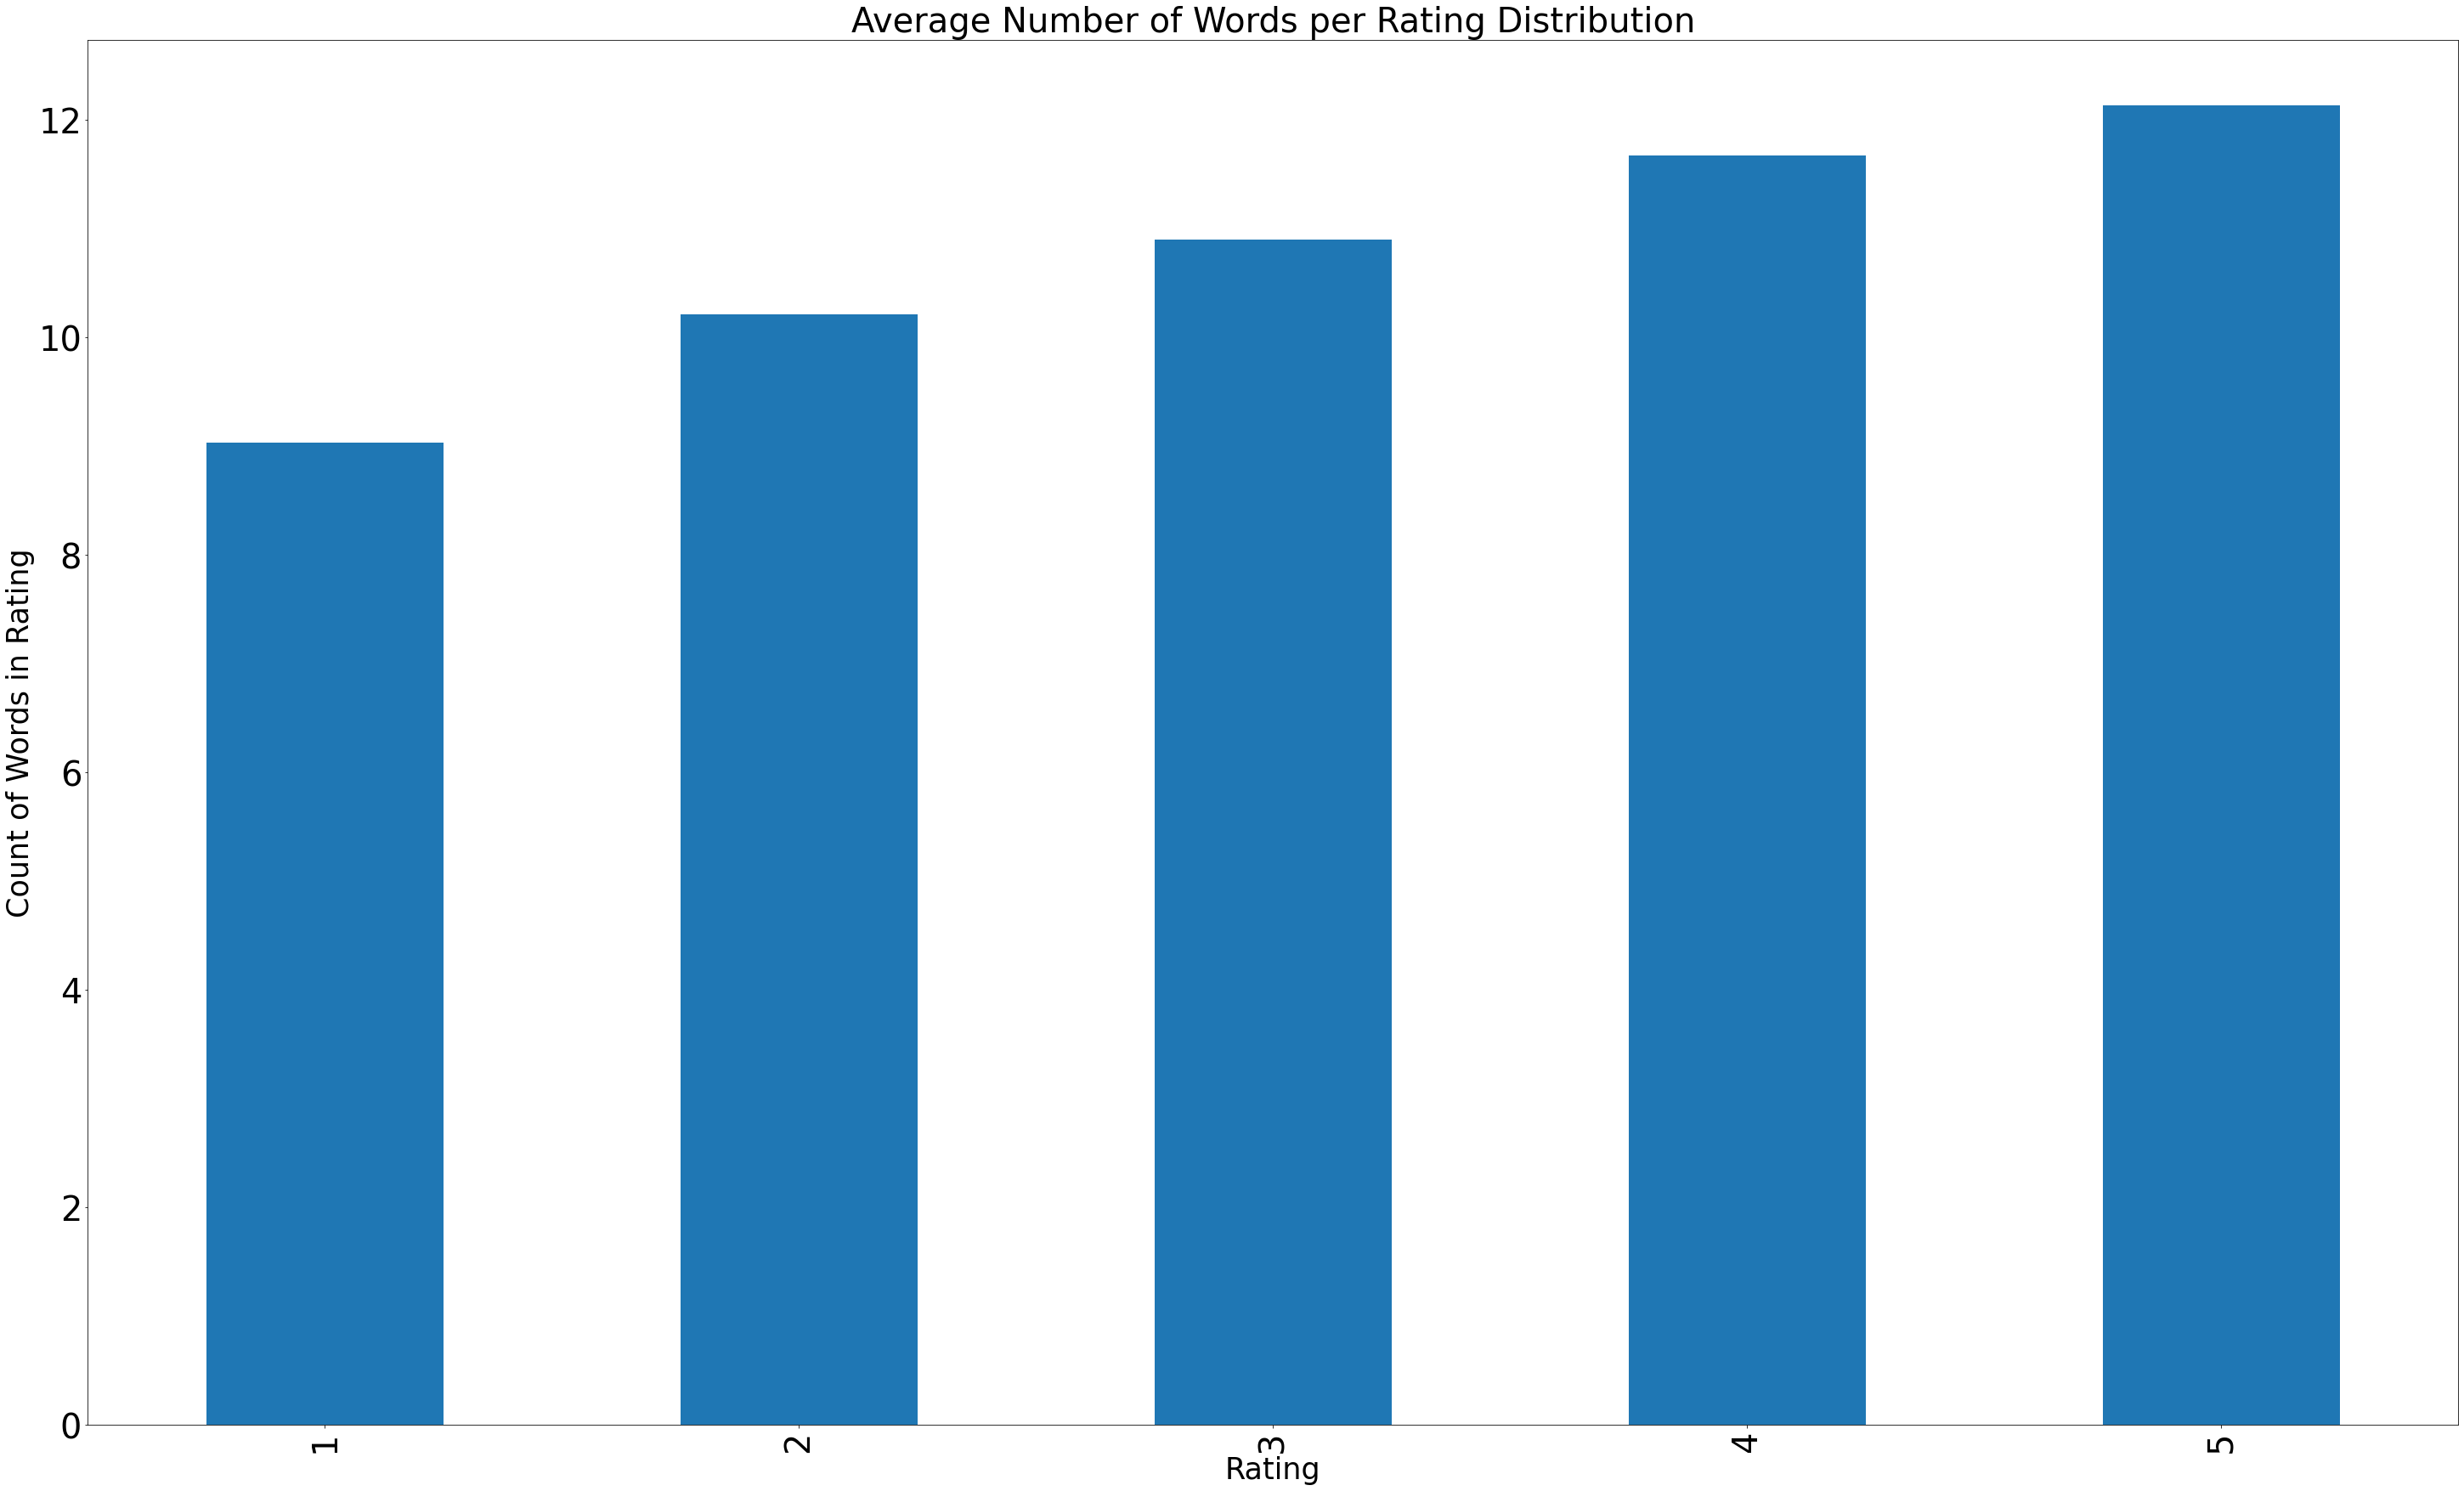

In [42]:
## First have to find the word count for each rating..
df2['word_count'] = df2['title_processed'].apply(lambda x:len(x))

## let's plot the mean number of words
word_avg = df2.groupby('ratings')['word_count'].mean().plot(kind='bar', figsize=(50,30))
plt.xlabel('Rating', fontsize=35)
plt.ylabel('Count of Words in Rating', fontsize=35)
plt.xticks(fontsize=40)
plt.yticks(fontsize=40)
plt.title('Average Number of Words per Rating Distribution', fontsize=40)
plt.show()

**High rated news texts seem to be having more words on average. Even though there isn't a big difference, there is a clear trend of this increase in news (or headline) length with upvotes.**

## Topic Modeling

Now comes the most interesting part (at least for me 😊) . Here, we will extract the most frequently discussed topics from the texts provided. We will use non-negative matrix factorization for this purpose where the basic idea is to achieve a dimensionalty reduction of the entire feature matrix for all the samples through its factorization. We will use the decomposition module in sklearn for this. But first we need to create a features matrix using the TfidfVectorizer that uses TF-IDF internally to find the weightage of each feature (an n-gram).

In [43]:
# Max_df=0.9 will remove words that appear in more than 90% of the reviews. 
# Min_df=25 will remove words that appear in less than 25 reviews.
# Will use the default Frobenius objective function to minimize 

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=5000)
tfidf = tfidf_vectorizer.fit_transform(df2['title_processed_joined'])

In [44]:
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
doc_term_matrix_tfidf = pd.DataFrame(tfidf.toarray(), columns=list(tfidf_feature_names))

In [45]:
doc_term_matrix_tfidf.sample(10)

abandon  abbas  abbott  abc  abduct  abduction  abdullah  abe  ability  \
35070      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
40003      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
91028      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
68599      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
74903      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
35191      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
29238      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
18832      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
9118       0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   
99116      0.0    0.0     0.0  0.0     0.0        0.0       0.0  0.0      0.0   

       able  ...  yuan  zealand  zero  zika  zimbabwe  zimbabwean  zionist  \
35070   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
40003   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
91028   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
68599   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
74903   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
35191   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
29238   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
18832   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
9118    0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   
99116   0.0  ...   0.0      0.0   0.0   0.0       0.0         0.0      0.0   

       zone  zoo  zuma  
35070   0.0  0.0   0.0  
40003   0.0  0.0   0.0  
91028   0.0  0.0   0.0  
68599   0.0  0.0   0.0  
74903   0.0  0.0   0.0  
35191   0.0  0.0   0.0  
29238   0.0  0.0   0.0  
18832   0.0  0.0   0.0  
9118    0.0  0.0   0.0  
99116   0.0  0.0   0.0  

[10 rows x 4550 columns]

In [46]:
# function to show the top 10 topics from the dataset based on the NMF analysis

def display_topics(model, feature_names, num_top_words):
    for topic_id, topic in enumerate(model.components_):
        print(f'Topic : {topic_id}')
        print(' '.join([feature_names[i]
                          for i in topic.argsort()[:-num_top_words - 1:-1]]))

In [47]:
nmf = NMF(n_components=10, alpha=.05, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names, 10)

Topic : 0
new year world government protest uk police first woman india
Topic : 1
korea north south korean missile nuclear test launch kim un
Topic : 2
kill least people bomb pakistan strike soldier suicide blast militant
Topic : 3
china sea south chinese japan dispute island military beijing taiwan
Topic : 4
syria state islamic syrian rebel isi war iraq fight weapon
Topic : 5
iran israel nuclear palestinian gaza deal israeli talk hamas un
Topic : 6
russia ukraine putin russian sanction eu crimea military crisis nato
Topic : 7
news bbc world yahoo agency hack break fox cup murdoch
Topic : 8
say official un minister president report group chief right may
Topic : 9
attack police suspect paris arrest terror dead terrorist suicide bomb


/Users/jyotisman/miniforge3/envs/nlp_env/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


We can now deduce the topics with a lit bit of intuition. I label them as follows. Topic 7 is a bit hard to tell but maybe a mapping to the actual news texts will tell us what it is.
<br>

**Topic 0** : Unknown1? 
<br>
**Topic 1** : North and South Korea tensions
<br>
**Topic 2** : Terrorism in Pakistan
<br>
**Topic 3** : China Japan territory dispute
<br>
**Topic 4** : Syria and ISI
<br>
**Topic 5** : Iran nuclear sanctions
<br>
**Topic 6** : Russia-Ukraine dispute (sanctions on Russia)
<br>
**Topic 7** : Unknown2?
<br>
**Topic 8** : Israel-Palestine war
<br>
**Topic 9** : Paris terrorism incidents

In [48]:
nmf_topic_values = nmf.transform(tfidf)
df2['nmf_topics'] = nmf_topic_values.argmax(axis=1)

In [49]:
nmf_map = {0: 'Unknown1?', 1: 'North and South Korea tensions', 2: 'Terrorism in Pakistan', 3: 'China Japan territory dispute', 
             4: 'Syria and ISI', 5: 'Iran nuclear sanctions', 6: 'Russia-Ukraine dispute (sanctions on Russia)', 7: ' Unknown2?', 
             8: 'Israel-Palestine war', 9: 'Paris terrorism incidents'}
df2['nmf_topics'] = df2['nmf_topics'].map(nmf_map)

(array([    0., 10000., 20000., 30000., 40000., 50000., 60000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

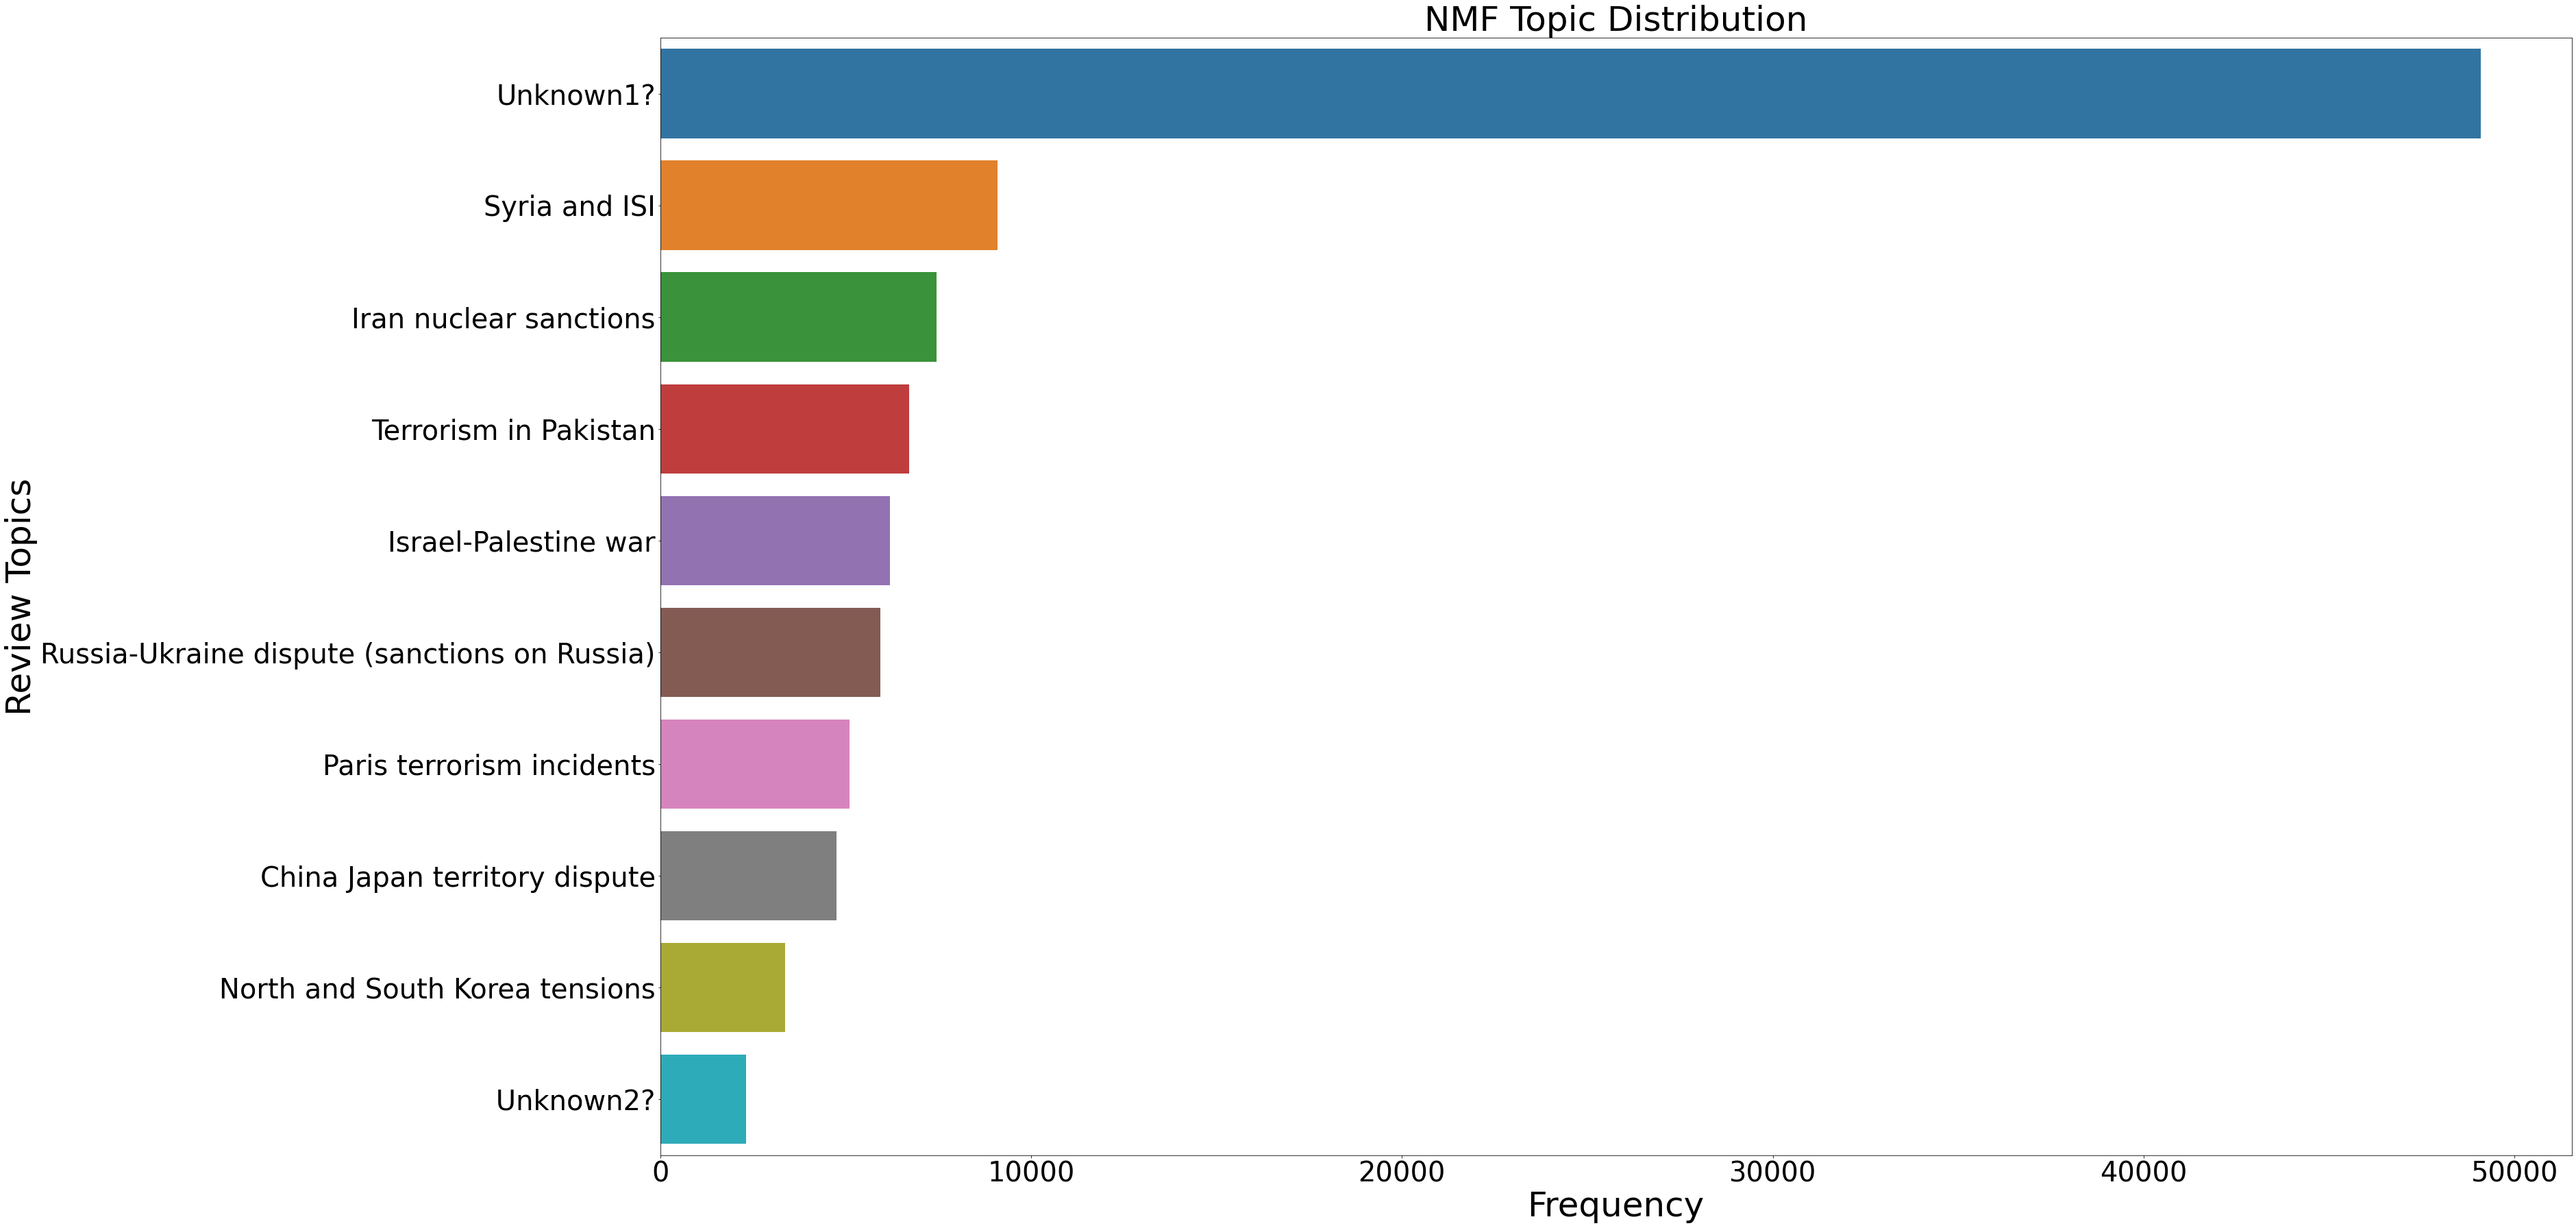

In [50]:
nmf_x = df2['nmf_topics'].value_counts()
nmf_y = list(nmf_x.index)
plt.figure(figsize=(50,30))
sns.barplot(x = nmf_x, y = nmf_y)
plt.title("NMF Topic Distribution", fontsize=50)
plt.ylabel('Review Topics', fontsize=50)
plt.yticks(fontsize=40)
plt.xlabel('Frequency', fontsize=50)
plt.xticks(fontsize=40)

In [51]:
df2.sample(10)

index  time_created date_created  up_votes  \
40575  105161    1320839734   2011-11-09       339   
45473  503500    1477773292   2016-10-29         0   
40965  233914    1386269658   2013-12-05        84   
40392  284516    1403555892   2014-06-23         1   
78635  357152    1427695806   2015-03-30         2   
35488  355383    1427040211   2015-03-22         5   
21796   38984    1246886949   2009-07-06         0   
26387  373671    1433568759   2015-06-06        11   
71194   22955    1231266892   2009-01-06         0   
48402  308981    1411480649   2014-09-23        20   

                                                   title  over_18  \
40575  World headed for irreversible climate change i...    False   
45473  Twenty-five people have been killed in two day...    False   
40965  Russia s High Court Declares  Gay Propaganda  ...    False   
40392  A Sudanese woman who was sentenced to death on...    False   
78635   Human rights law has no place on the battlefi...    False   
35488  Tunisia arrests more than 20 in crackdown sinc...    False   
21796  At least 140 people were killed and 800 injure...    False   
26387  Ghana Opens Biggest Dam in Capital as Flood De...    False   
71194  EVERYONE Talks about Occupation 101, but befor...    False   
48402  Erdogan hints Turkey underwent ISIS prisoner swap    False   

                  author                                    title_processed  \
40575             Woolew  [world, head, irreversible, climate, change, f...   
45473           handi3uu  [twentyfive, people, kill, two, day, violence,...   
40965     FlowersOfSodom  [russia, high, court, declares, gay, propagand...   
40392              Hadok  [sudanese, woman, sentence, death, may, aposta...   
78635           Smithman  [human, right, law, place, battlefield, policy...   
35488  SussSuspectDevice  [tunisia, arrest, crackdown, since, museum, at...   
21796             twolf1  [least, people, kill, injured, police, muslim,...   
26387           FOXBERRY  [ghana, open, big, dam, capital, flood, death,...   
71194            Drexxle  [everyone, talk, occupation, ship, one, want, ...   
48402    not_slim_shaddy  [erdogan, hint, turkey, underwent, isi, prison...   

                                  title_processed_joined  sentiment  ratings  \
40575  world head irreversible climate change five ye...   0.000000        4   
45473  twentyfive people kill two day violence centra...   0.000000        1   
40965  russia high court declares gay propaganda ban ...   0.158889        3   
40392  sudanese woman sentence death may apostasy fre...   0.000000        1   
78635  human right law place battlefield policy excha...   0.142857        1   
35488       tunisia arrest crackdown since museum attack  -0.050000        1   
21796  least people kill injured police muslim uighur...  -0.066667        1   
26387        ghana open big dam capital flood death near   0.033333        2   
71194      everyone talk occupation ship one want exodus   0.000000        1   
48402    erdogan hint turkey underwent isi prisoner swap   0.000000        2   

       word_count                                    nmf_topics  
40575           9                                     Unknown1?  
45473          13                         Terrorism in Pakistan  
40965           8  Russia-Ukraine dispute (sanctions on Russia)  
40392          11                          Israel-Palestine war  
78635           8                                     Unknown1?  
35488           6                     Paris terrorism incidents  
21796          14                         Terrorism in Pakistan  
26387           8                                     Unknown1?  
71194           7                        Iran nuclear sanctions  
48402           7                                 Syria and ISI

**We capture some topics while some others really badly.** 

## Yearwise Topic modeling with NMF

Even though we are able to capture the right topic for some news, we are way off in some other categories. The reason being that there are way too many categories than 10. A better characterization would come from doing the same but now yearwise since we have a datetime column. Let's see how that works out.

In [52]:
df['date_created'] =  pd.to_datetime(df['date_created'])
df['year'] = df.date_created.dt.year

In [53]:
df.year.value_counts()

2015    94621
2014    92030
2013    88231
2016    81892
2012    42643
2011    38886
2009    25115
2010    23313
2008    22505
Name: year, dtype: int64

In [54]:
# process the entire dataset now. Does take some time. Could use some parallelism later to speed it up (like swifter or a spark dataframe).
# Maybe for later. Certainly need to use it for a larger dataset. We also filter the word 'say' from the entire dataset.

df['title_processed'] = df['title'].apply(process_text).apply(remove_say)

df['title_processed_joined'] = df['title_processed'].apply(lambda x: ' '.join(x))

In [55]:
df.loc[df['year']==2016,'title_processed_joined']

427344    dubai new year firework go ahead fire engulfs ...
427345    iran denies fire rocket near u warship gulf co...
427346    geneediting injection could one day offer hope...
427347    south china sea teen camp dispute land young a...
427348    china jail activist support hong kong democrac...
                                ...                        
509231    heil trump donald trump altright white nationa...
509232              people speculate could madeleine mccann
509233             professor receives arab researcher award
509234    nigel farage attack response trump ambassador ...
509235    palestinian wield knife shot dead west bank is...
Name: title_processed_joined, Length: 81892, dtype: object

Let's first look at the **most common words** in worldnews yearwise to get a quick idea about the topics

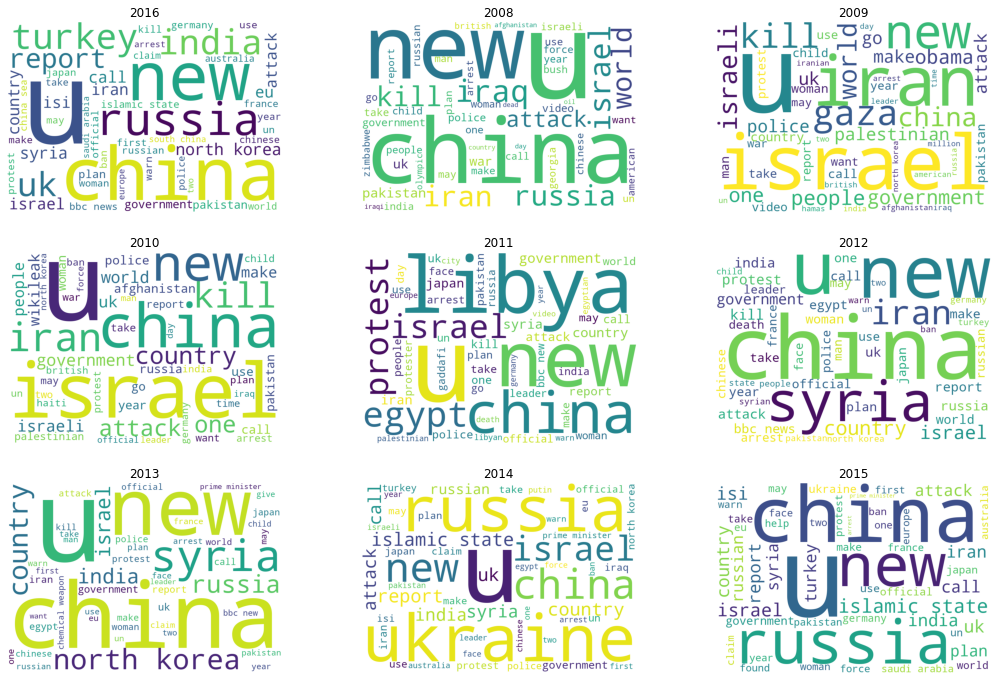

In [56]:
ncols = 3
nrows = 3
fig = plt.gcf()
fig.set_size_inches(ncols*6, nrows*4)
for idx , year in enumerate(set(df.year)):
    plt.subplot(nrows,ncols,idx+1).axis('Off')
    plt.title(f'{year}')
    plt.imshow(WordCloud(max_words=50, width = 1000, height = 700, background_color='white').generate(' '.join(df.loc[df['year'] == year, 'title_processed_joined'])))

#plt.subplots_adjust(wspace=0.90, hspace=0.3)
plt.show()

Now we will go a step ahead and try to find some popular news topics each year. First let's defne some functions we will use for plotting. 

In [57]:
# Taken from -
# https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py

def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'Topic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

In [58]:
# Apart from plotting the frequently used words, we use the upvotes column to look at the popularity of each topic.

def plot_popular_topics(nmf, tfidf_feature_names, n_top_words, title, year):
    
    plot_top_words(nmf, tfidf_feature_names, 10,
               title)

    df_copy = df.loc[df['year']==year,:].reset_index()
    nmf_topic_values = nmf.transform(tfidf)
    df_copy['nmf_topics'] = nmf_topic_values.argmax(axis=1)

    nmf_remap = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4', 
                 4: 'Topic 5', 5: 'Topic 6', 6: 'Topic 7', 7: 'Topic 8', 
                 8: 'Topic 9', 9: 'Topic 10'}
    df_copy['nmf_topics'] = df_copy['nmf_topics'].map(nmf_remap)

    nmf_x = df_copy.groupby('nmf_topics')['up_votes'].mean().sort_values(ascending=False)
    nmf_y = list(nmf_x.index)
    plt.figure(figsize=(50,30))
    sns.barplot(x = nmf_x, y = nmf_y)
    plt.title("NMF Topic popularities", fontsize=50)
    plt.ylabel('Topics', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xlabel('Mean up_votes', fontsize=50)
    plt.xticks(fontsize=40)
    plt.show()

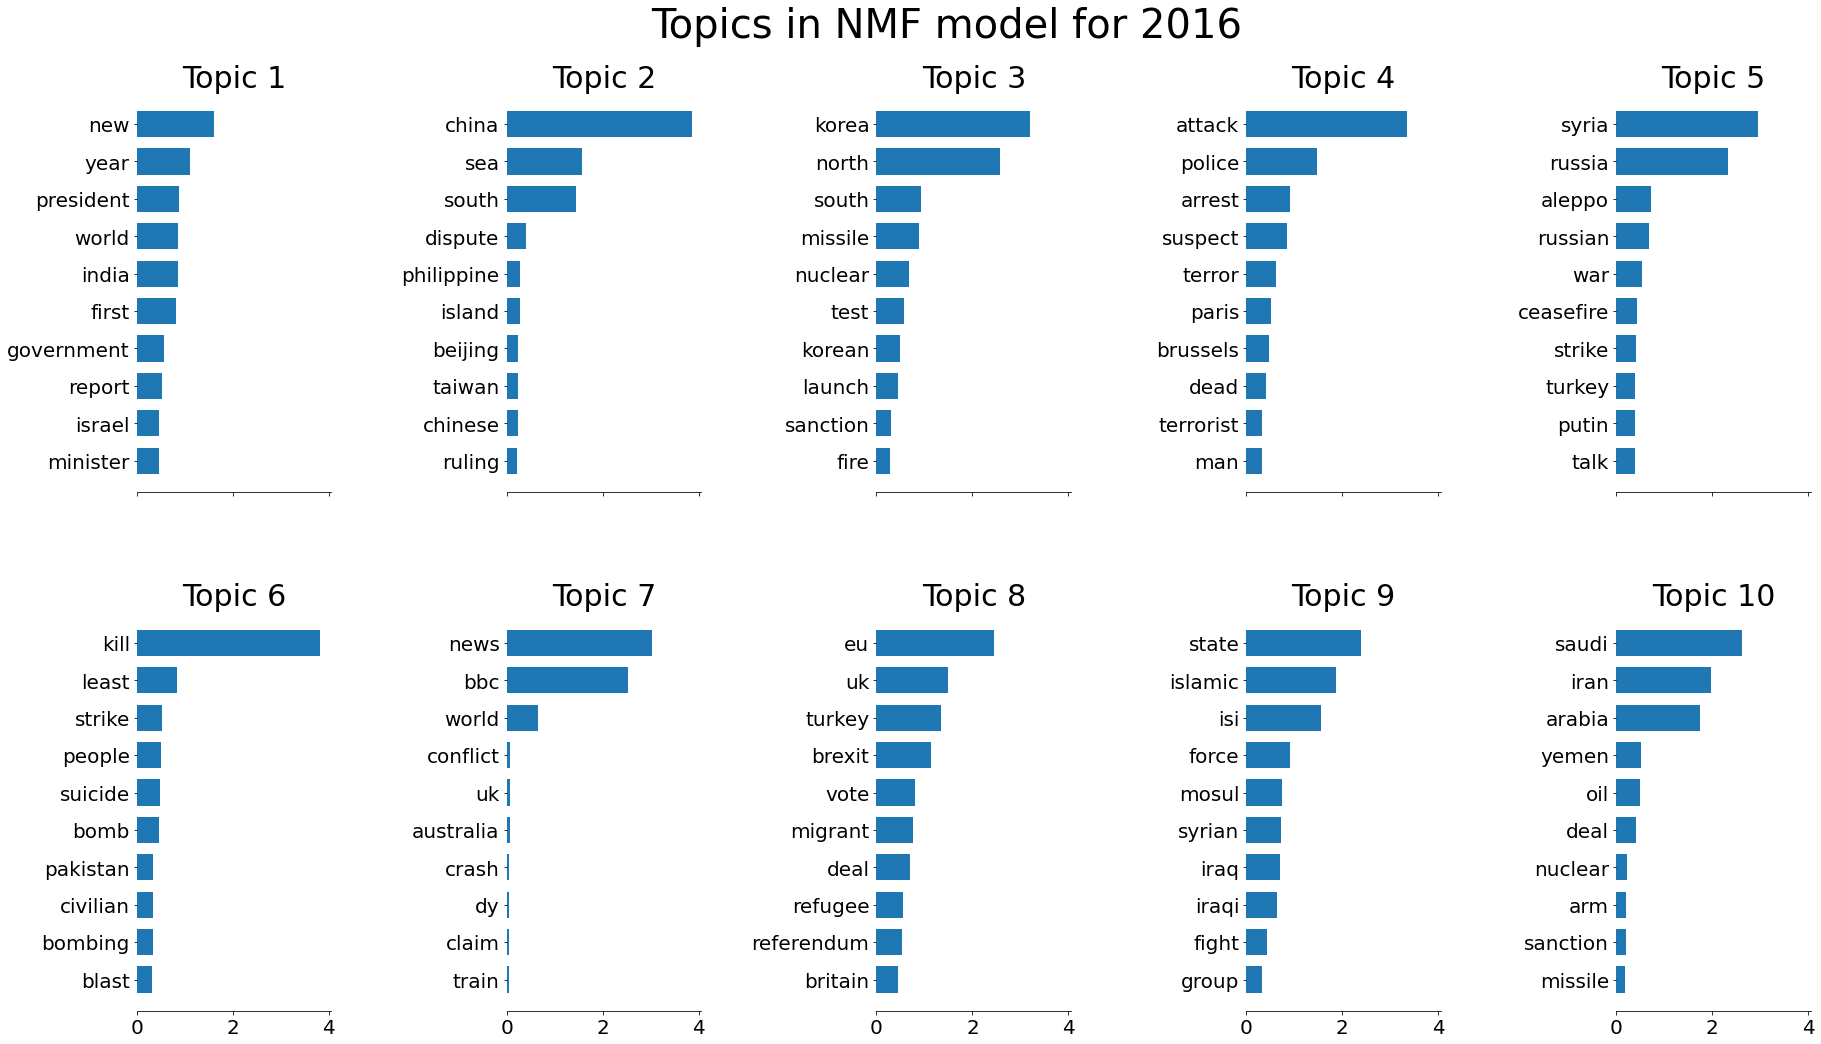

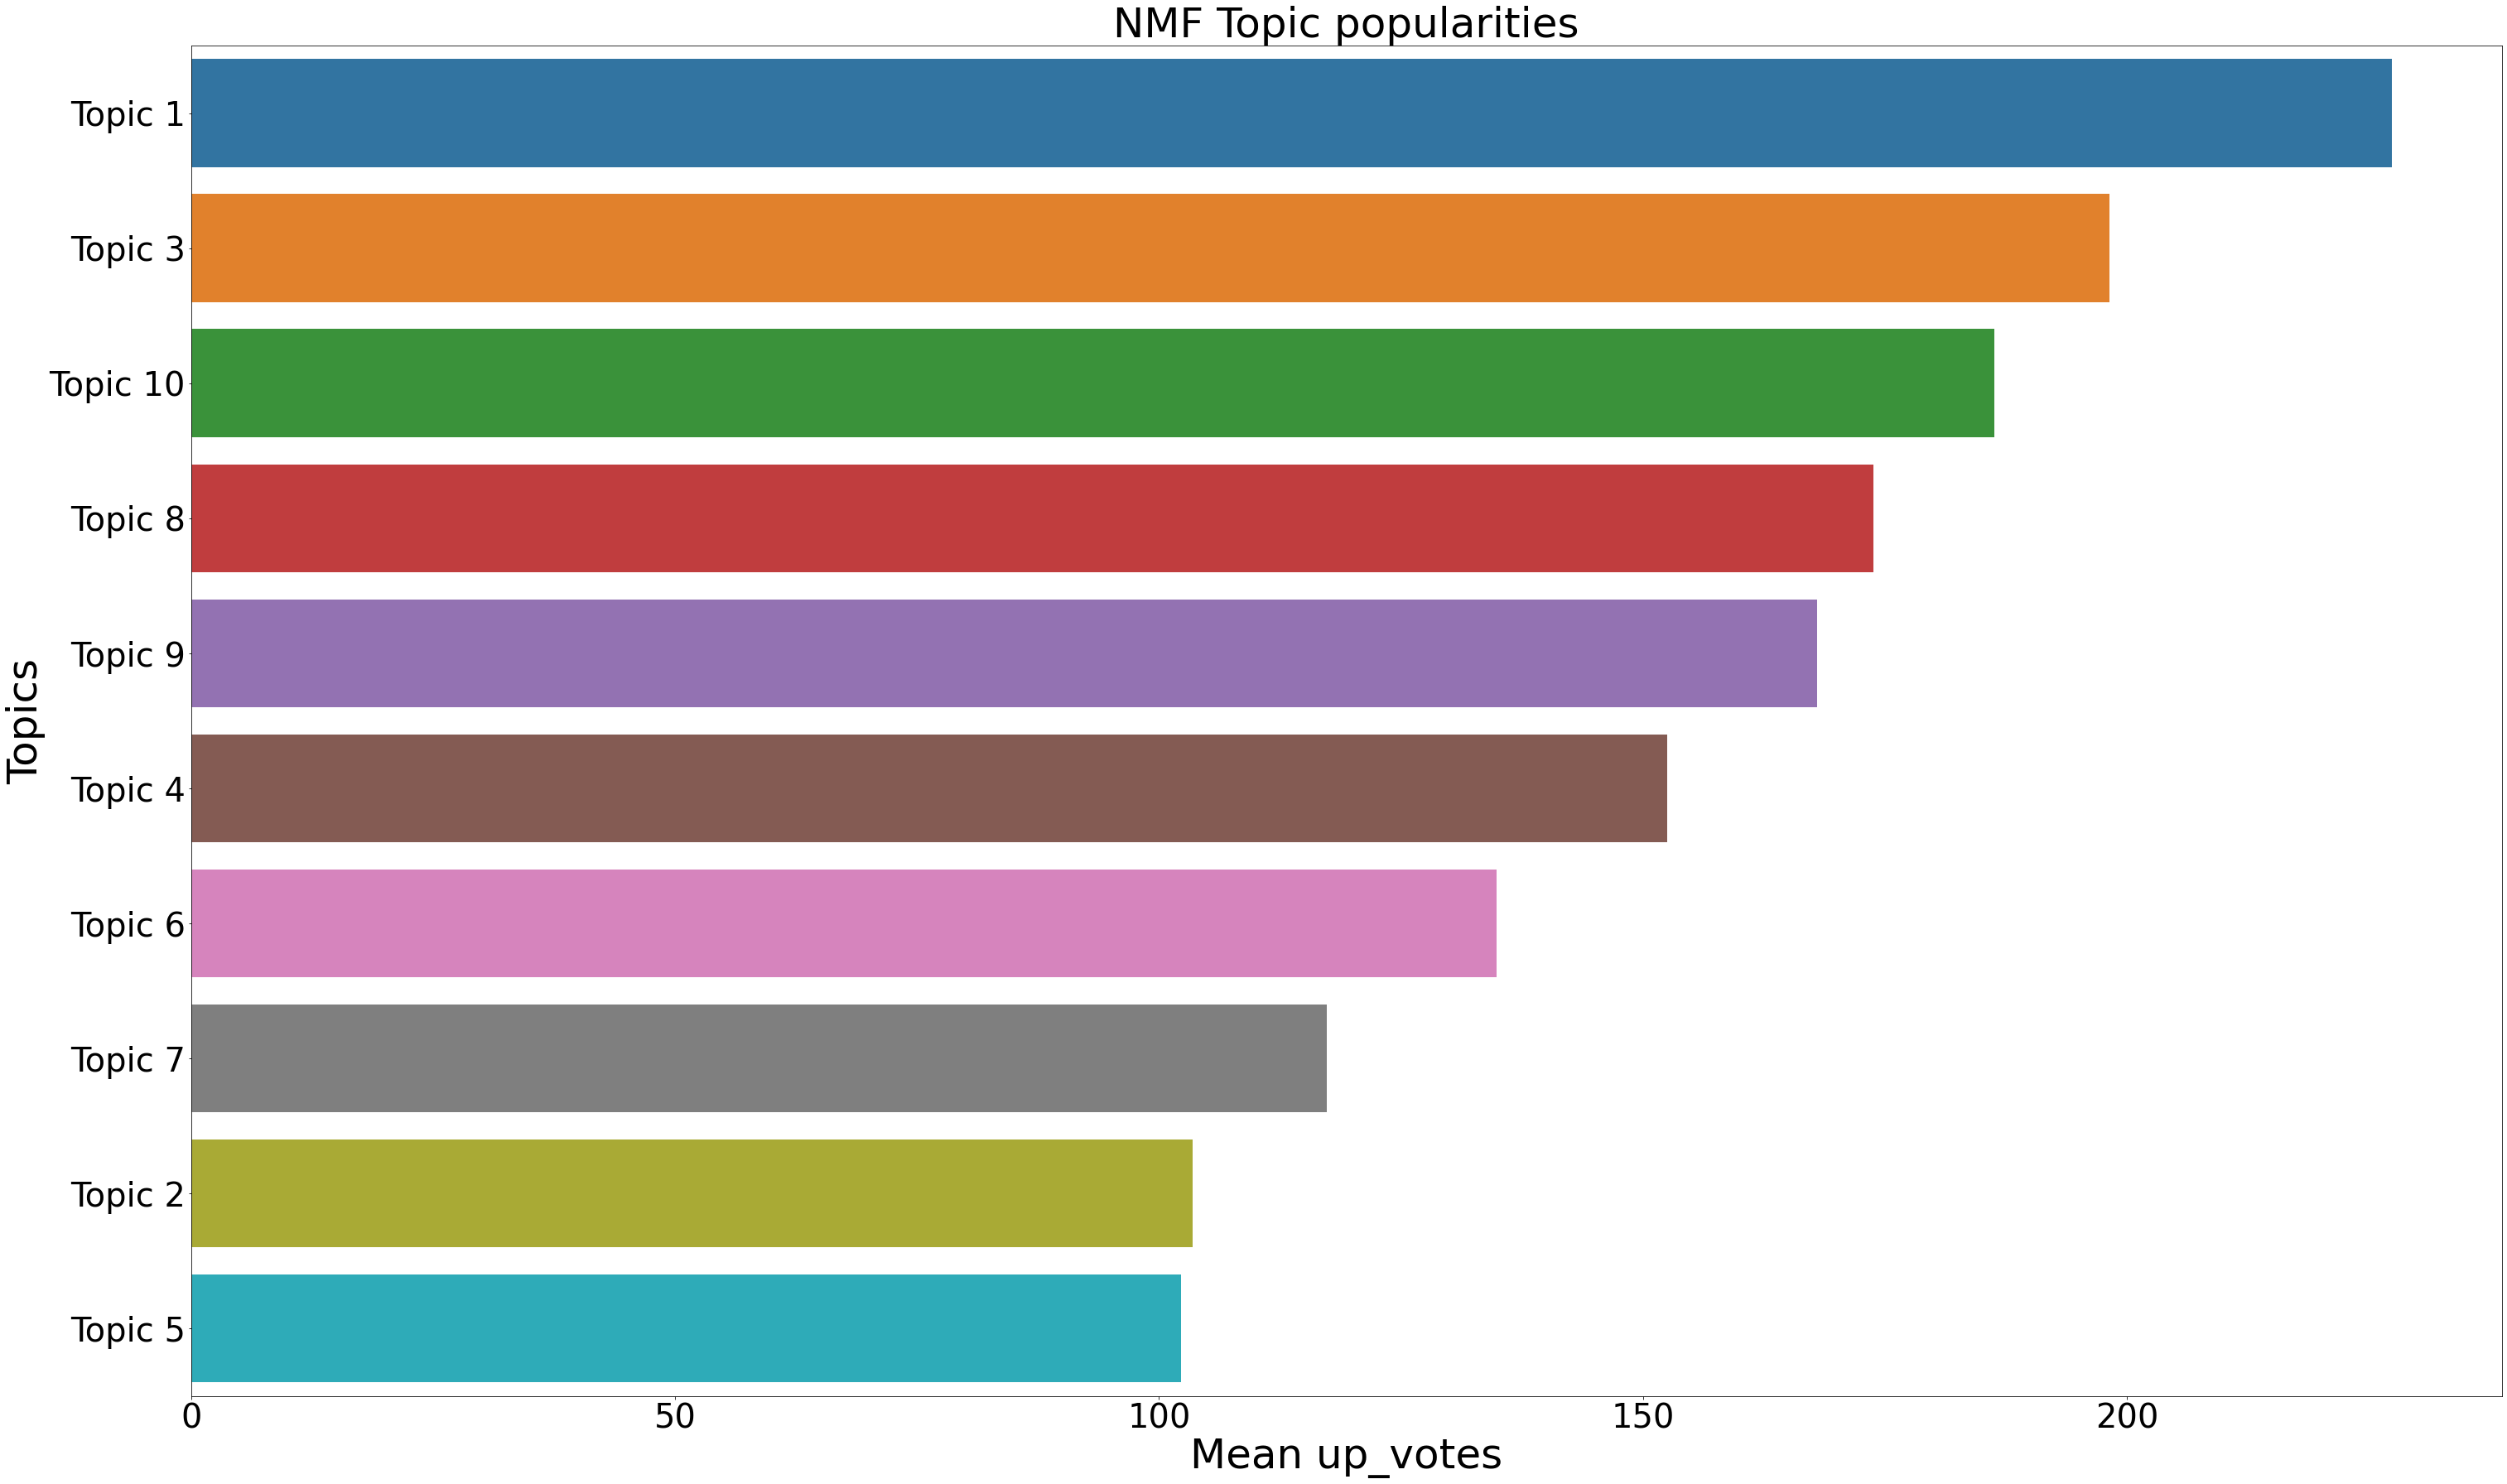

In [59]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =20, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2016,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2016', 2016)

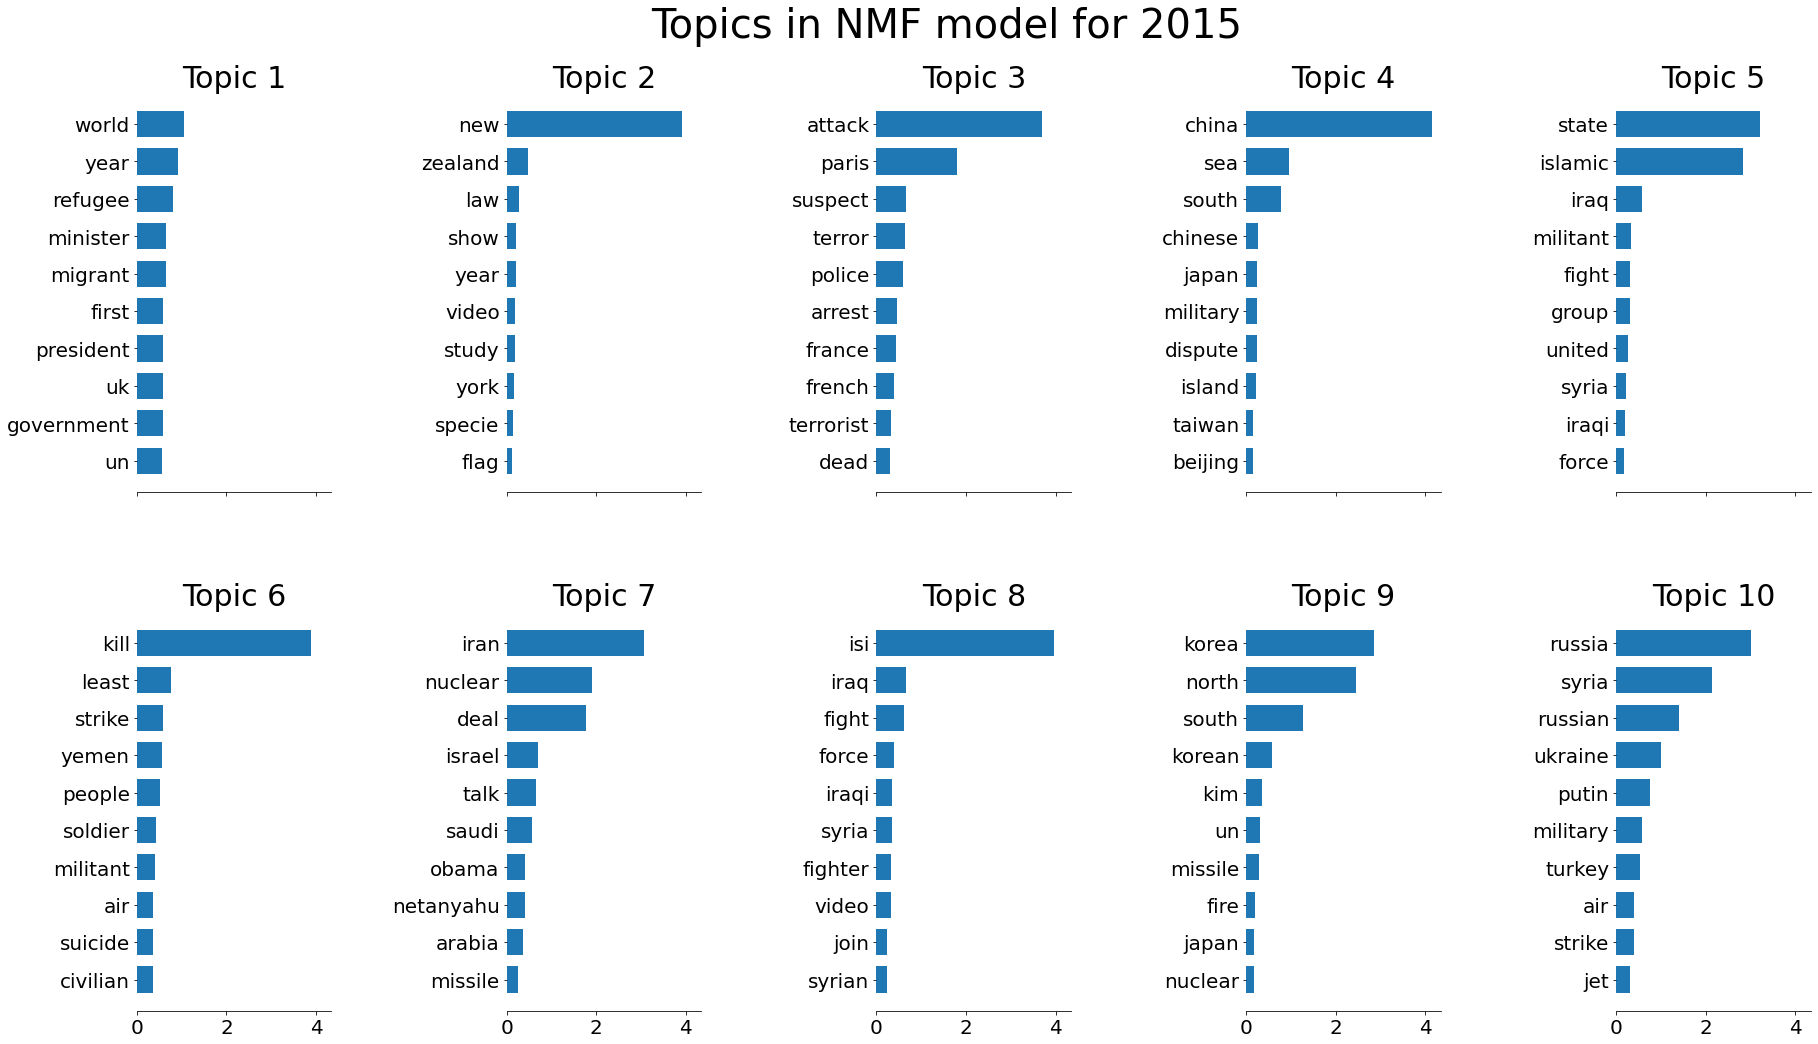

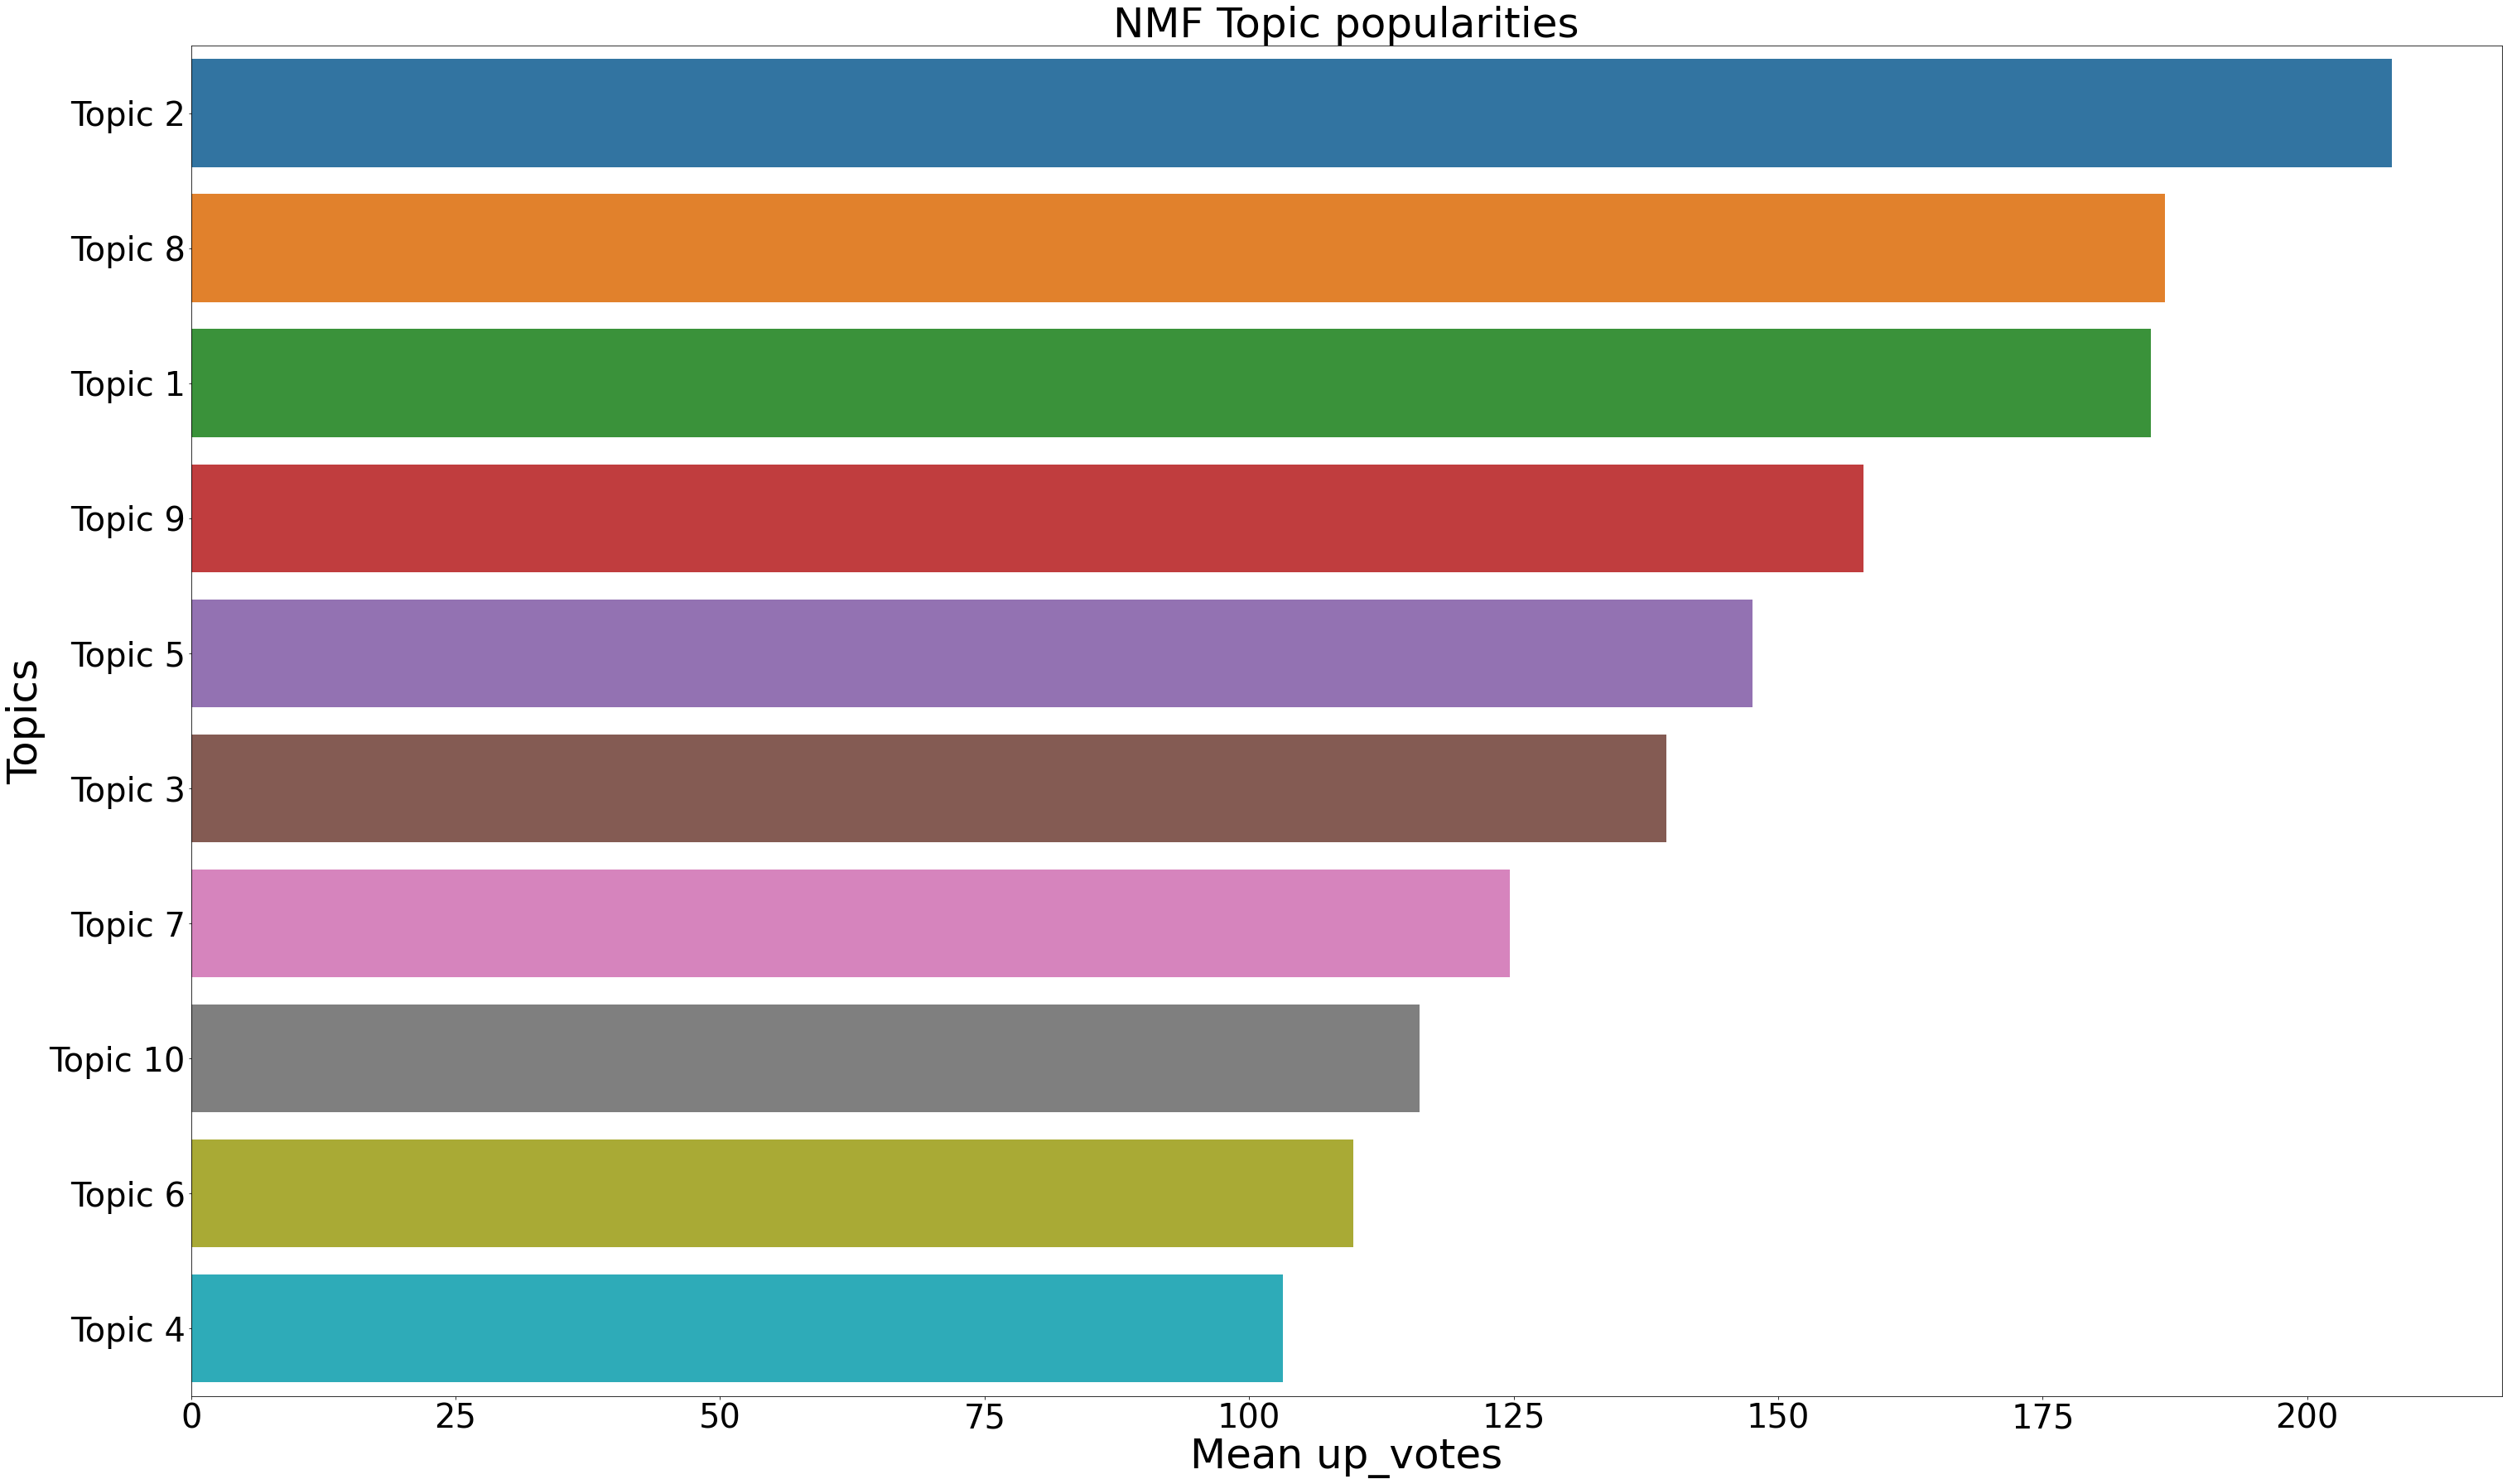

In [60]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2015,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2015', 2015)

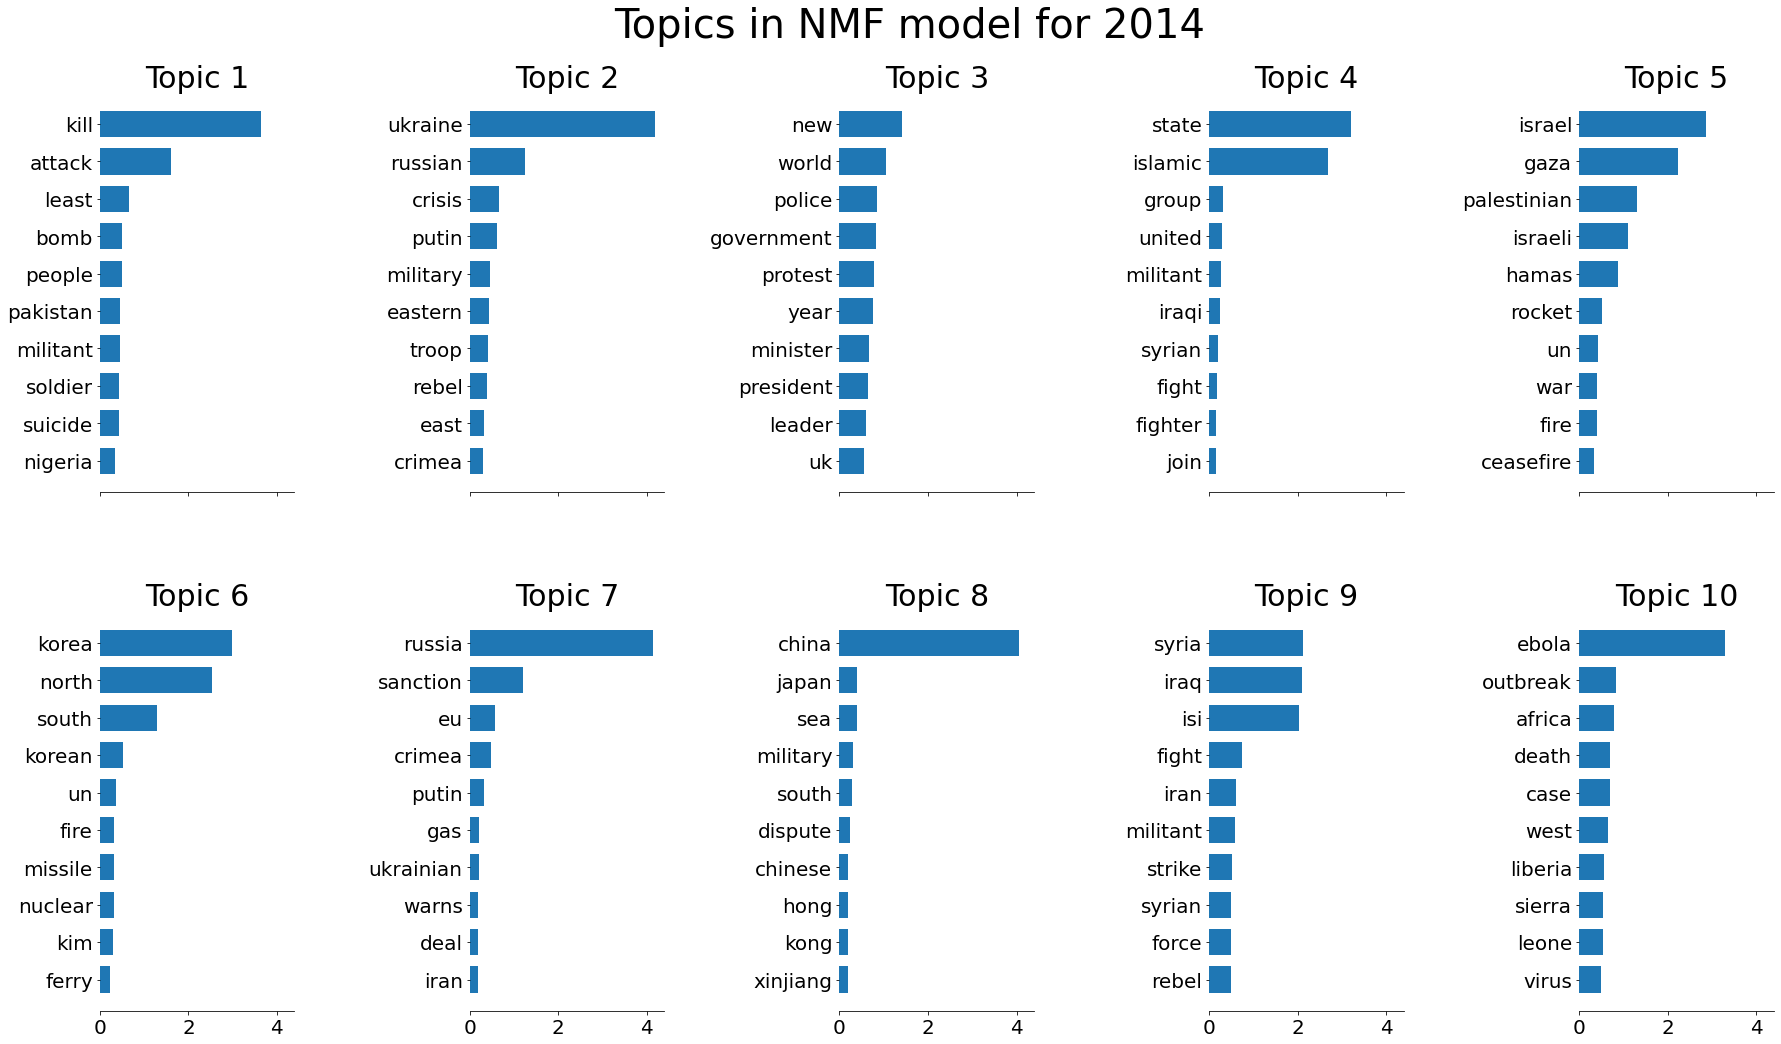

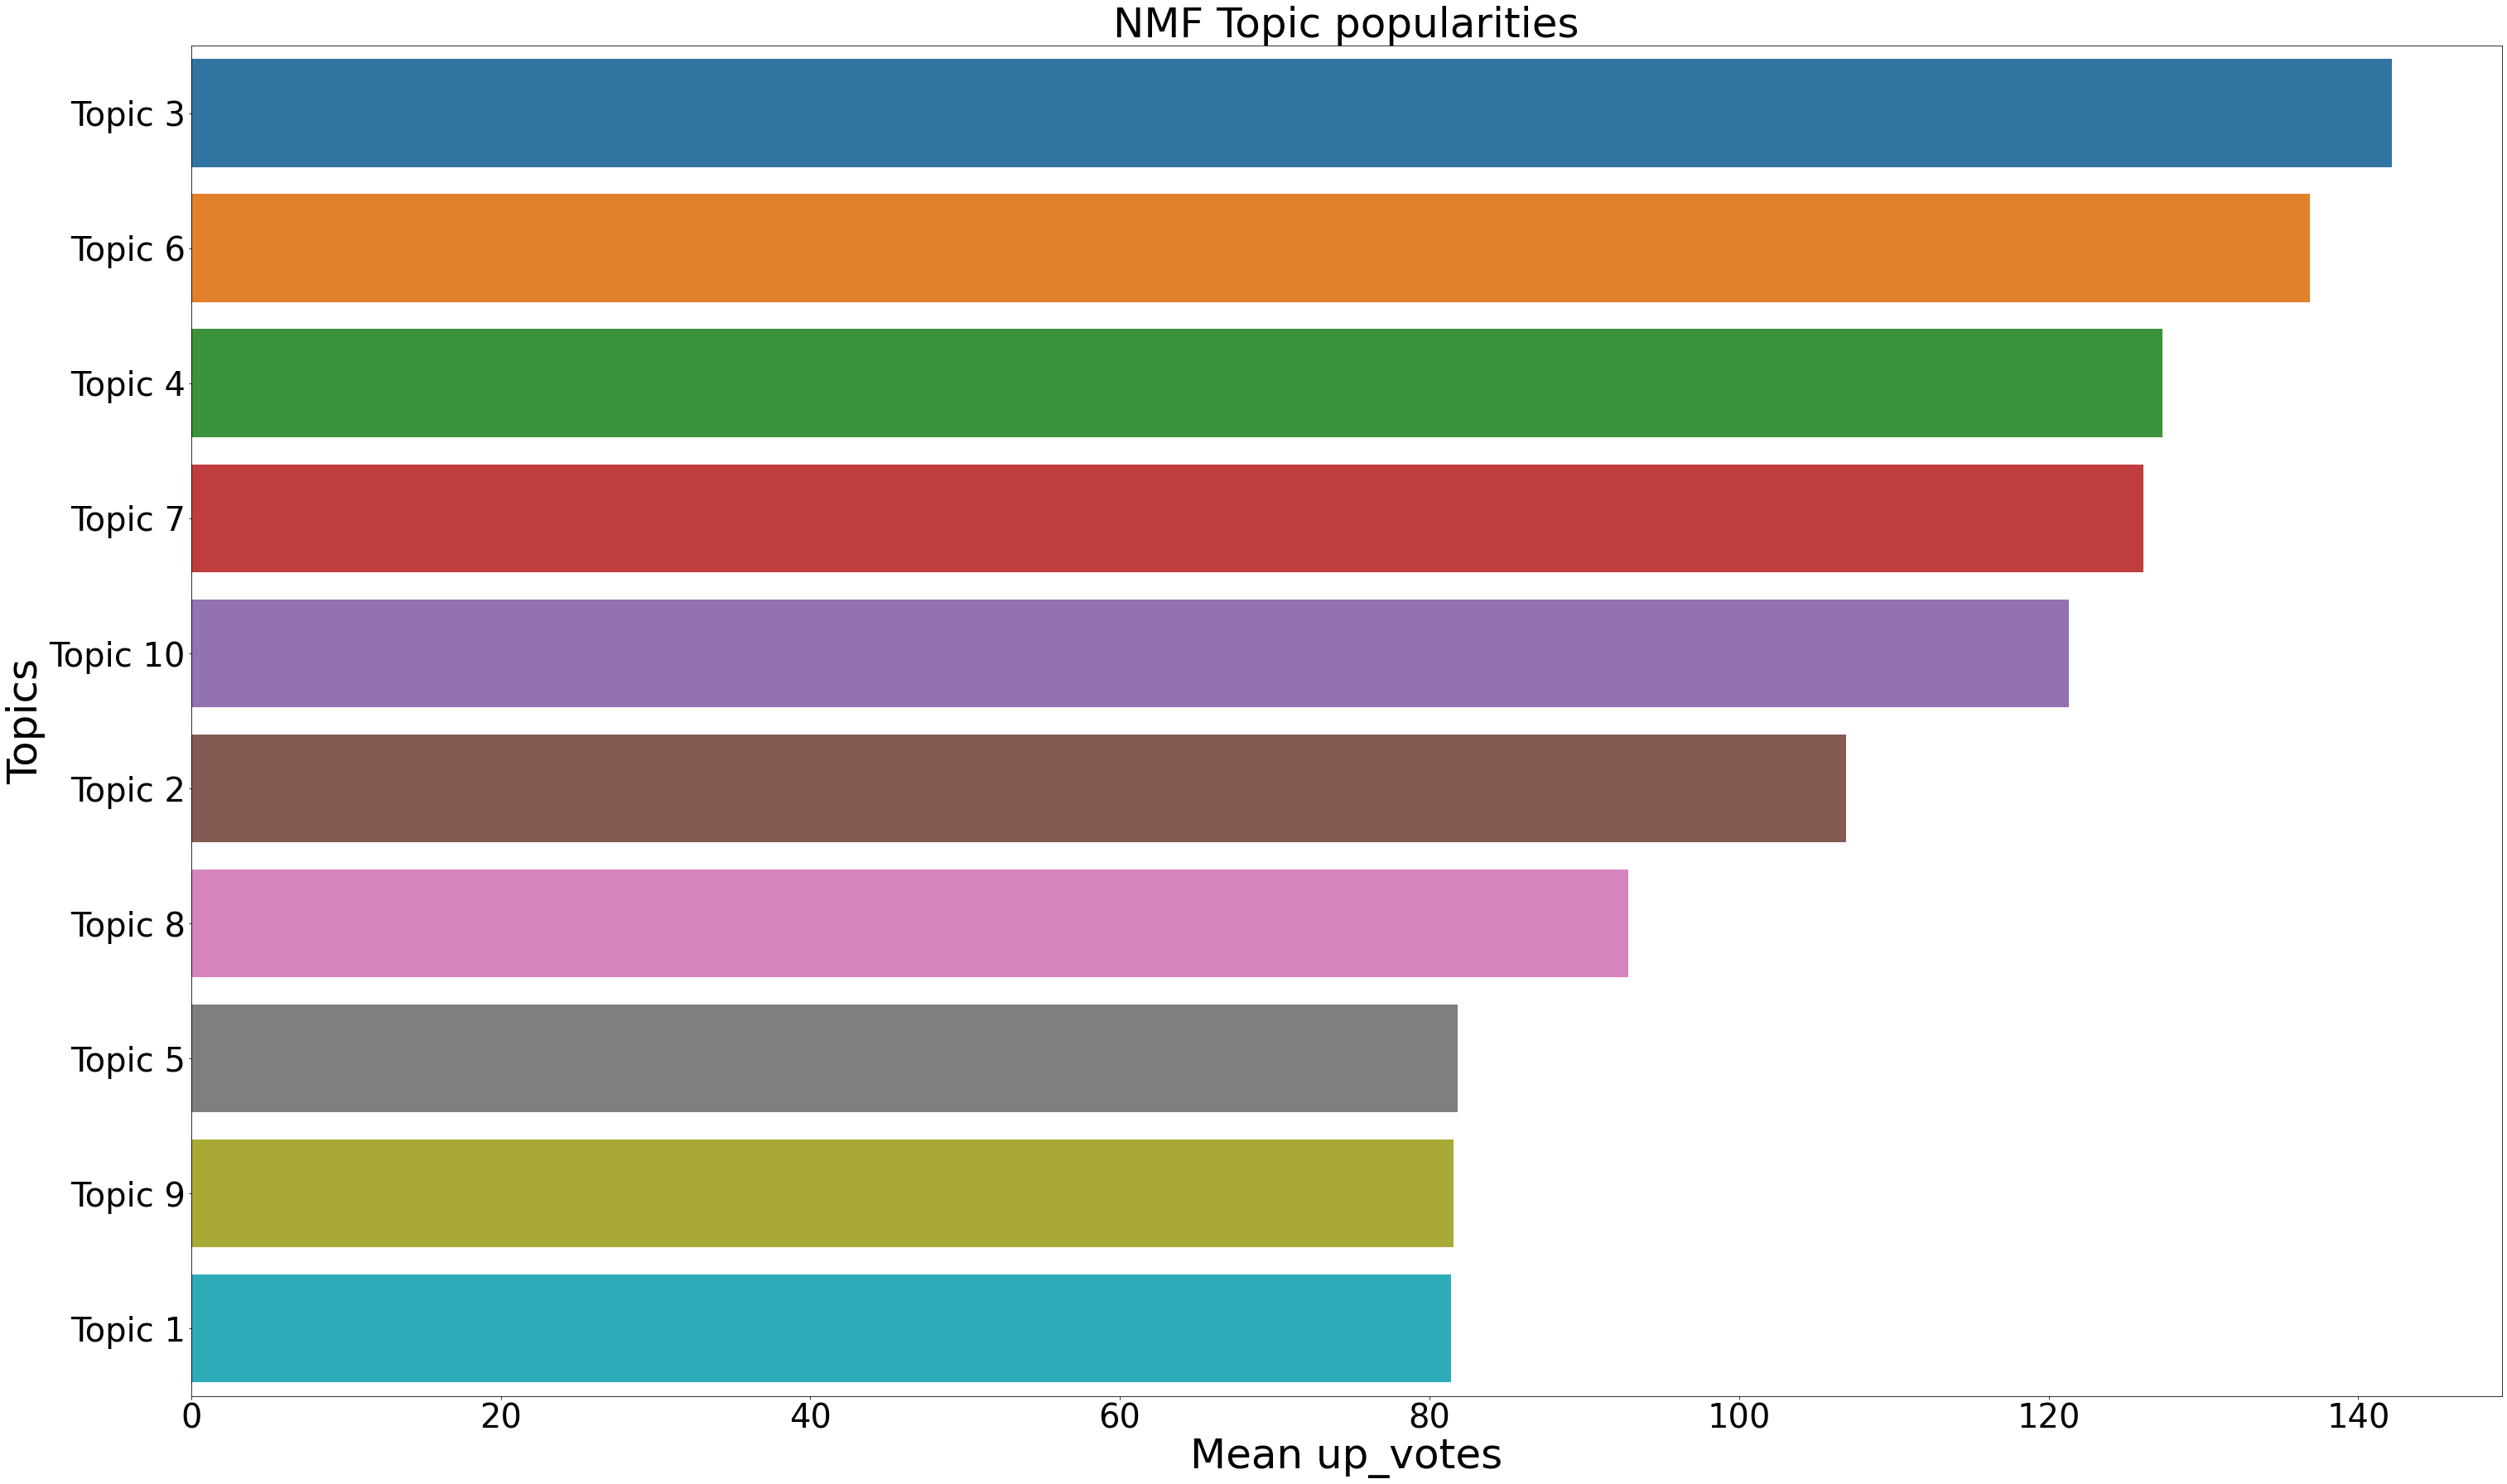

In [61]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2014,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2014', 2014)

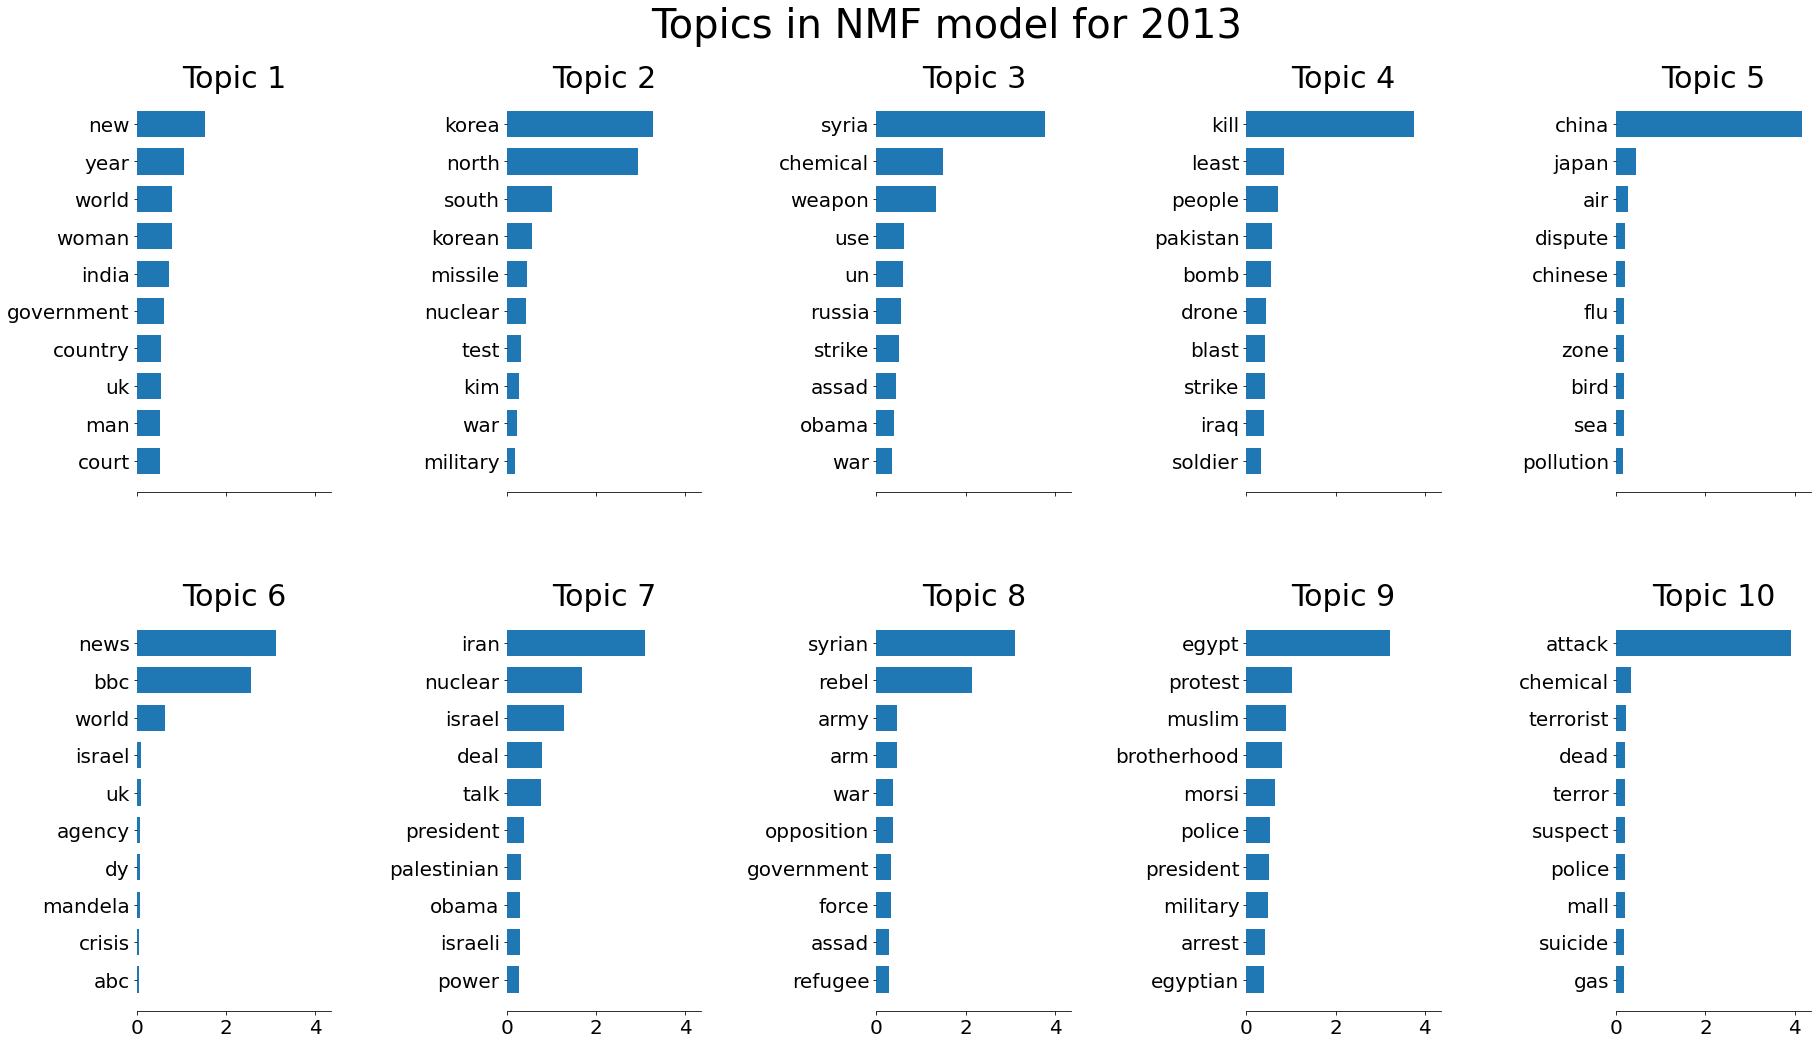

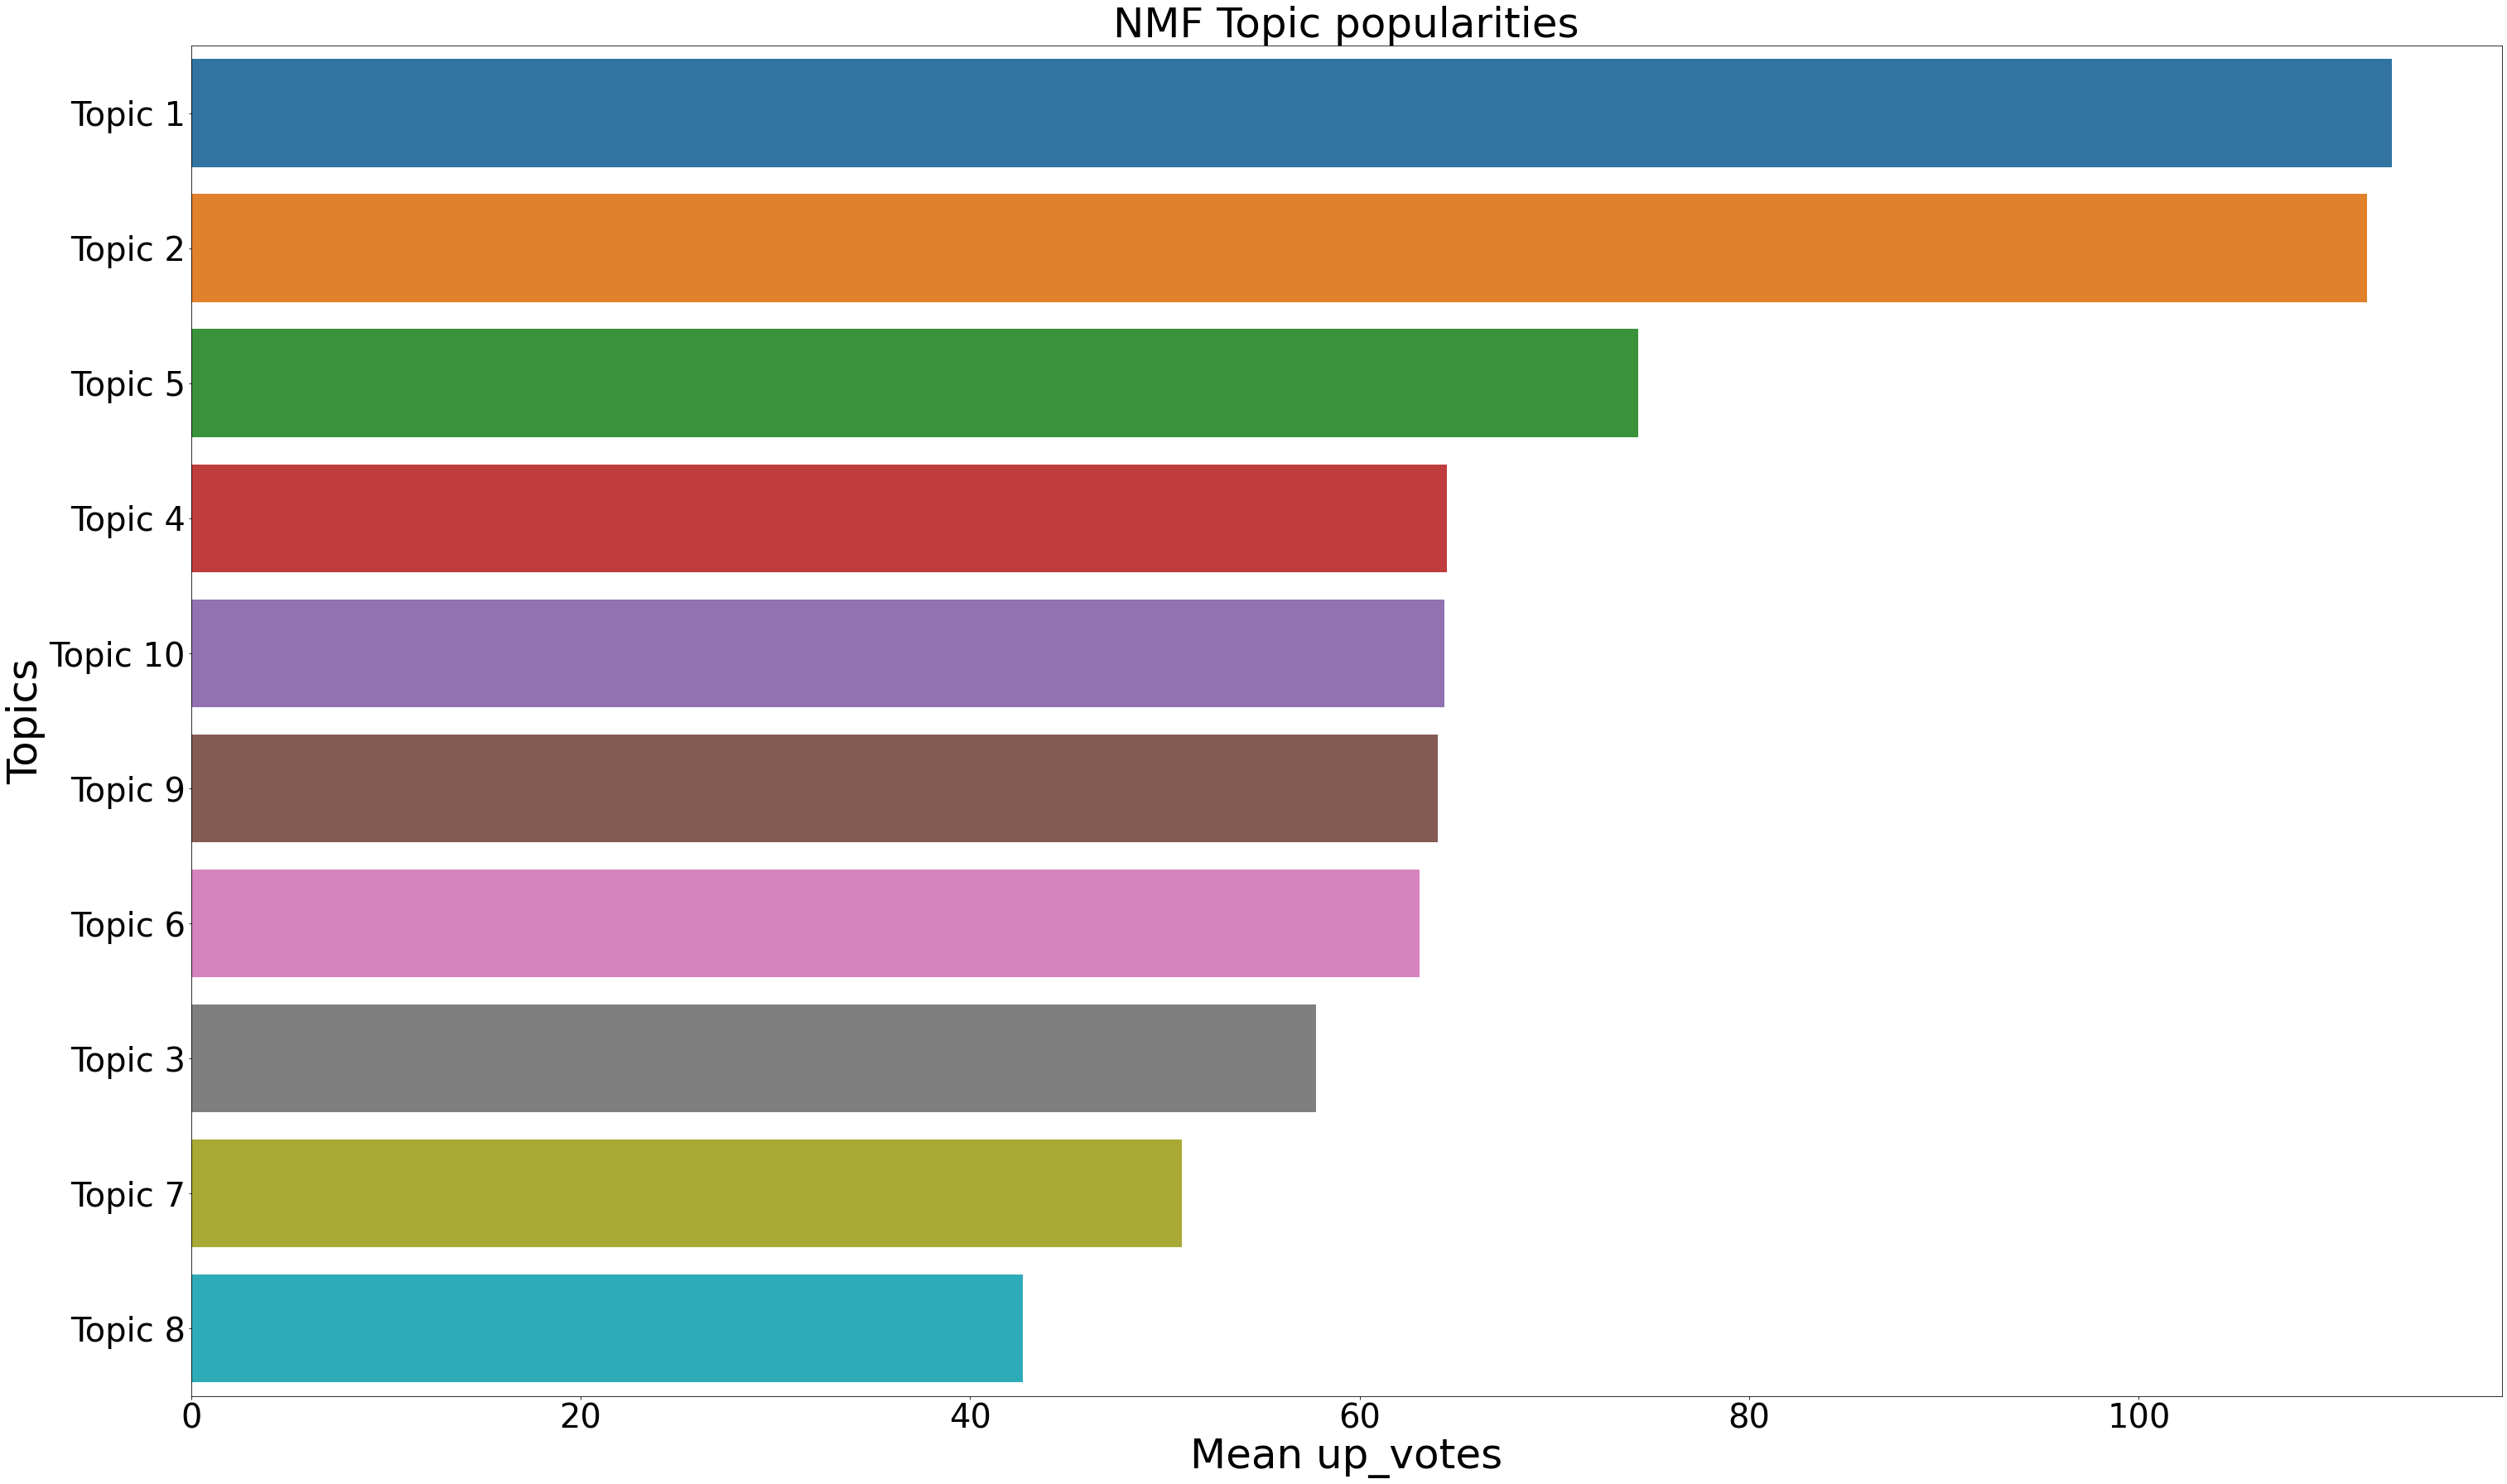

In [62]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2013,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2013', 2013)

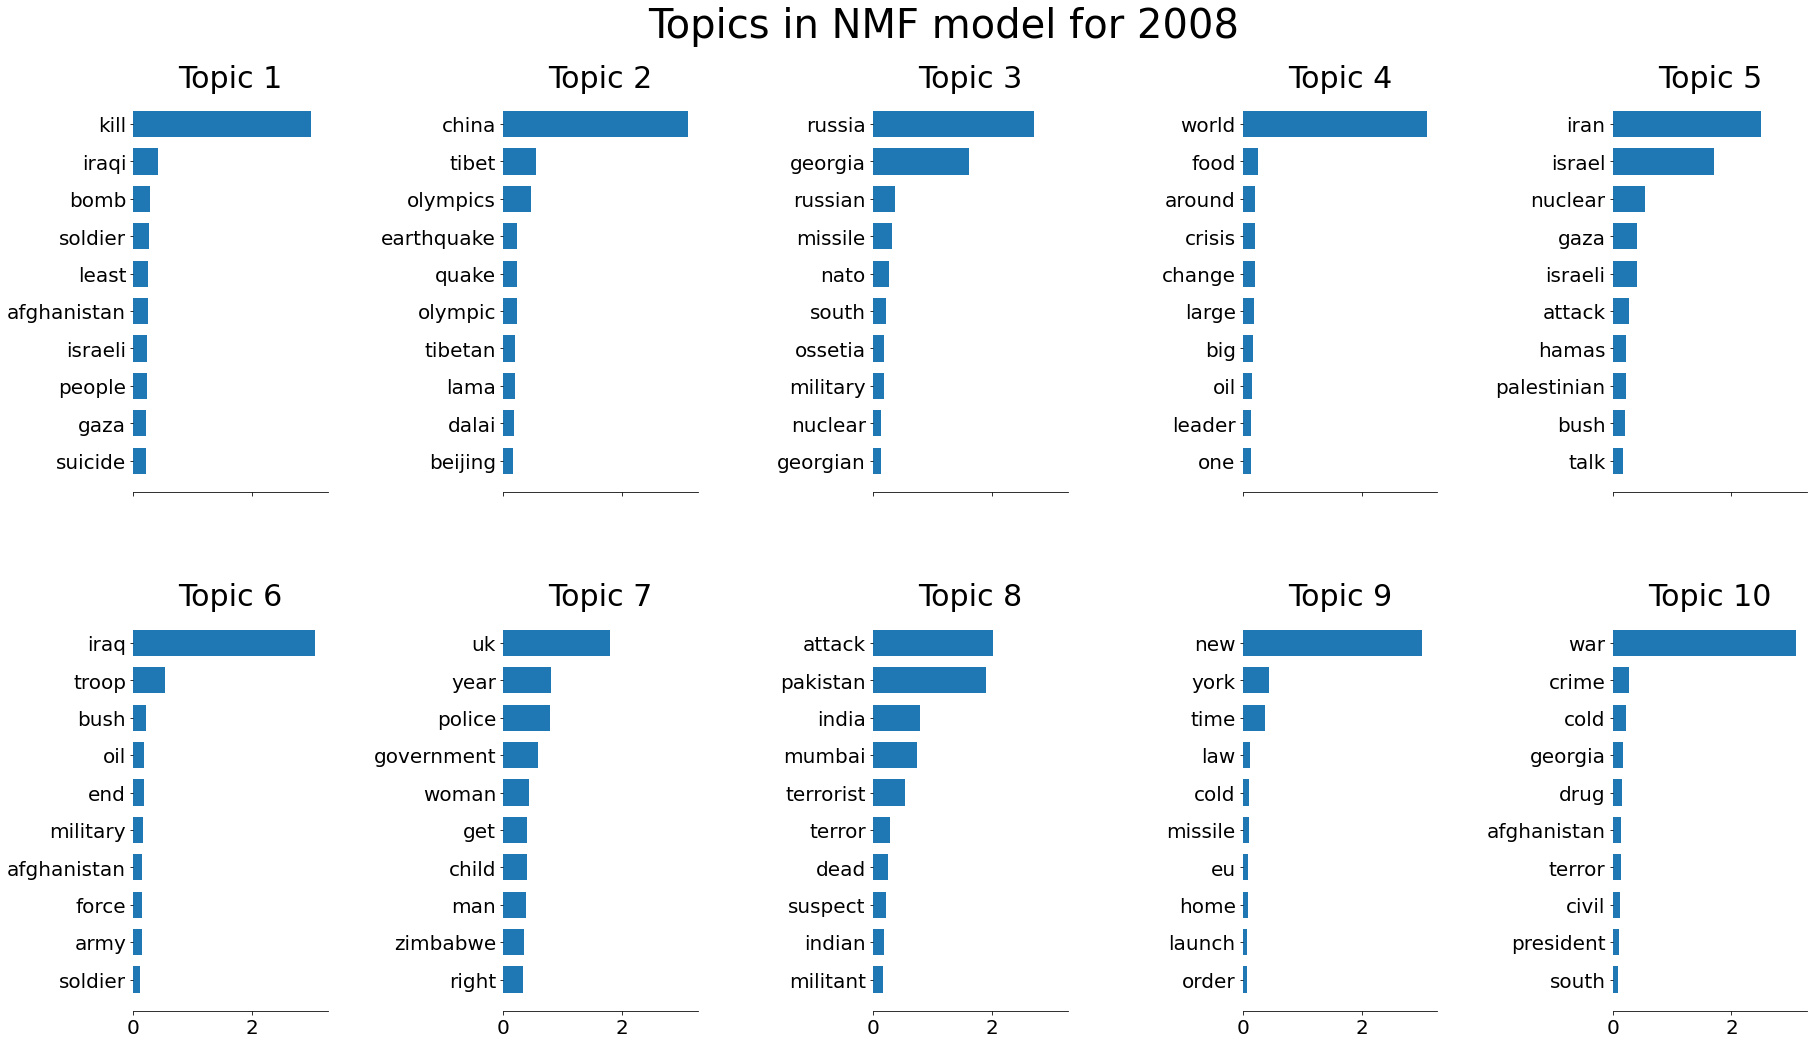

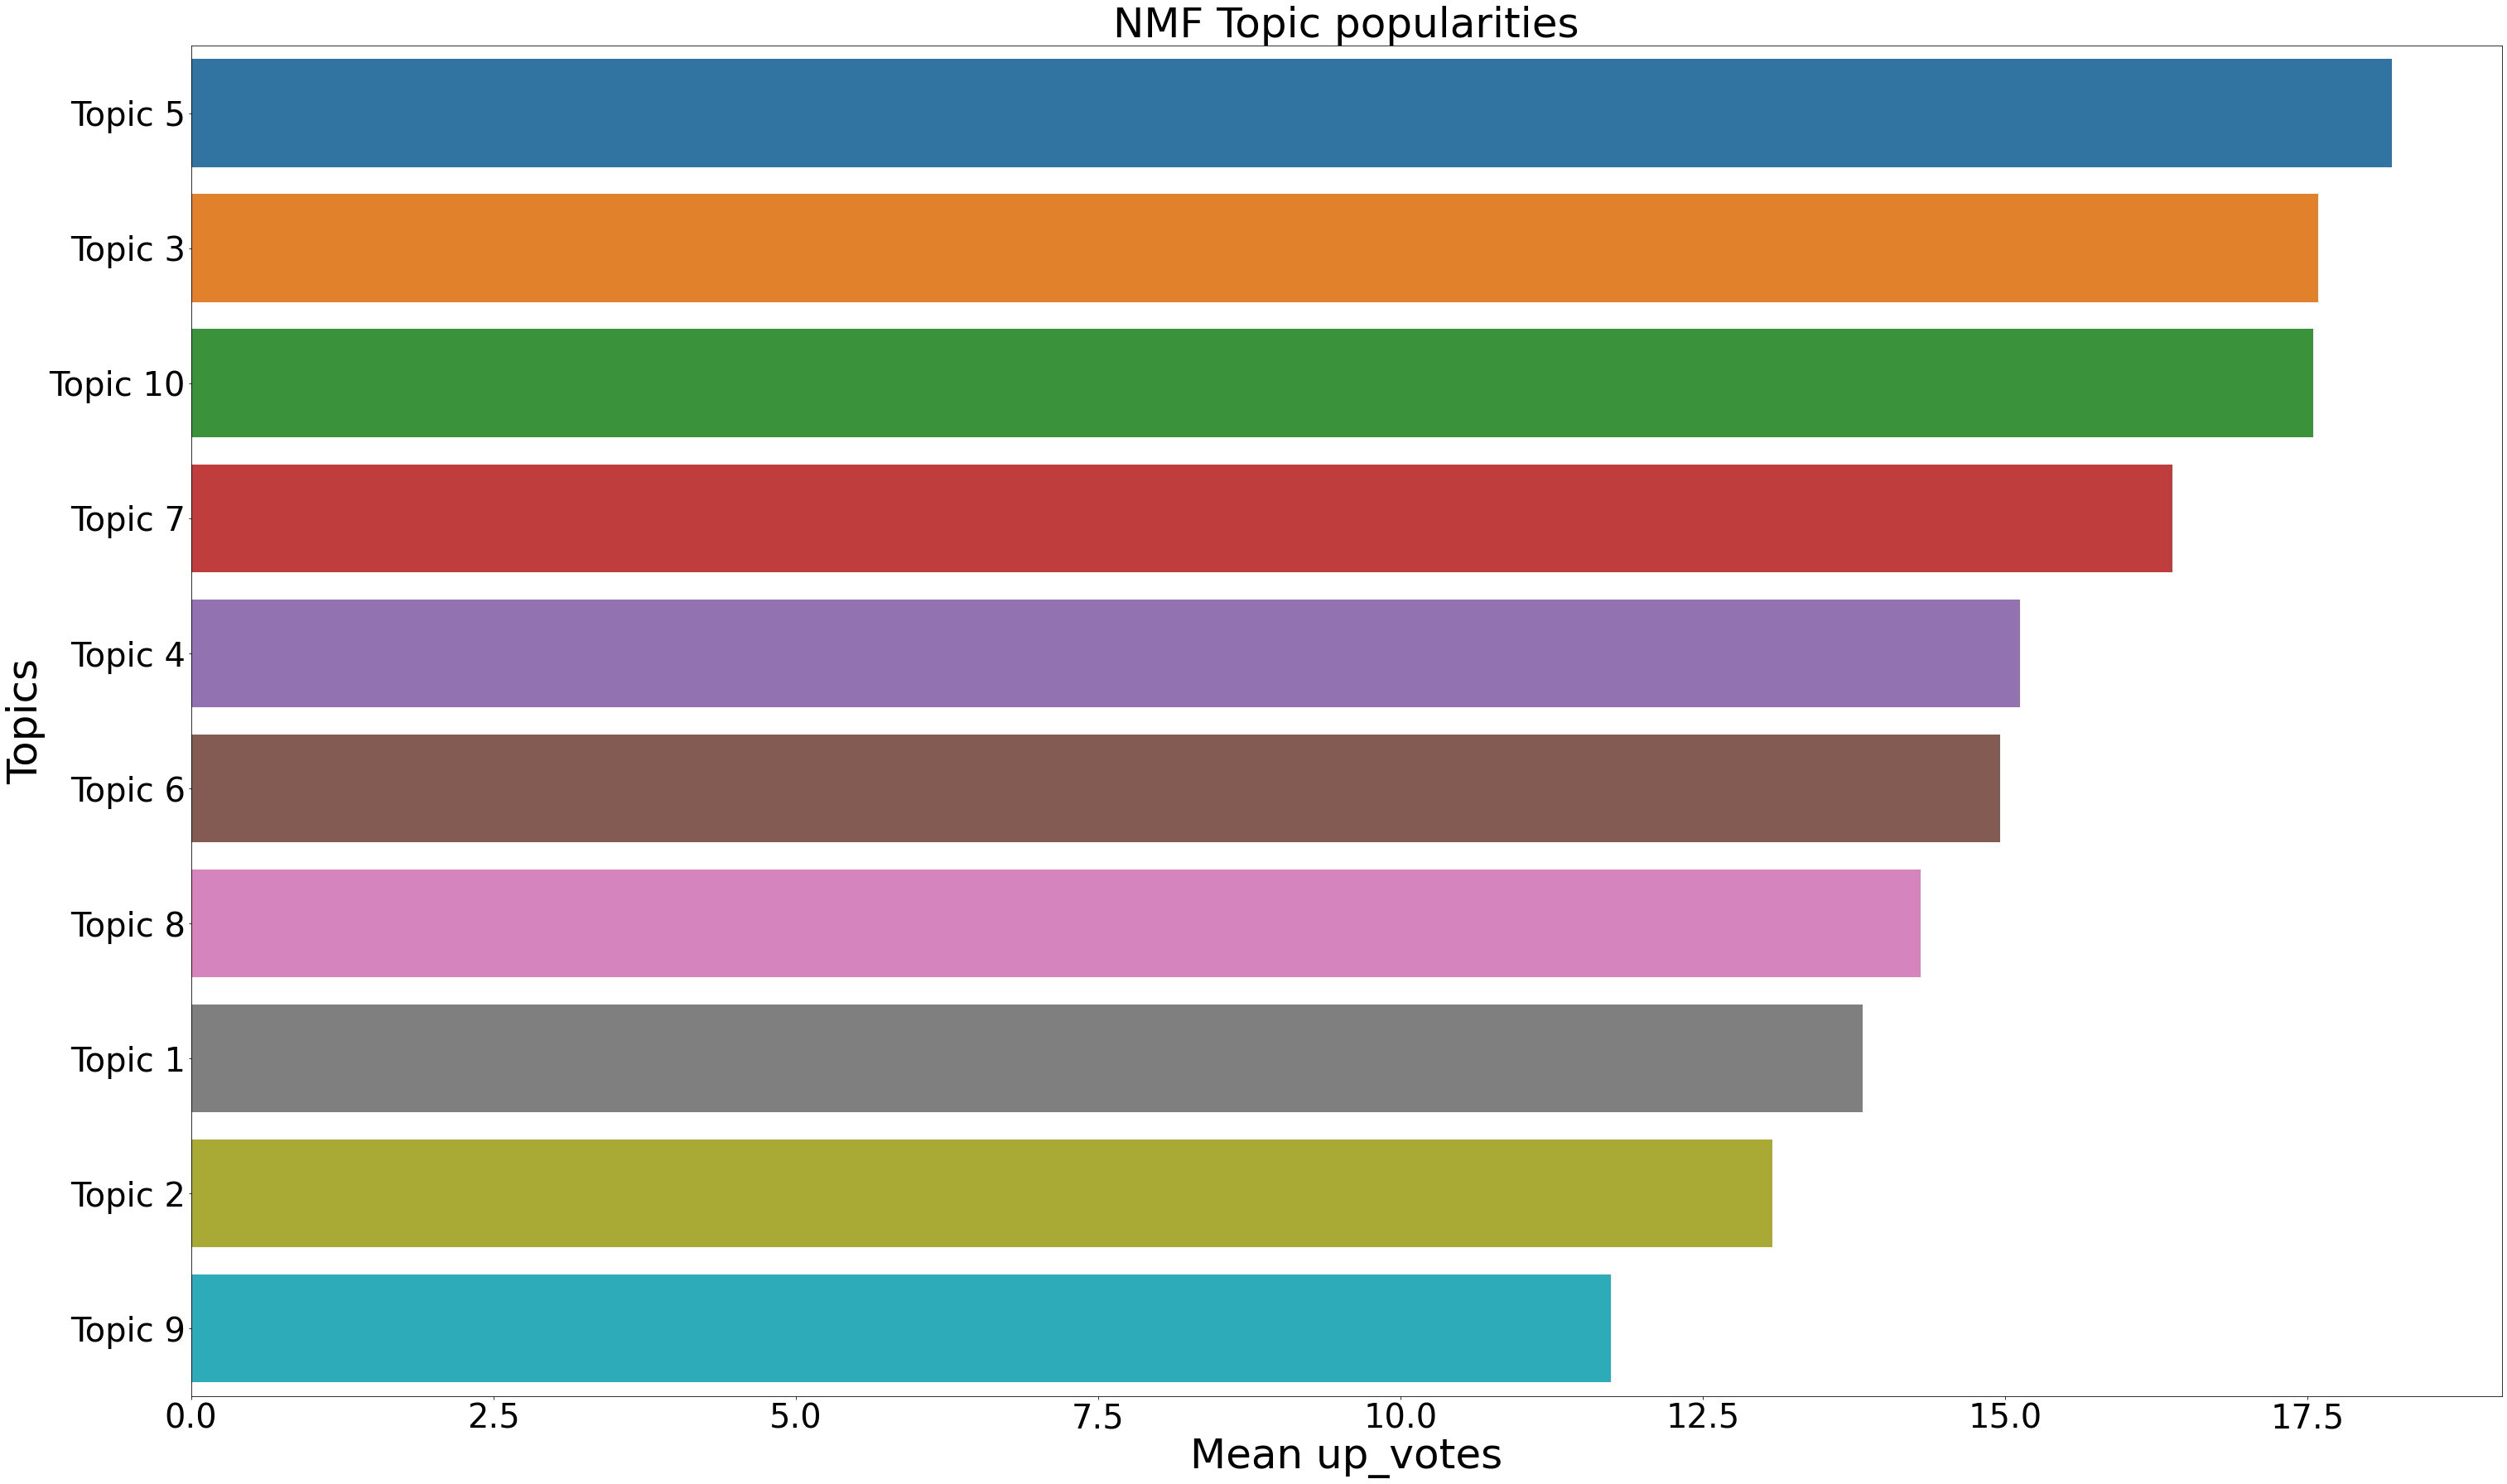

In [63]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000)
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2008,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2008', 2008)

## Can inclusion of bi-grams tell us something different?

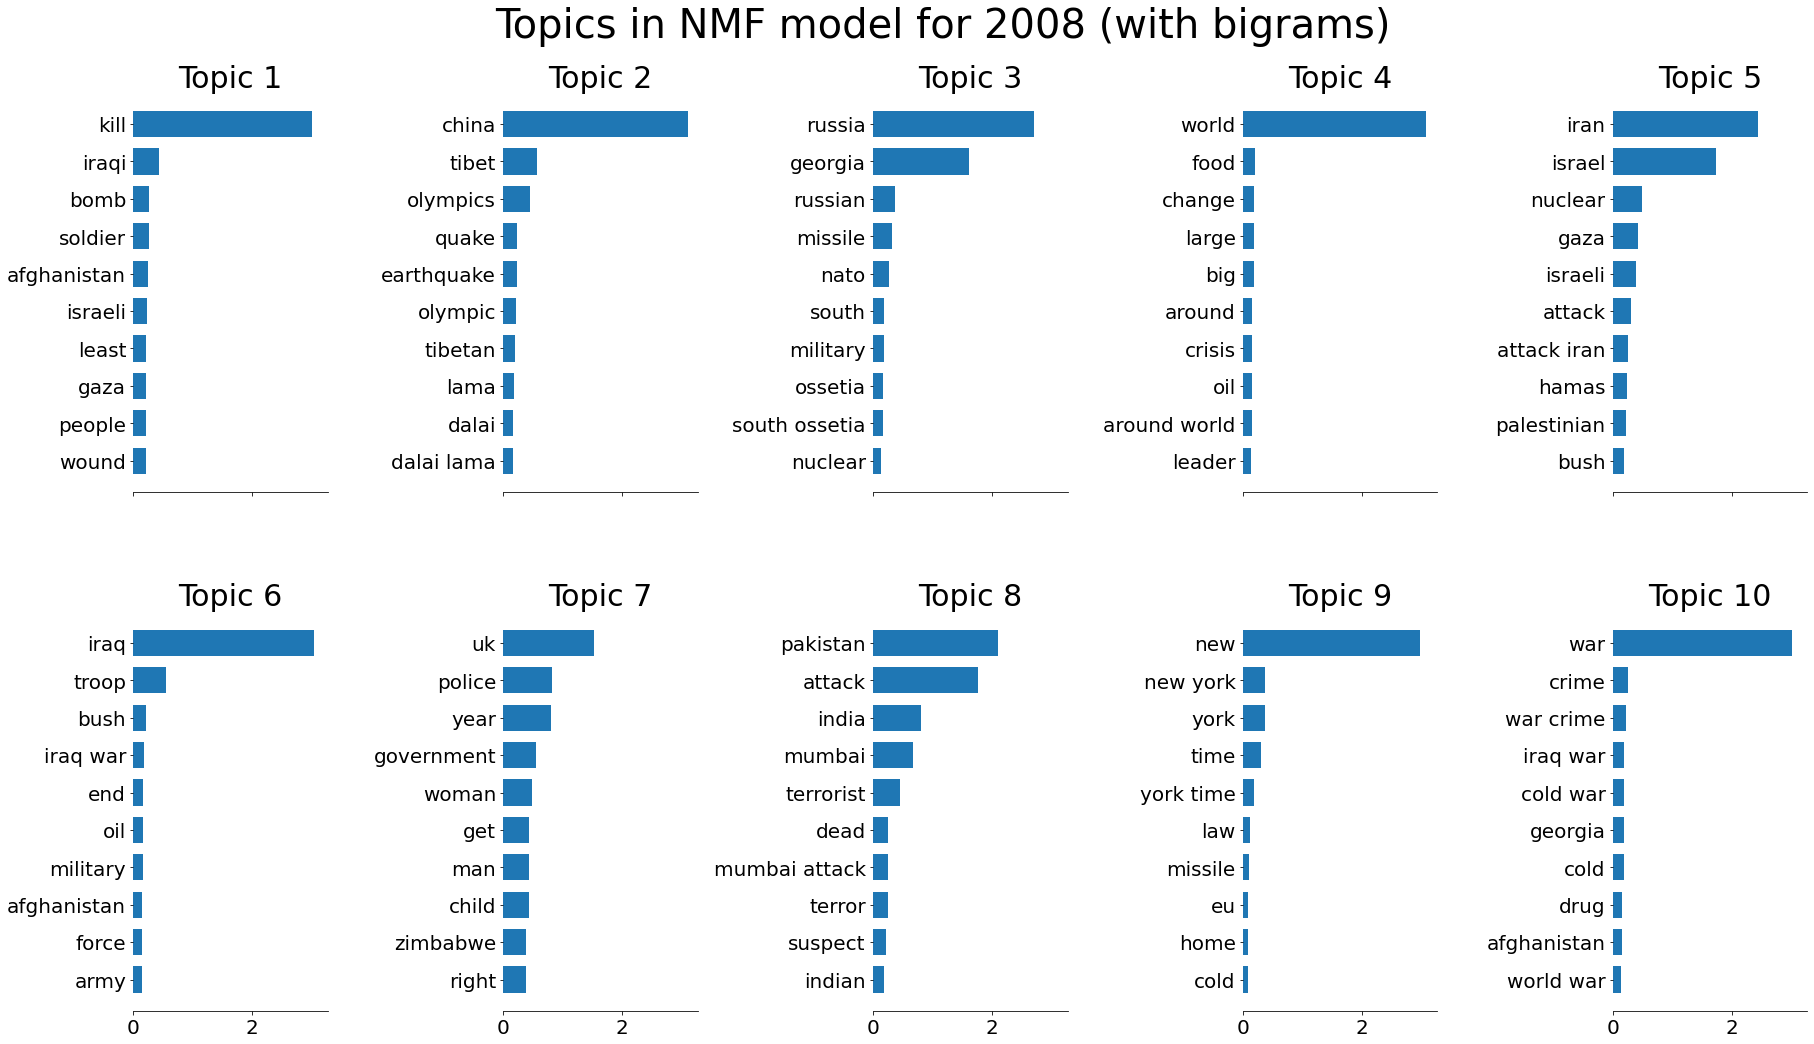

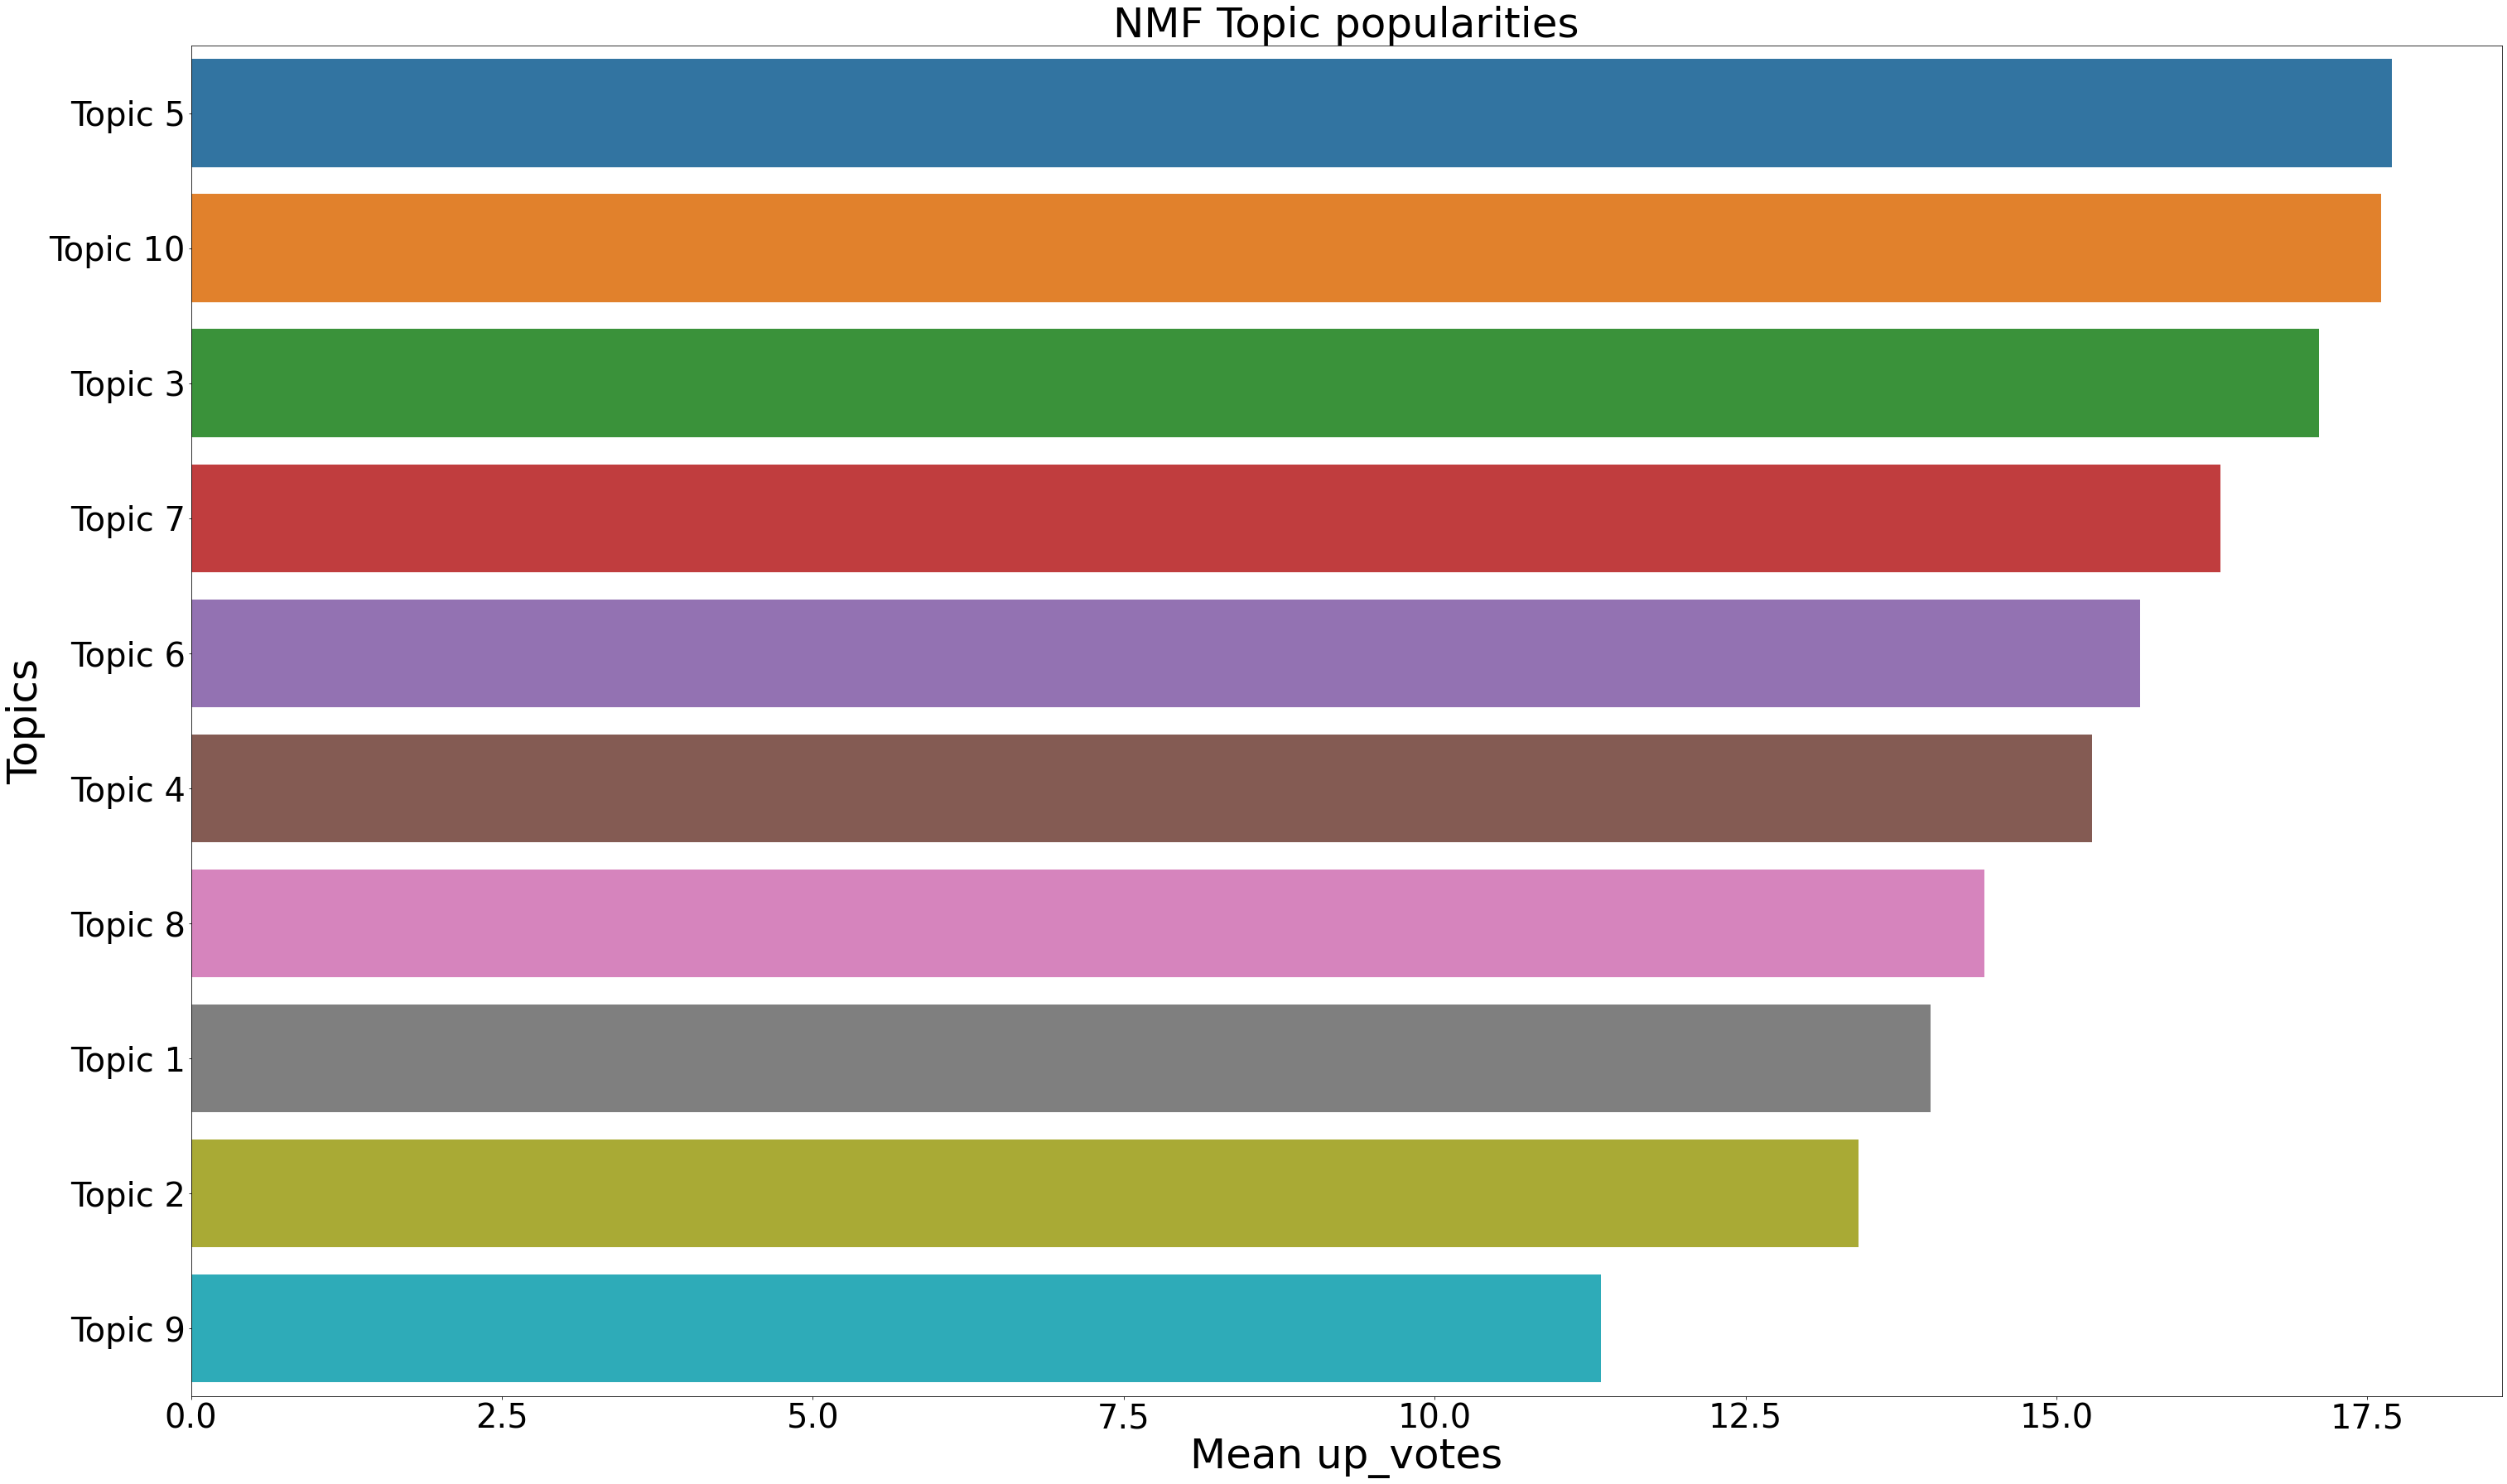

In [64]:
# Let's take a look at 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2008,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=500).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2008 (with bigrams)', 2008)

**There are some changes in the popularity even though the topics are largely the same.**

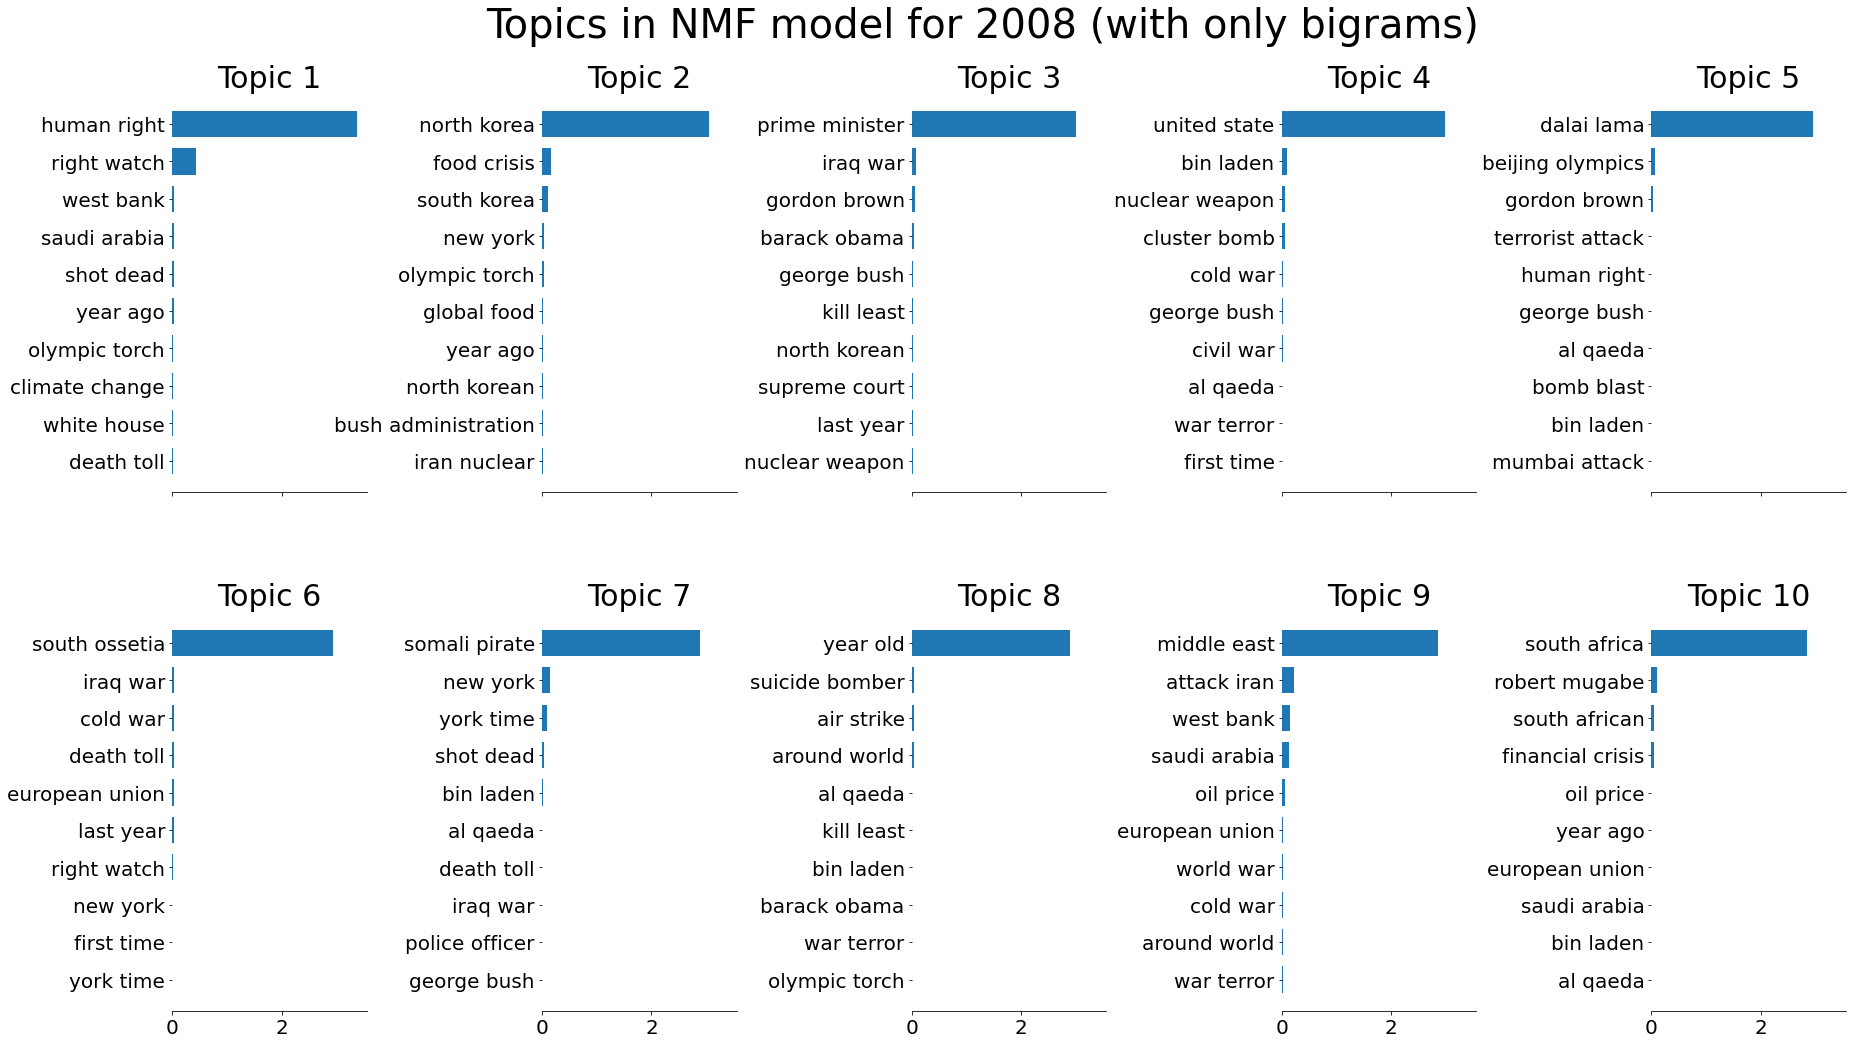

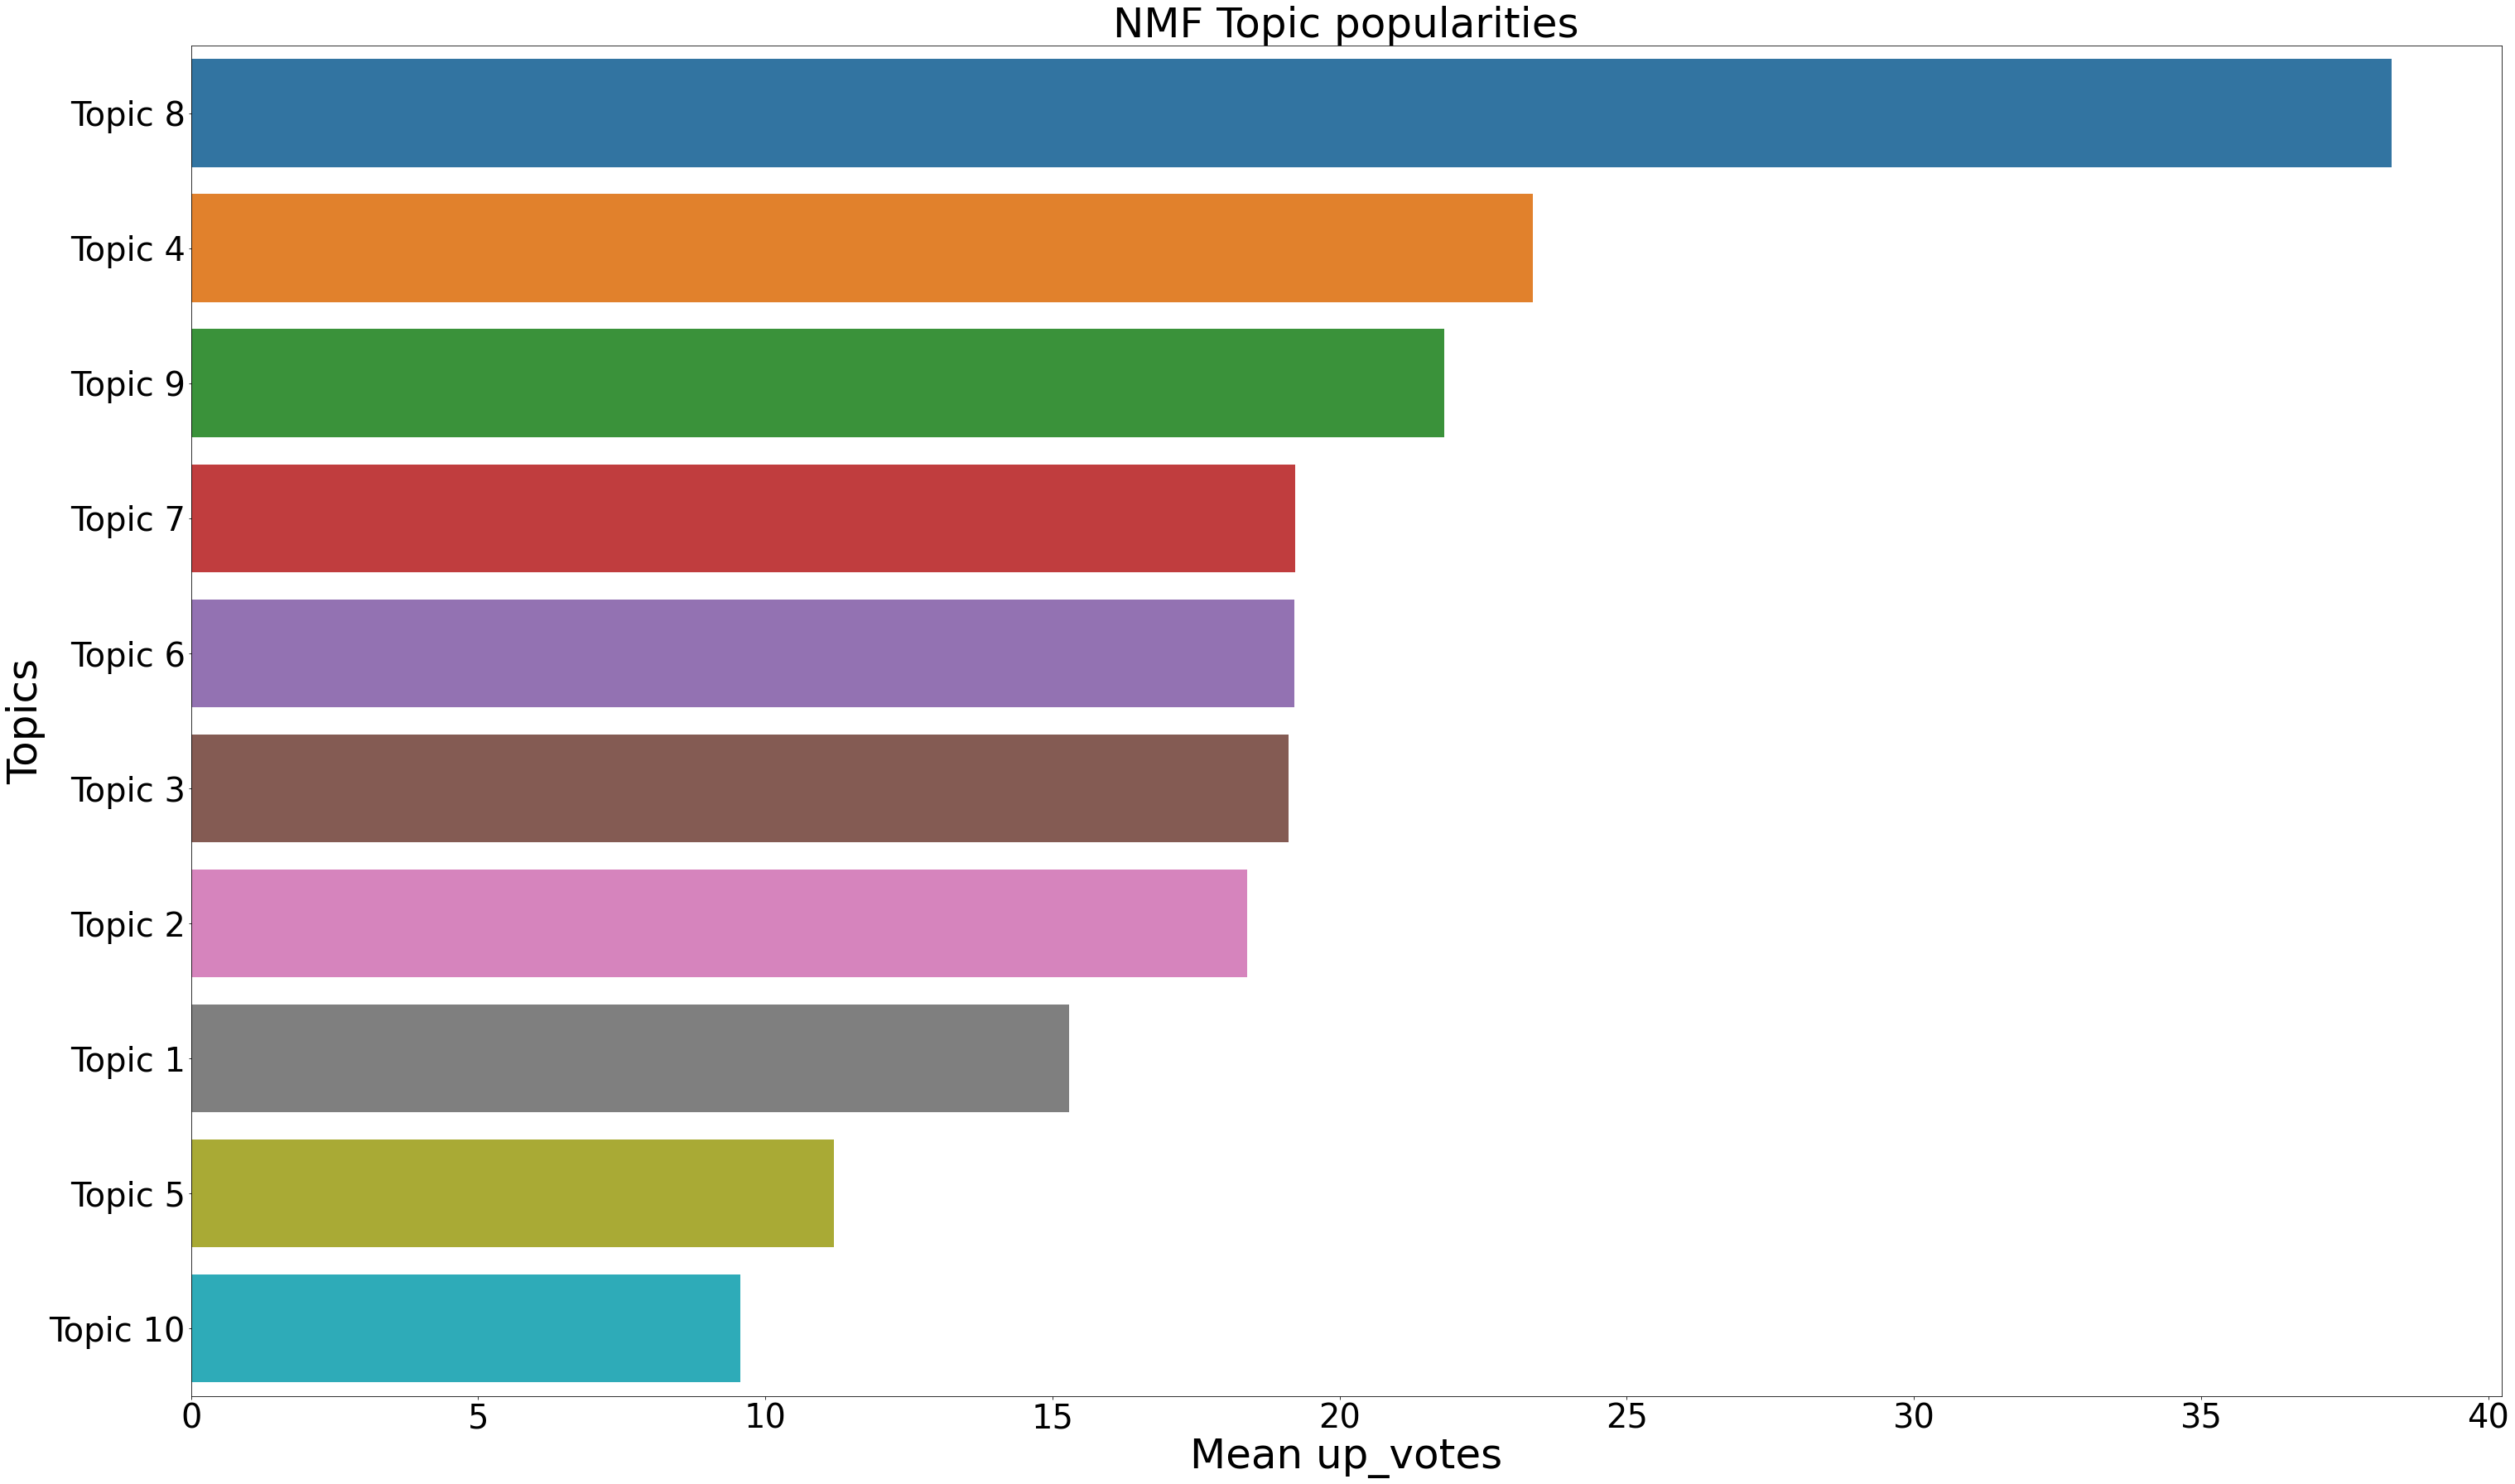

In [65]:
# Let's look at the popular bigrams only from 2008

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2008,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2008 (with only bigrams)', 2008)

The way in which this is significantly different is that there aren't that many bigrams. Hence we see the bigram weights vanish almost immediately in a topic. Also bigrams tell a lot more about the topics than the unigrams on their own. For example somali and pirate occuring together clarifies the topic further. Similarly 'middle east', 'beijing olympics'. 

**Let's look at a more recent year - 2016**

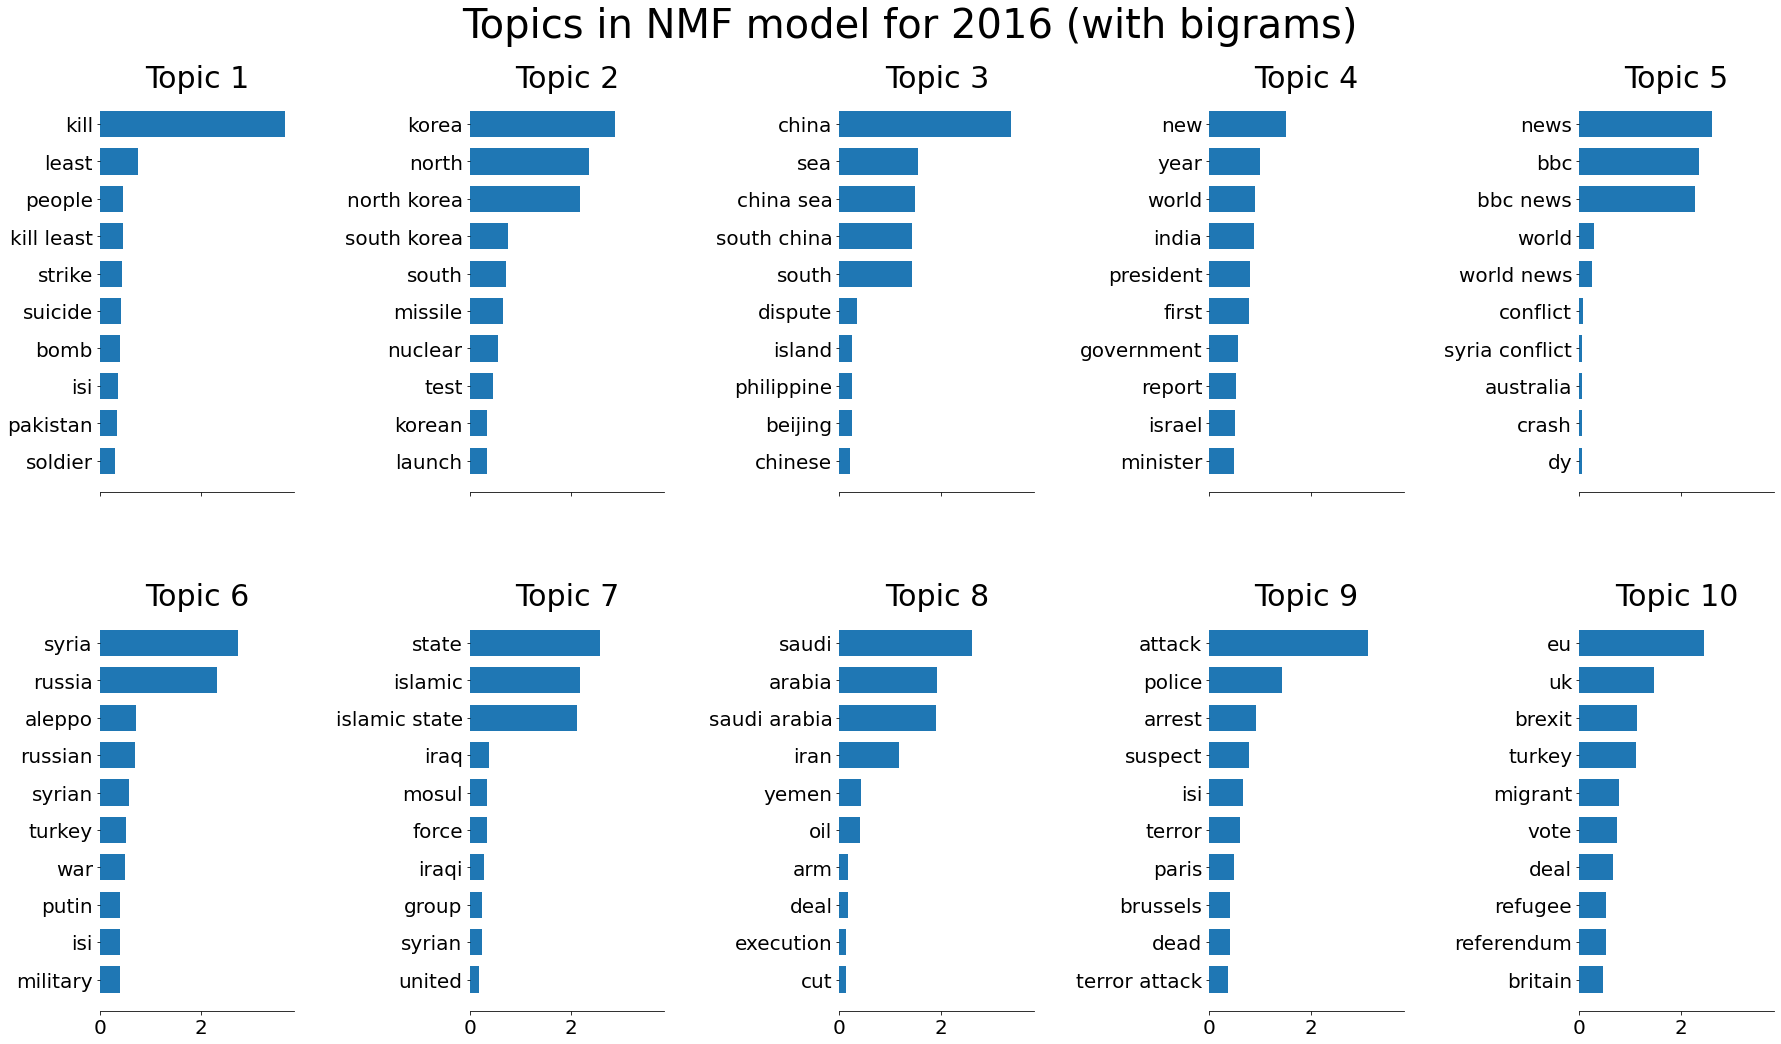

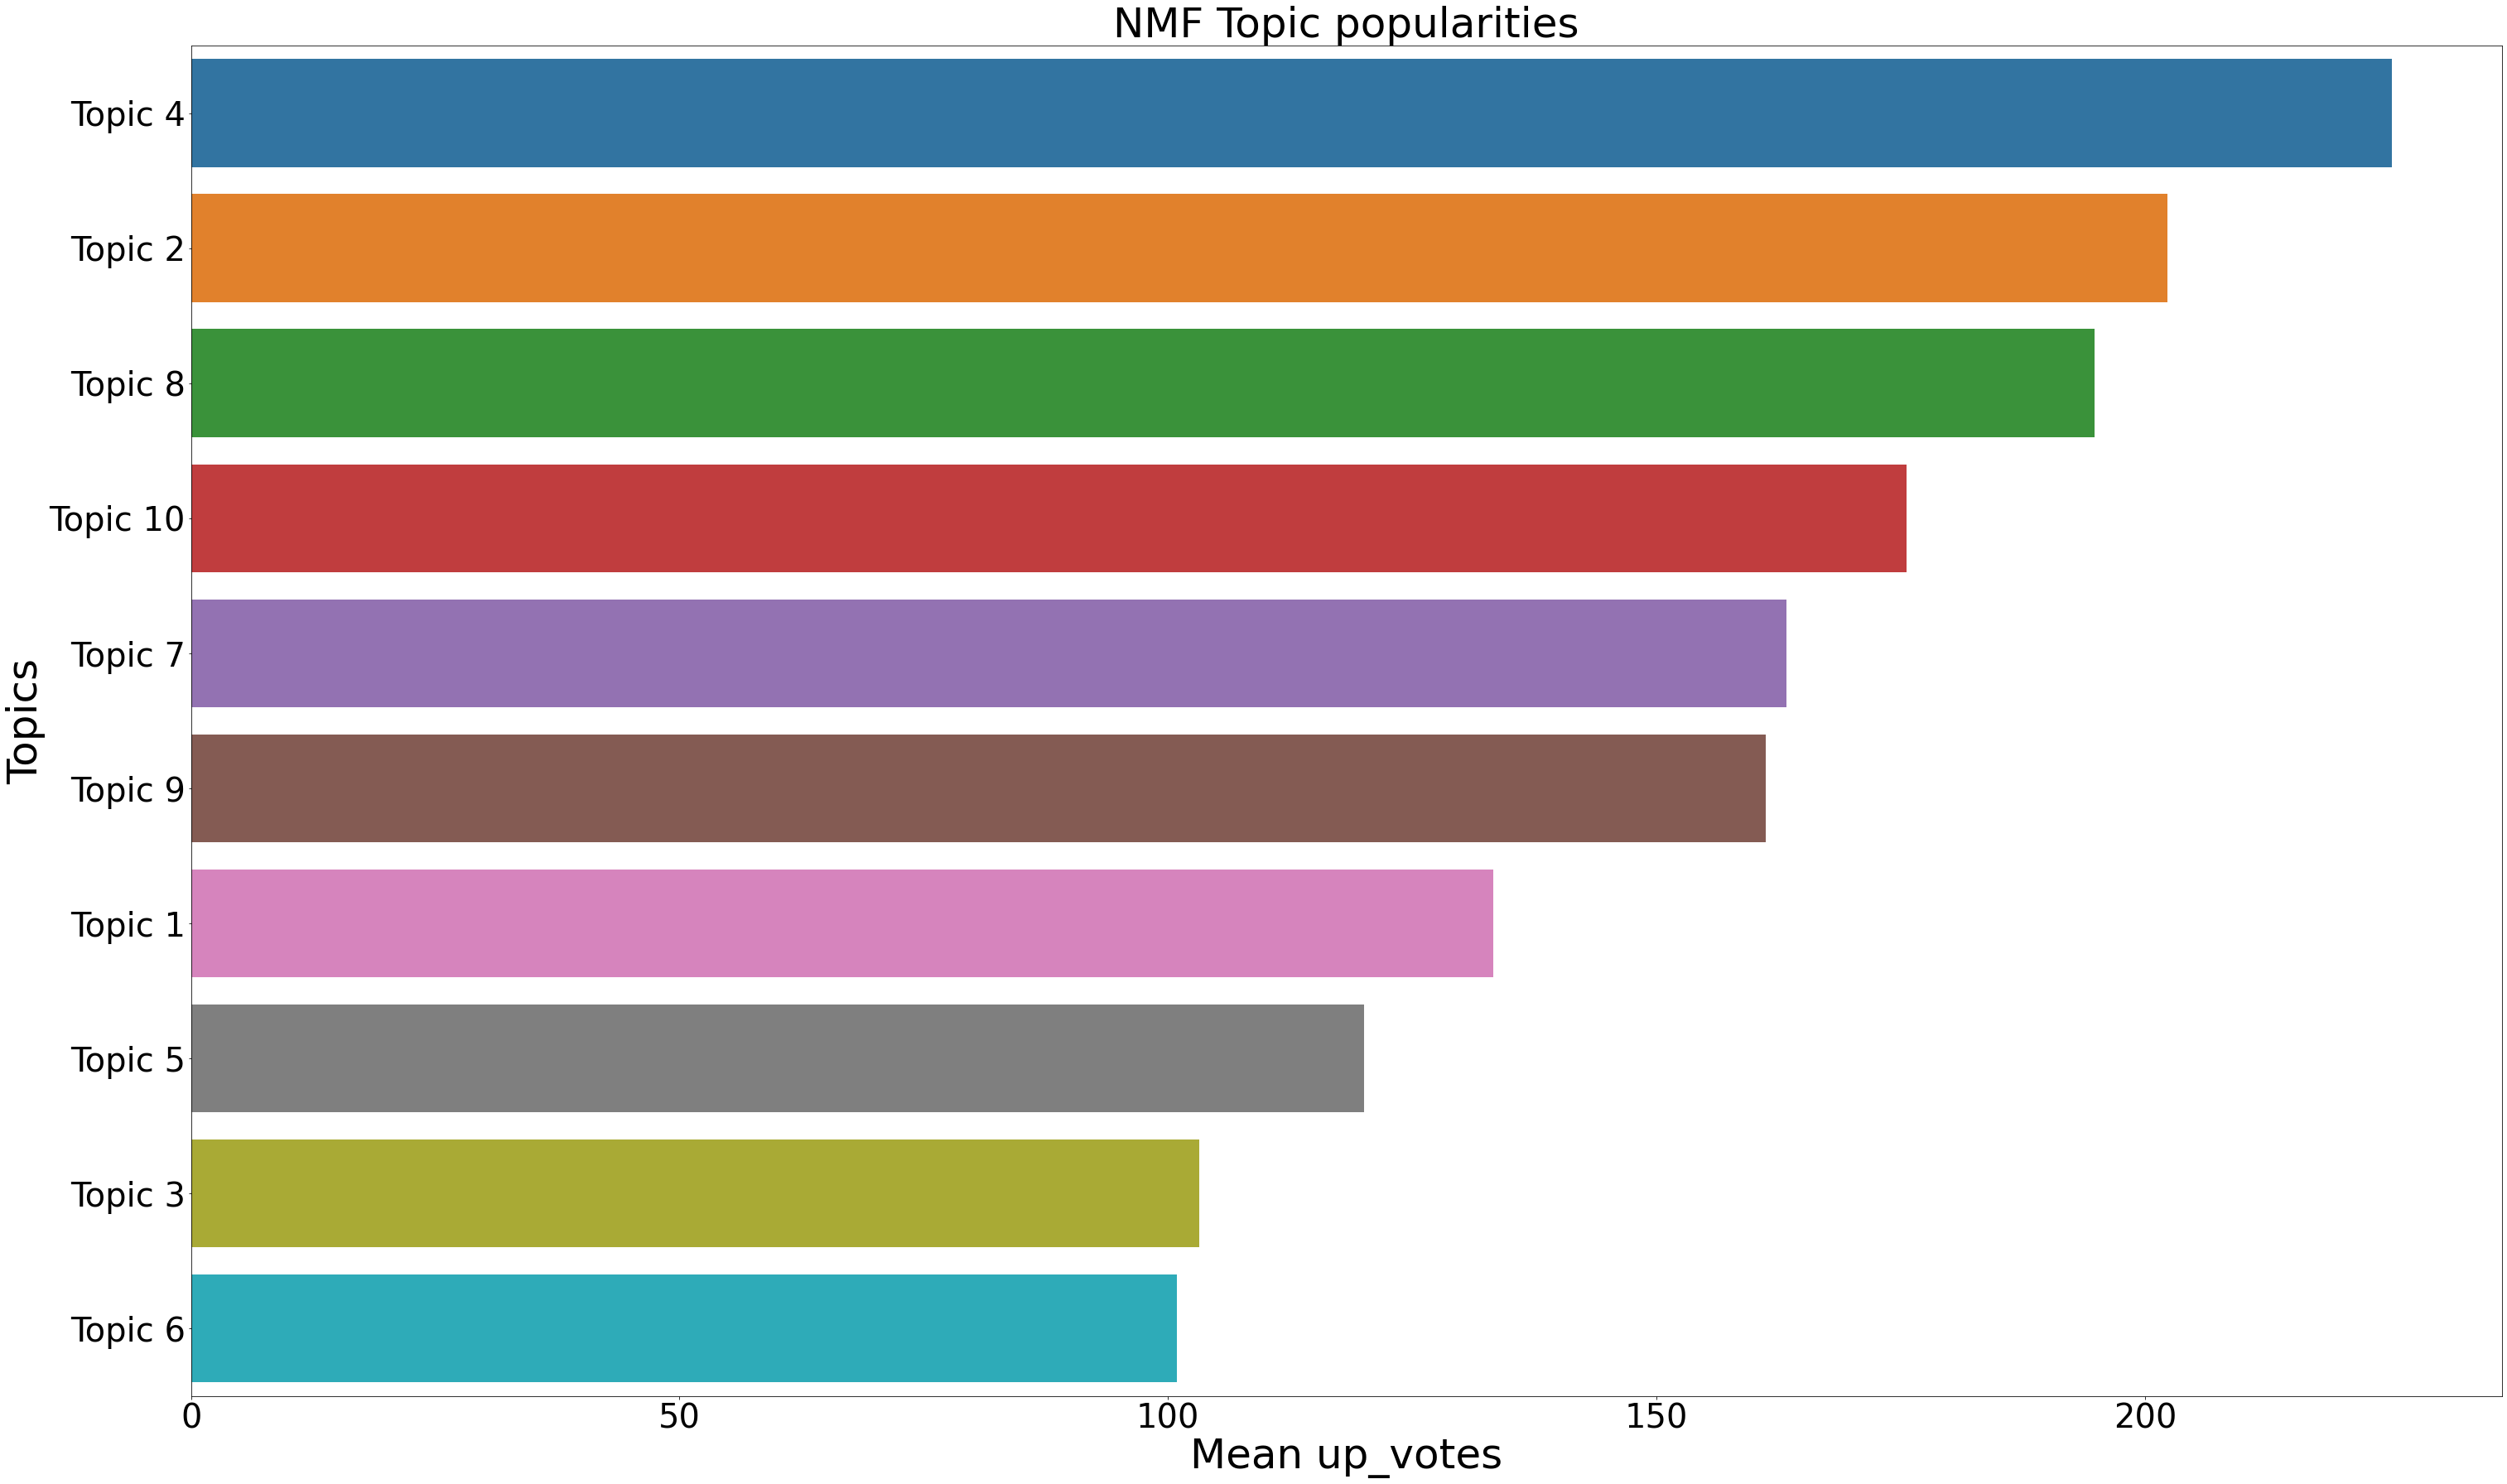

In [66]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2016,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2016 (with bigrams)', 2016)

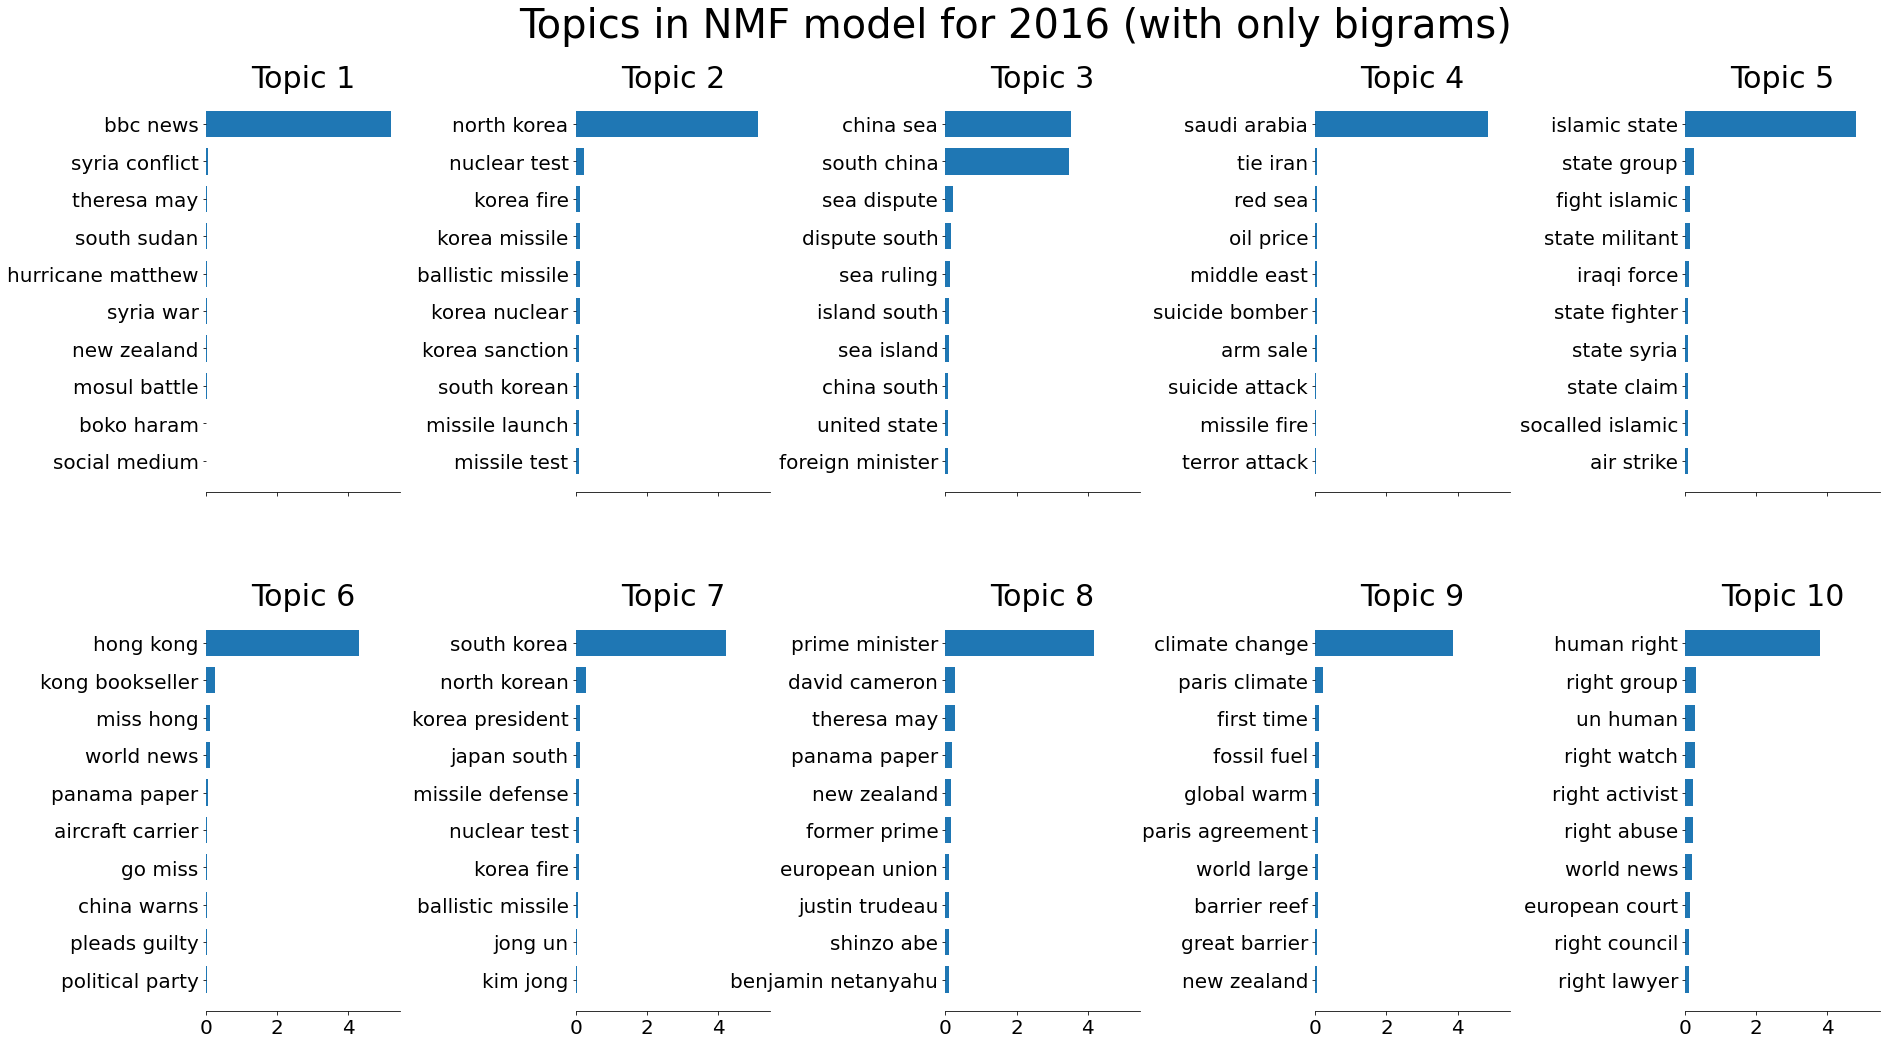

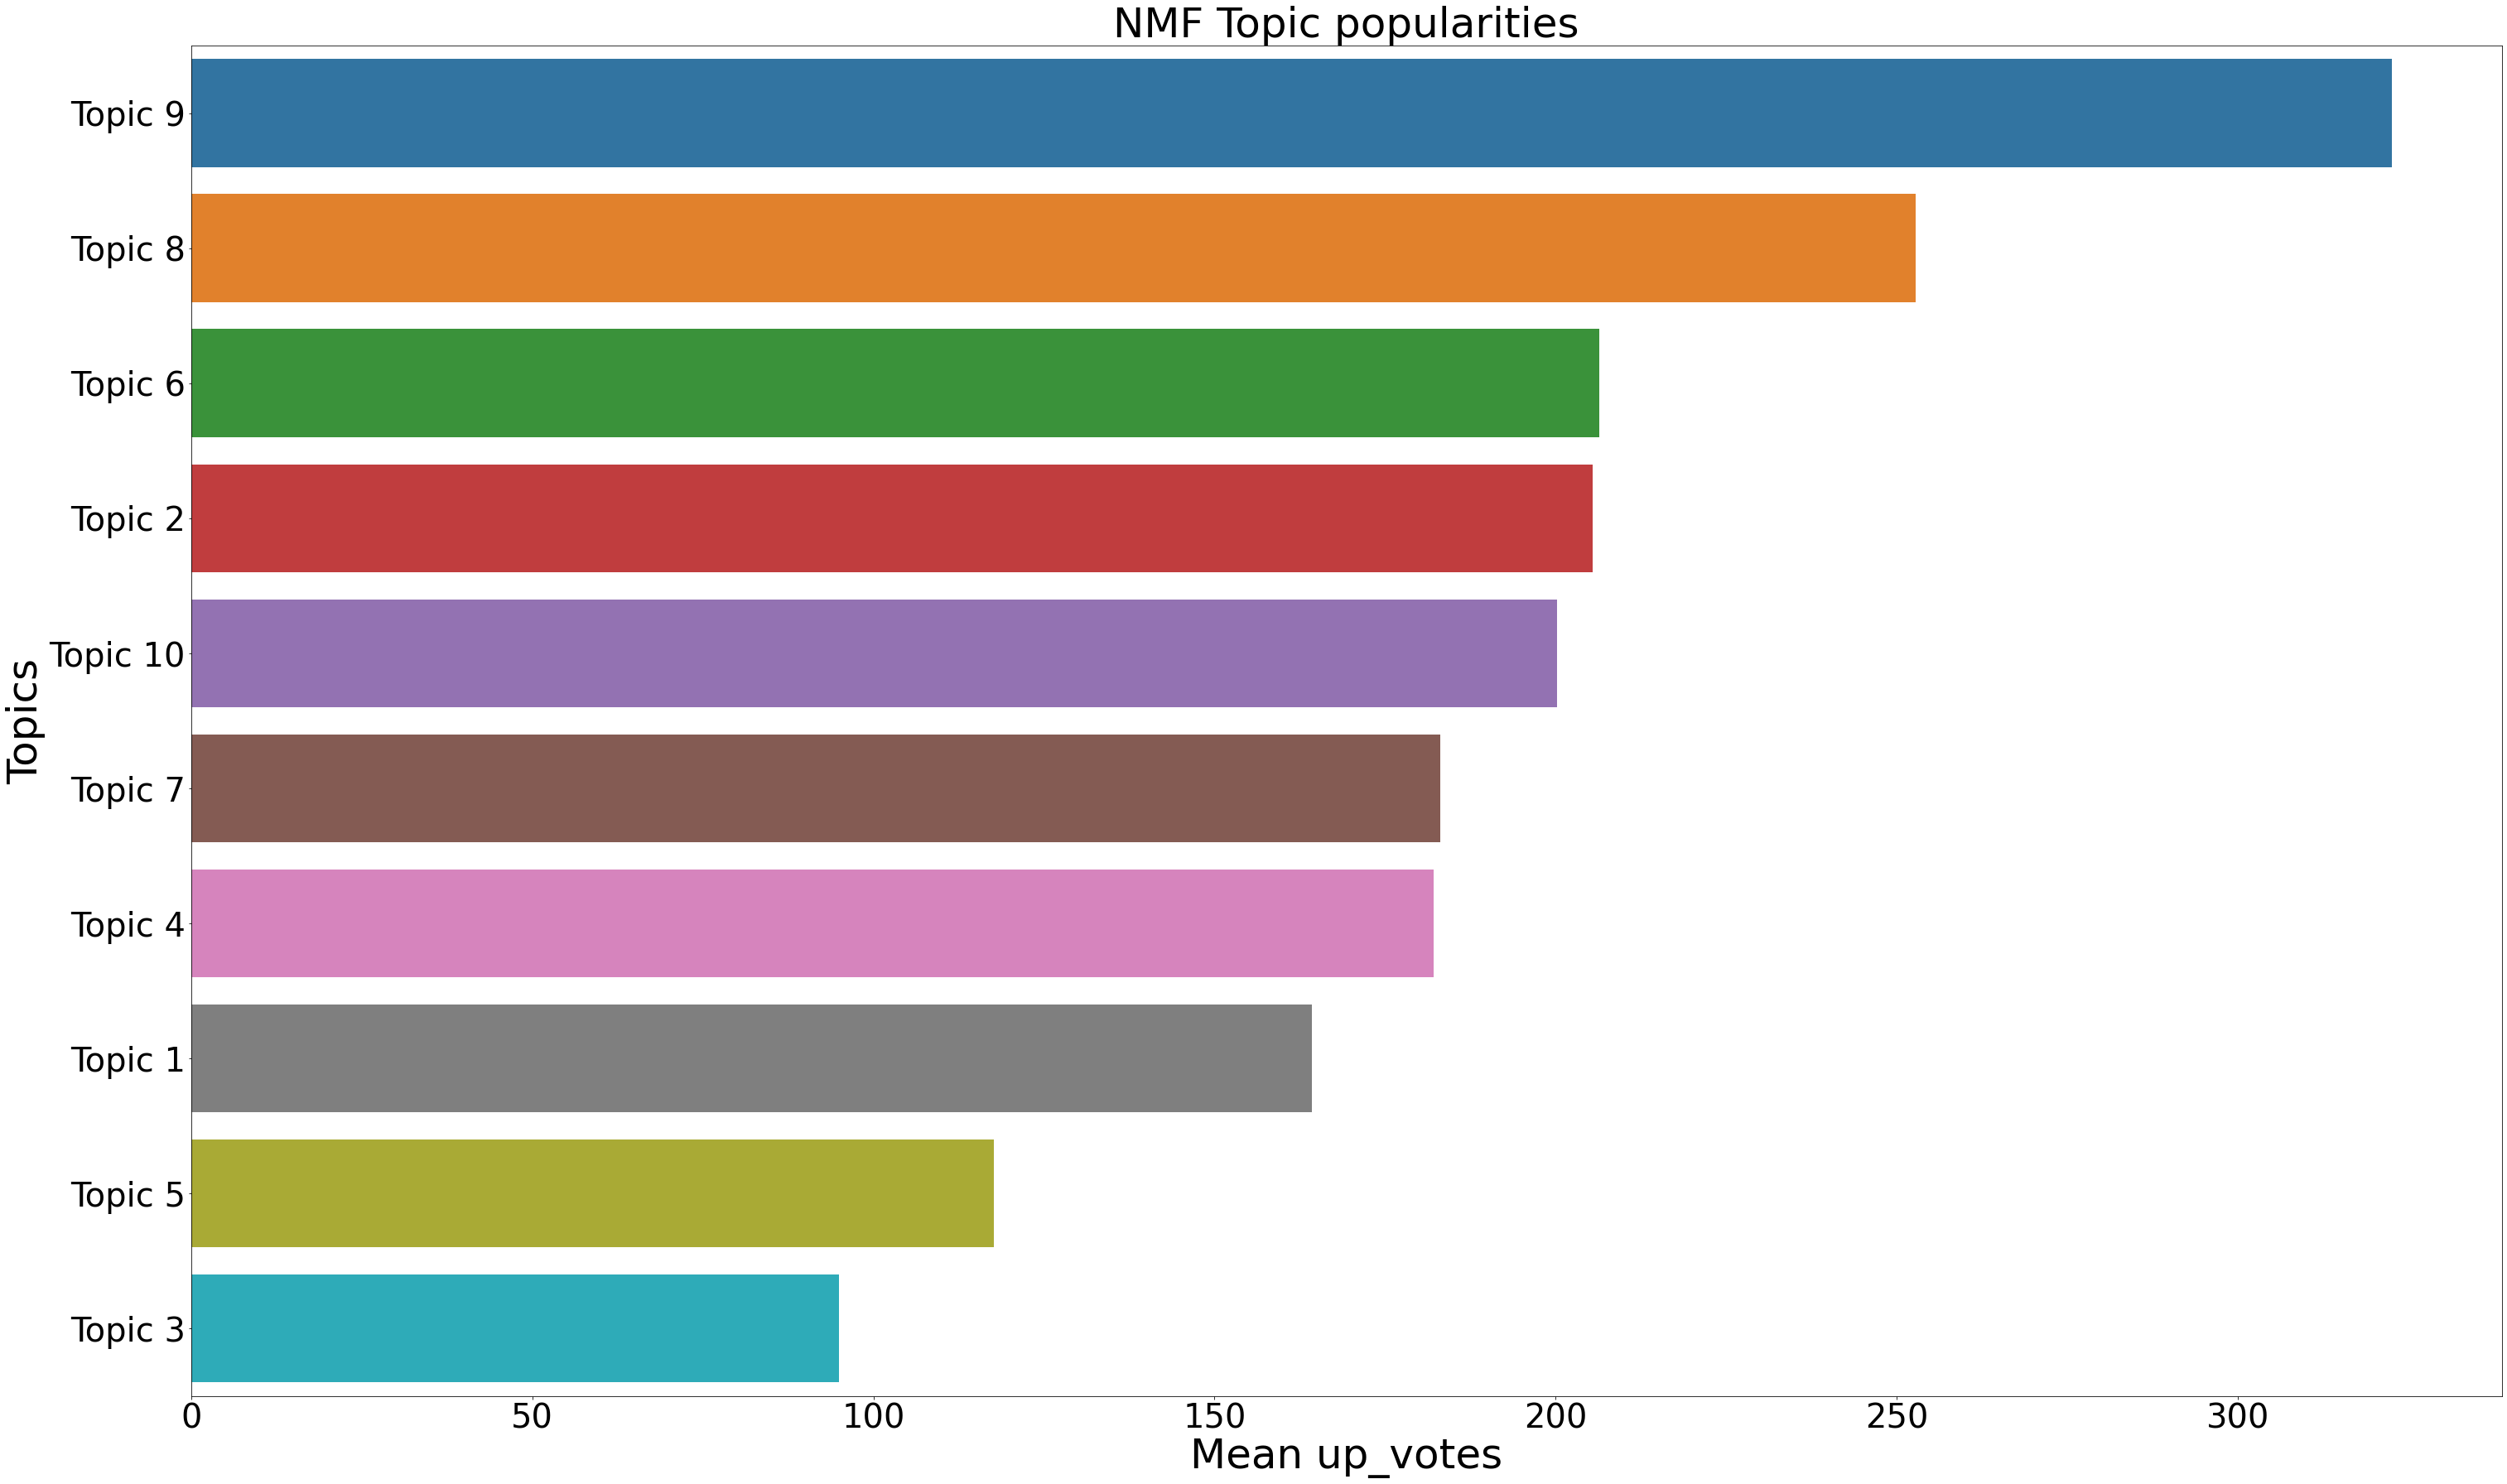

In [67]:
# Let's look at the bigrmas only

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2016,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2016 (with only bigrams)', 2016)

**This is really interesting now !** We have some new topics altogther for example the one on climate change (topic 9) and if you carefully look at the other bigrams in the topic, they are all related to the topic of climate change. And on top of that, it has the highest average upvotes which is significantly higher that any of the other topics considered in the unigrams sections. Sometimes for the unigrams, even if they end up with a high weightage, they don't necessarily convey anything meaningful instead they end up clouding some of the other important topics that can only be expressed by bigrams.

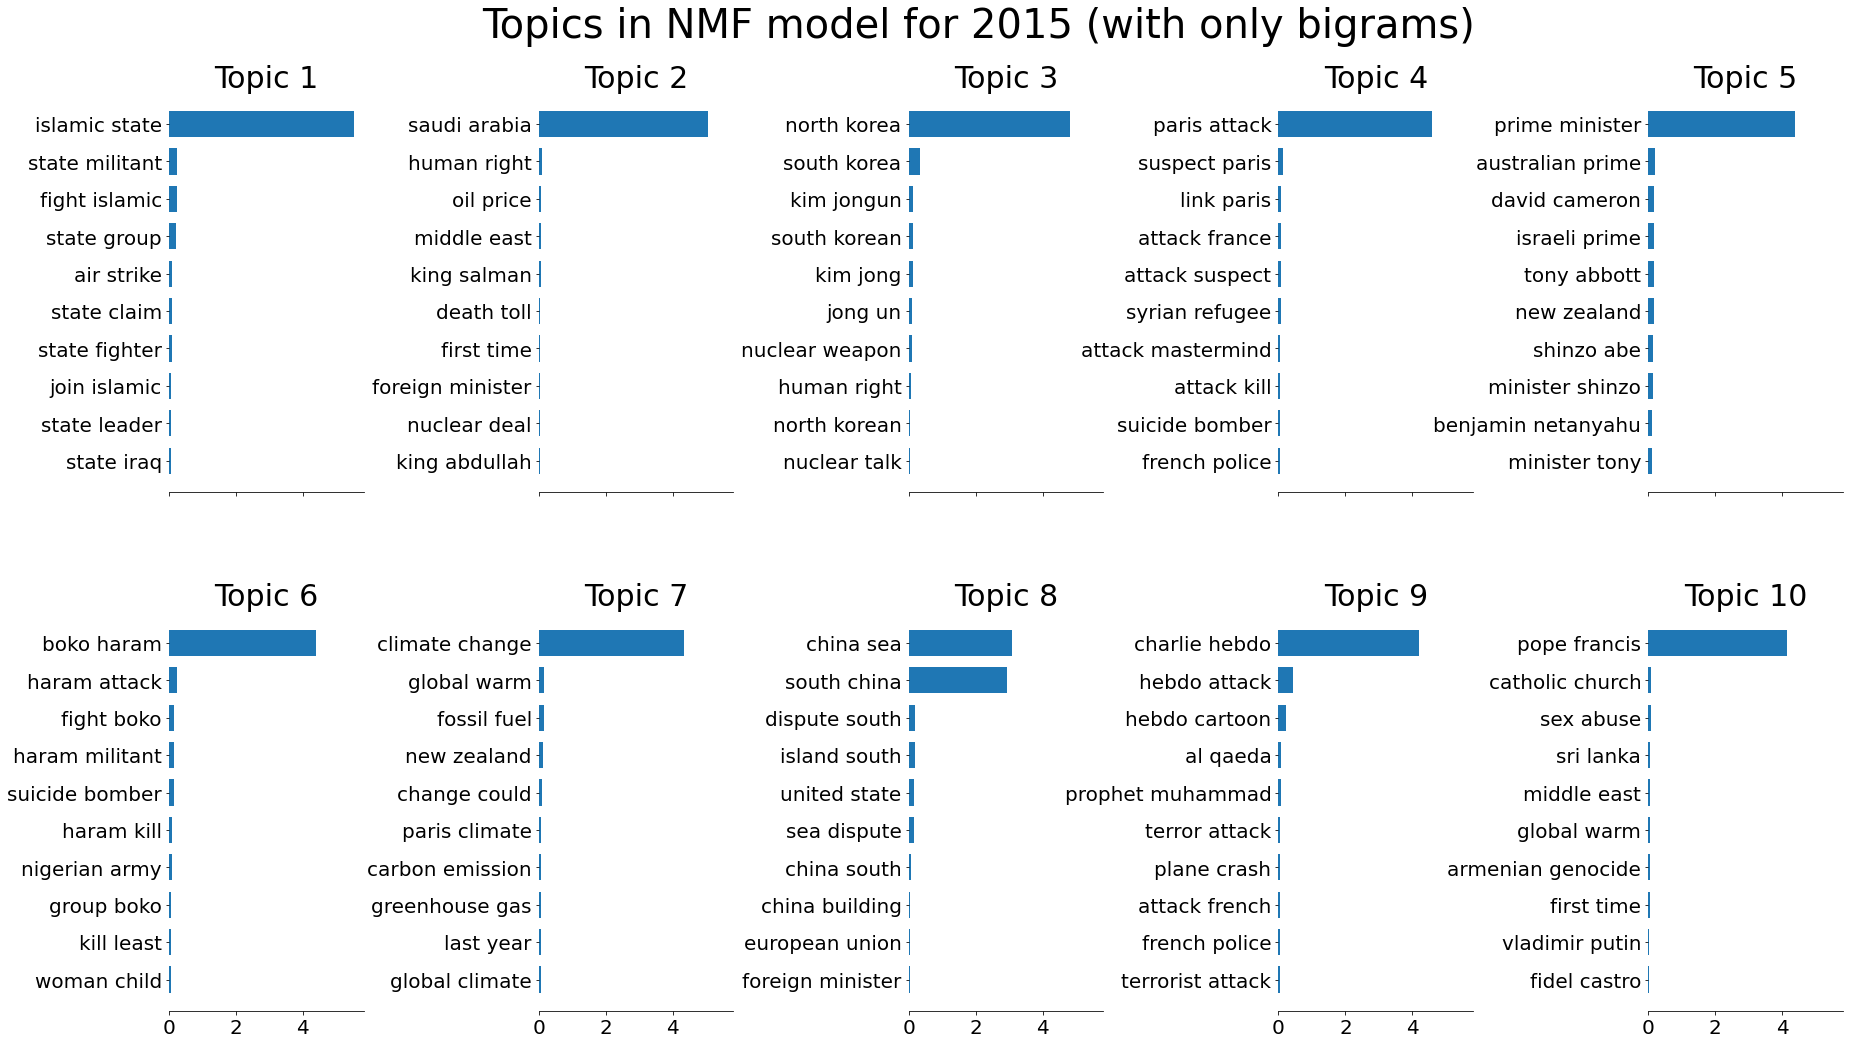

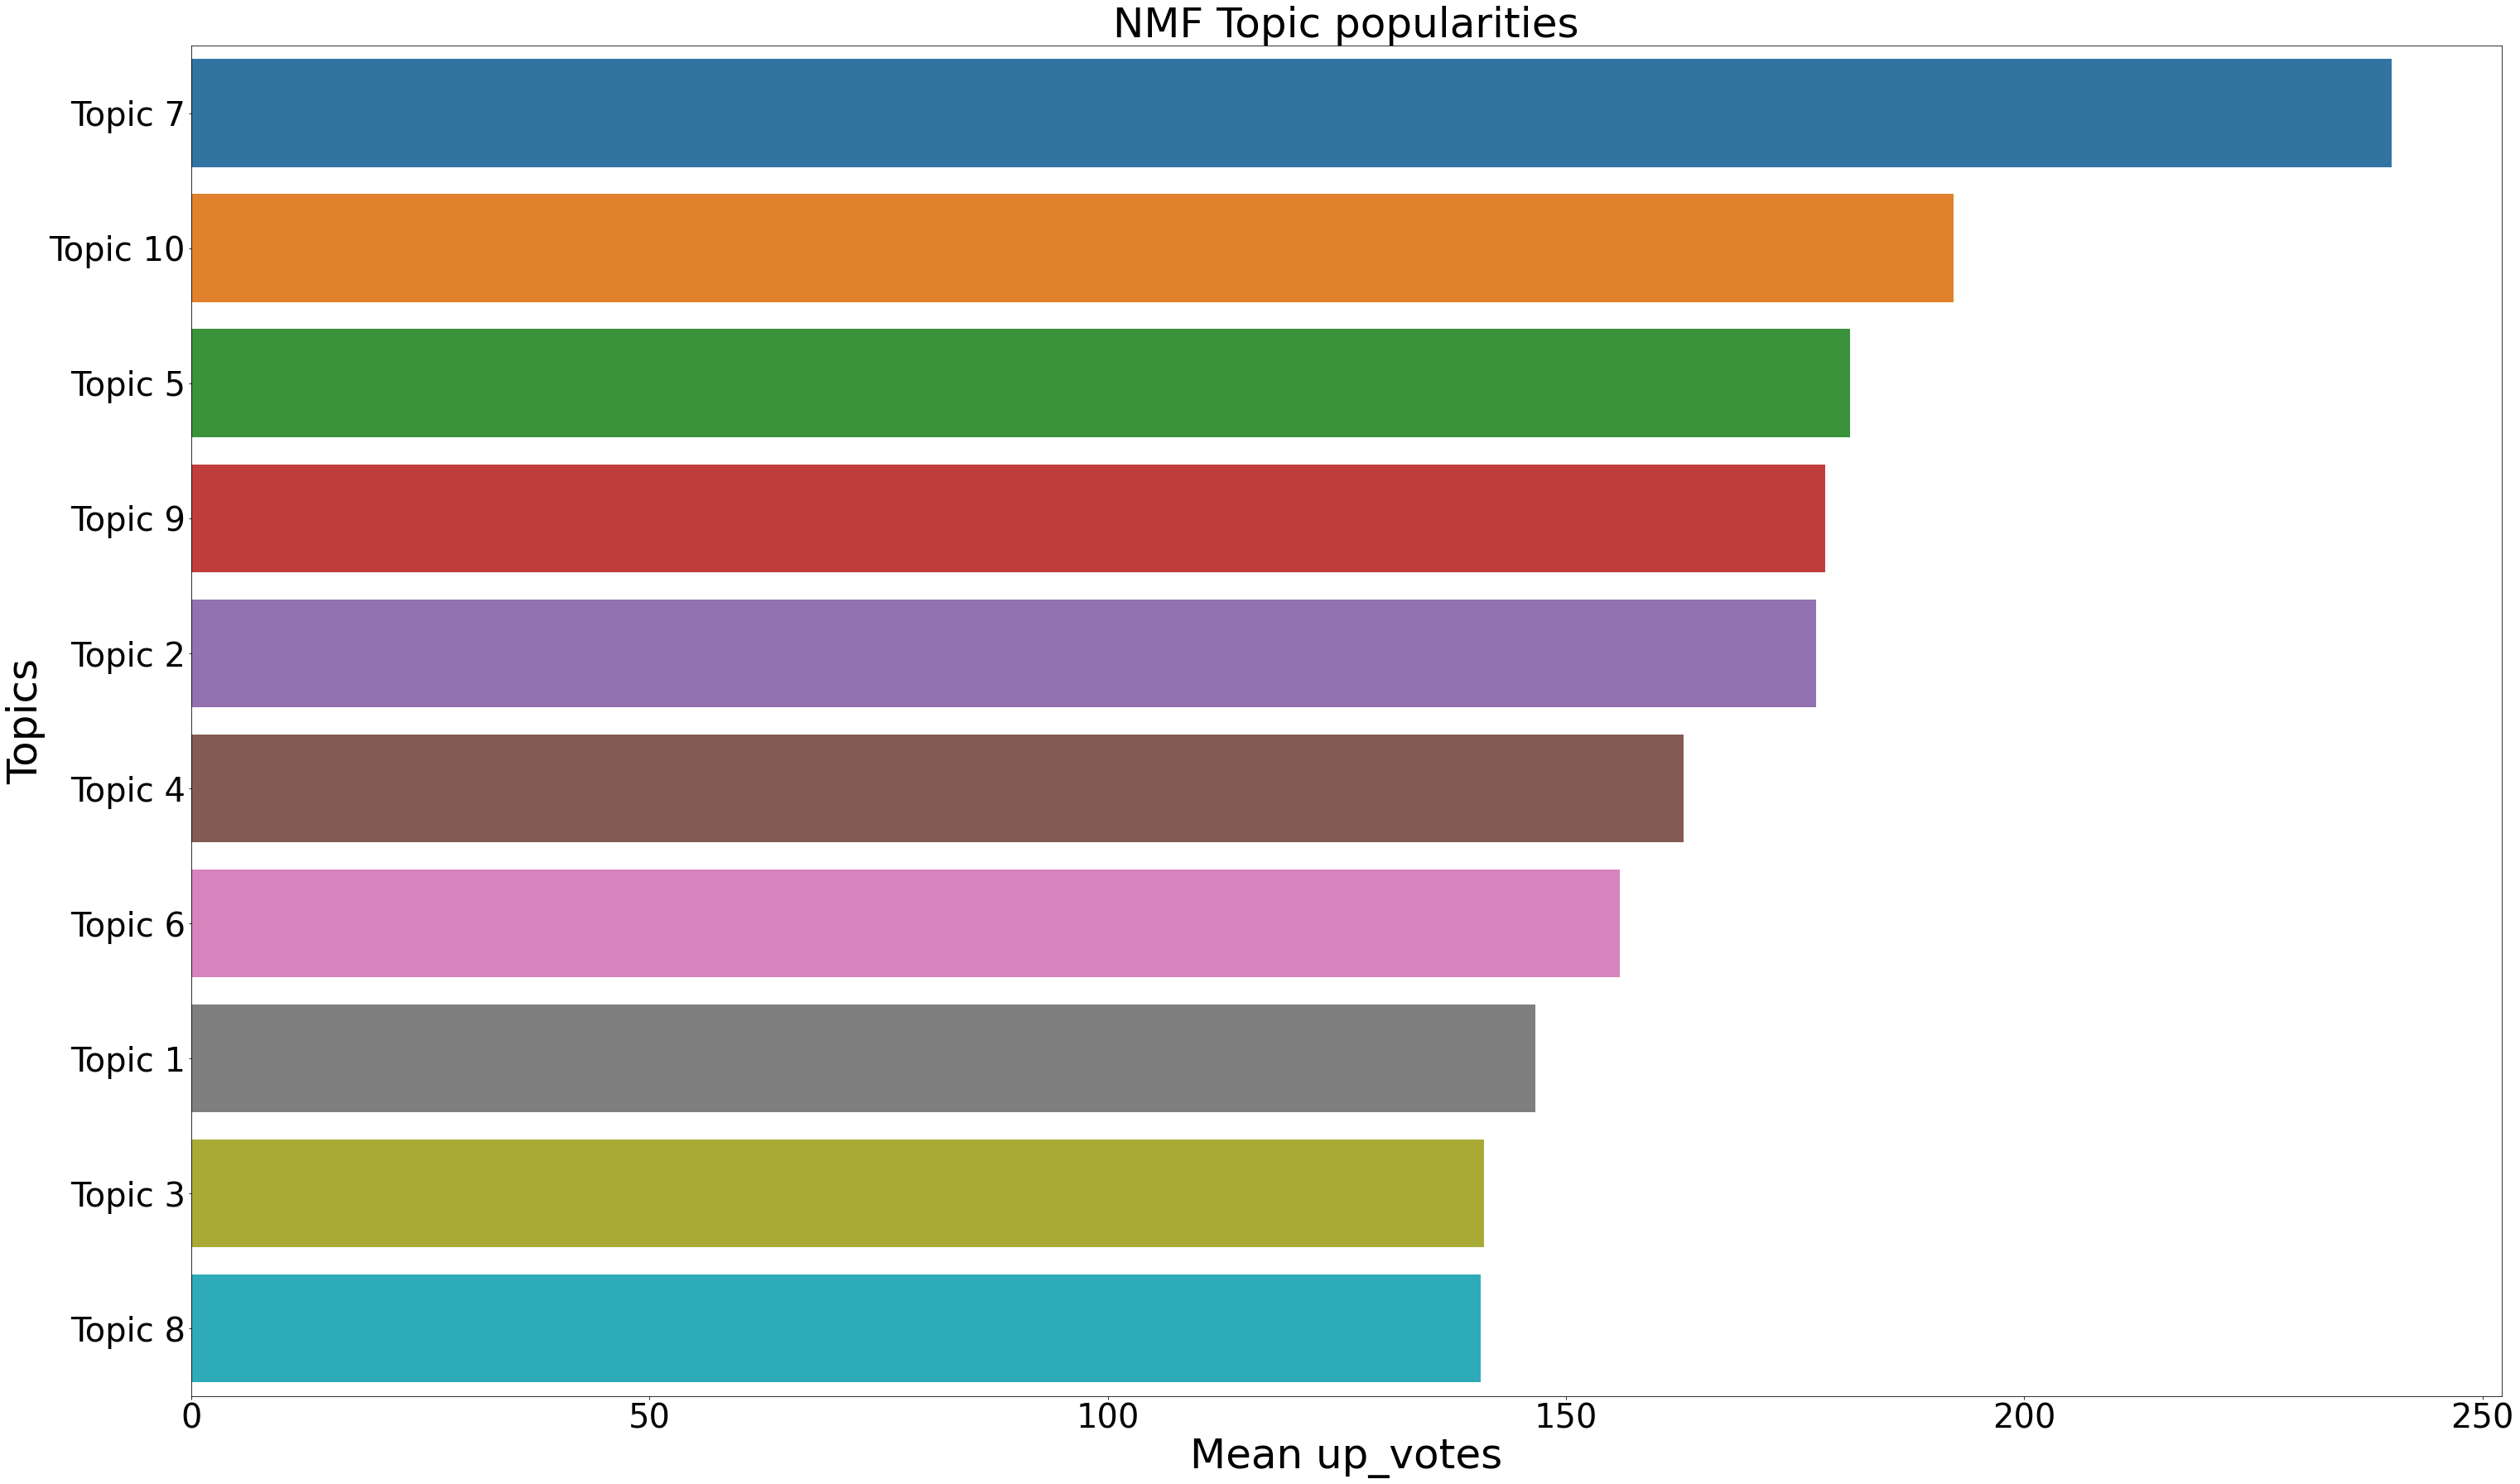

In [68]:
# Let's continue this analysis for 2015

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2015,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2015 (with only bigrams)', 2015)

Apart from some similar news from 2016 (which is expected), we have some new ones never seen in the unigrams analysis - **boko haram** and **charlie hebdo**.  

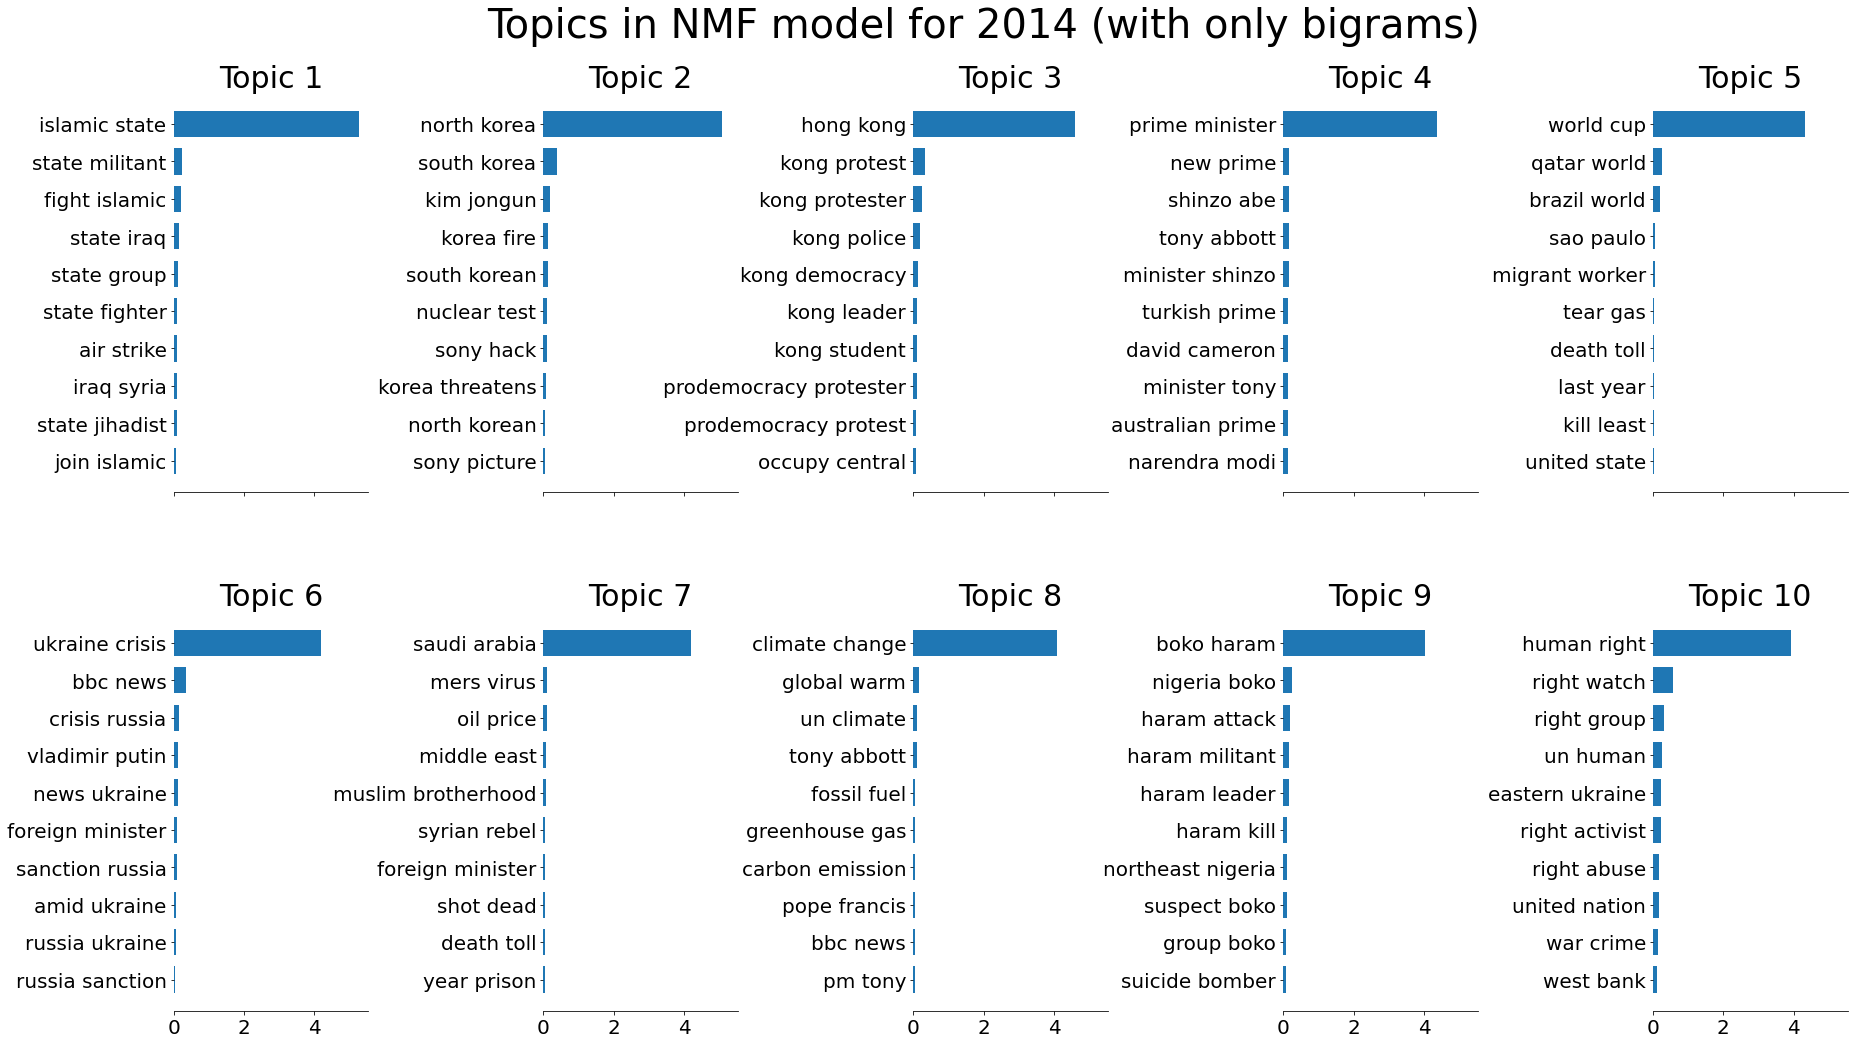

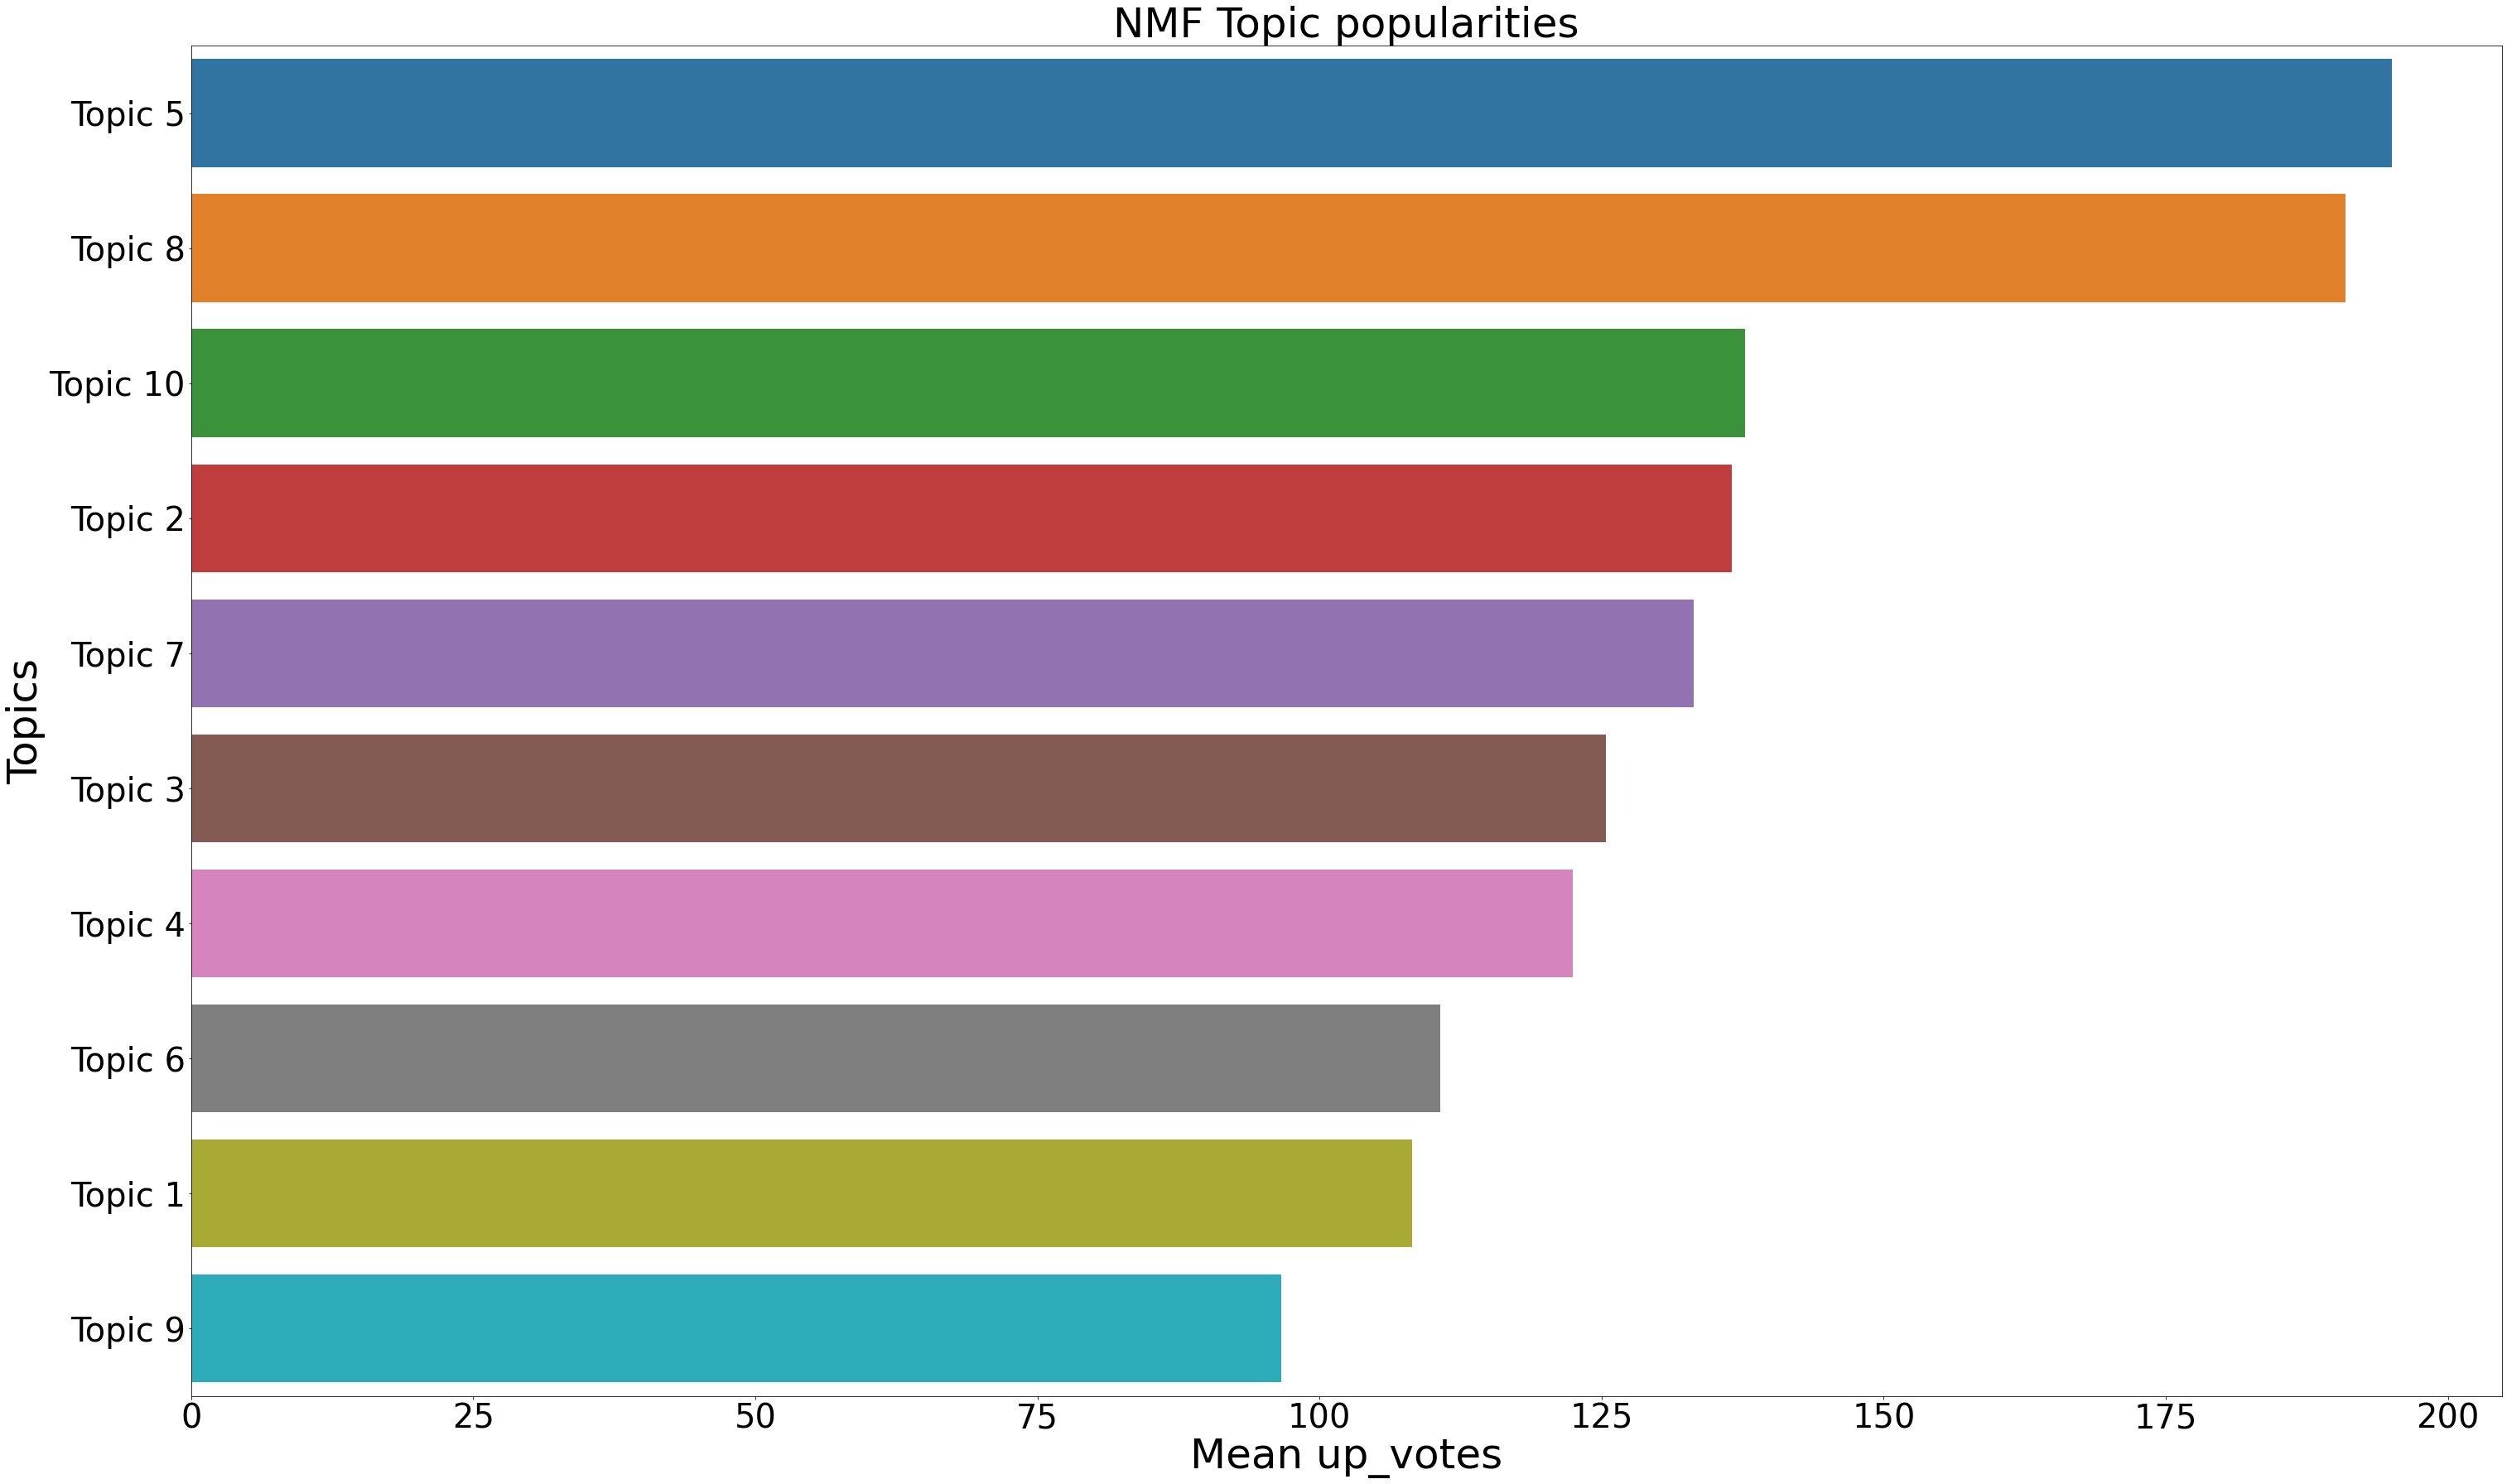

In [69]:
# 2014 men's soccer word cup in Brazil pops out with the bigram analysis

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2014,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2014 (with only bigrams)', 2014)

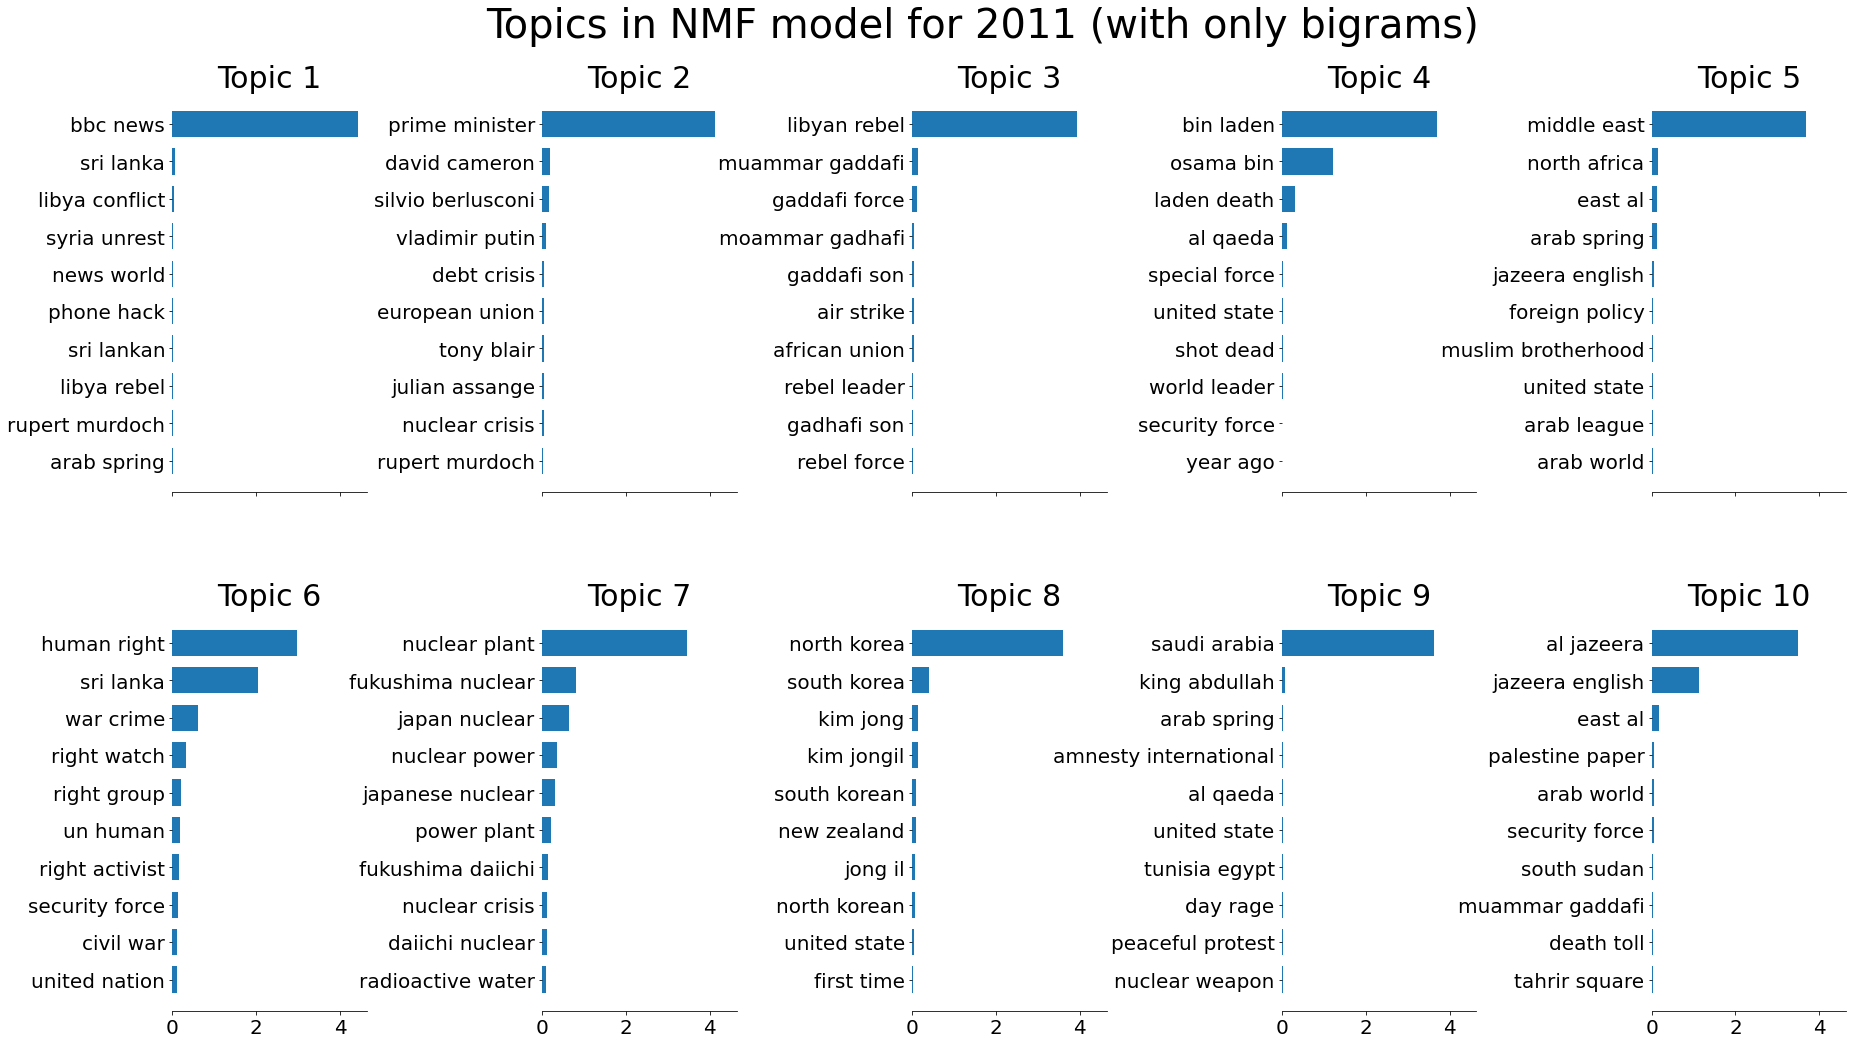

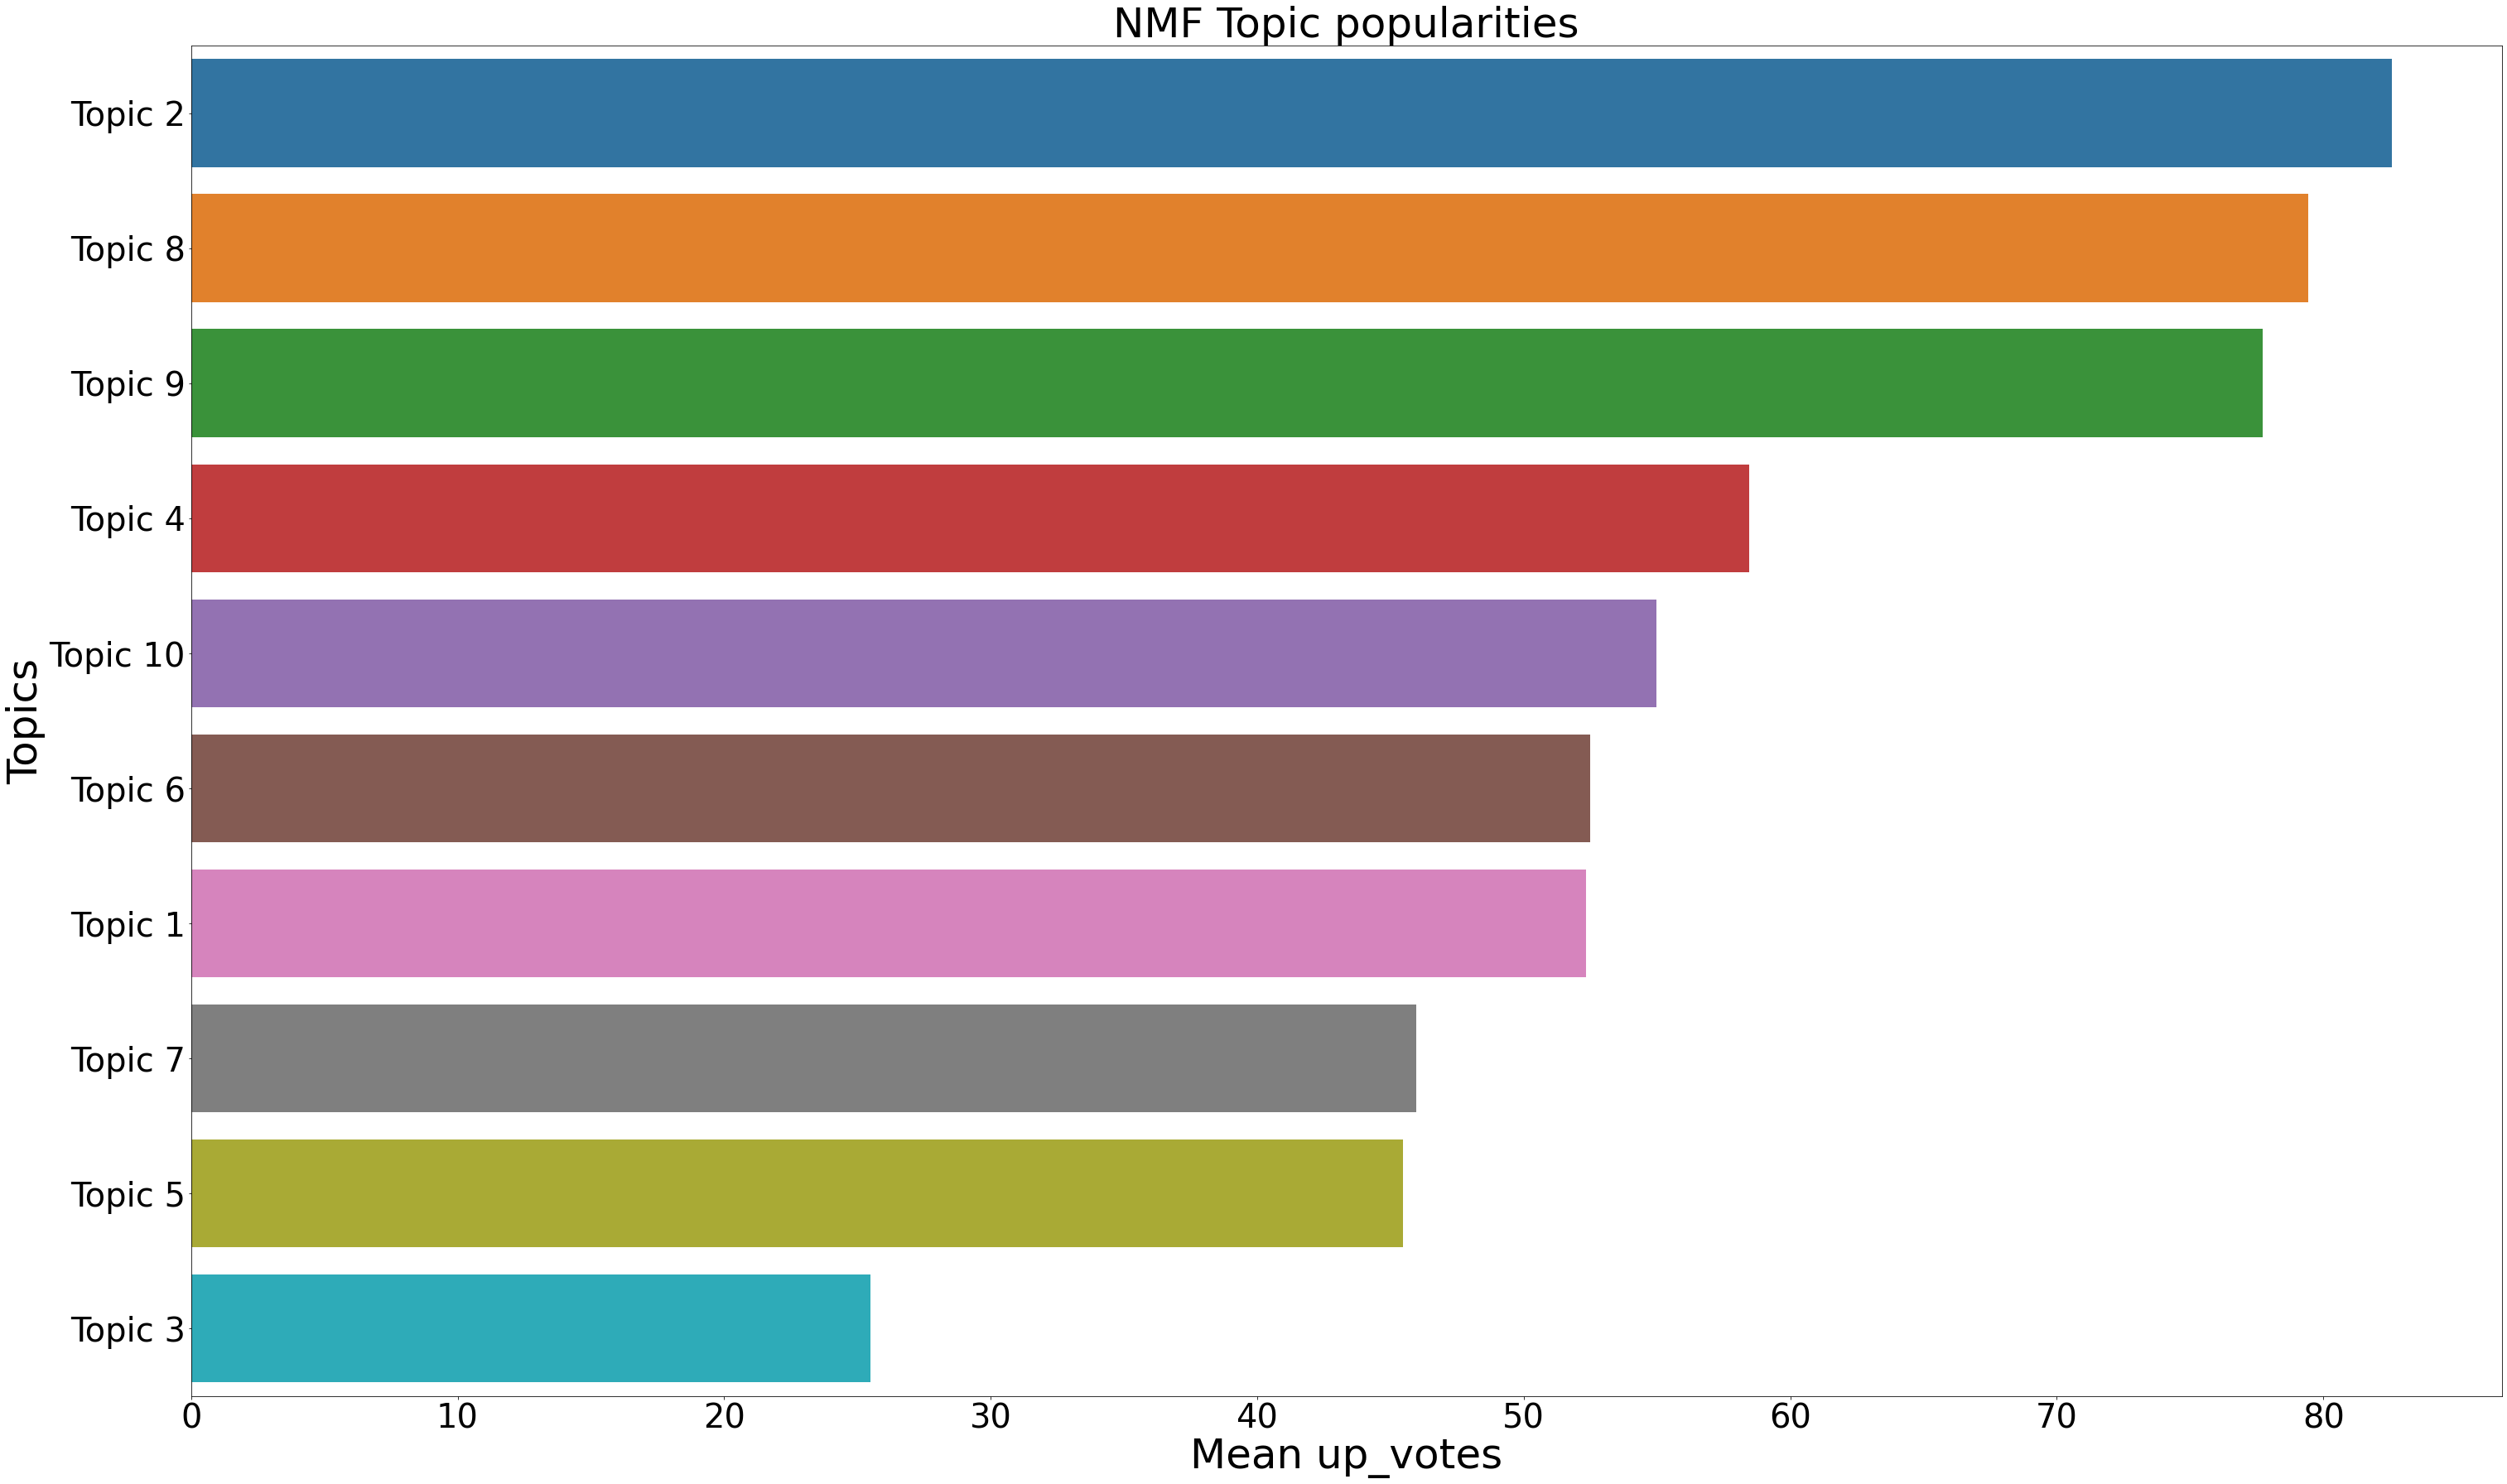

In [70]:
# News of osama bin laden's being shot dead in 2011

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['year']==2011,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics(nmf, tfidf_feature_names, 10, 'Topics in NMF model for 2011 (with only bigrams)', 2011)

**So the basic takeaway here is to analyize different n_grams to extract all possible and equally important information from a dataset like this.**

## How about the authors of the articles?

Now we could use the same functions to charcterize the authors by looking at the kind of news they cover.

In [71]:
def plot_popular_topics_by_author(nmf, tfidf_feature_names, n_top_words, title, author):
    
    plot_top_words(nmf, tfidf_feature_names, 10,
               title)

    df_copy = df.loc[df['author']==author,:].reset_index()
    nmf_topic_values = nmf.transform(tfidf)
    df_copy['nmf_topics'] = nmf_topic_values.argmax(axis=1)

    nmf_remap = {0: 'Topic 1', 1: 'Topic 2', 2: 'Topic 3', 3: 'Topic 4', 
                 4: 'Topic 5', 5: 'Topic 6', 6: 'Topic 7', 7: 'Topic 8', 
                 8: 'Topic 9', 9: 'Topic 10'}
    df_copy['nmf_topics'] = df_copy['nmf_topics'].map(nmf_remap)

    nmf_x = df_copy.groupby('nmf_topics')['up_votes'].mean().sort_values(ascending=False)
    nmf_y = list(nmf_x.index)
    plt.figure(figsize=(50,30))
    sns.barplot(x = nmf_x, y = nmf_y)
    plt.title("NMF Topic popularities", fontsize=50)
    plt.ylabel('Topics', fontsize=50)
    plt.yticks(fontsize=40)
    plt.xlabel('Mean up_votes', fontsize=50)
    plt.xticks(fontsize=40)
    plt.show()

In [72]:
df.author.value_counts()[:10]

davidreiss666    8897
anutensil        5730
DoremusJessup    5037
maxwellhill      4023
igeldard         4013
readerseven      3170
twolf1           2923
madam1           2658
nimobo           2564
madazzahatter    2503
Name: author, dtype: int64

**Let's explore only the top two authors here. The same function can be used for the other authors.**

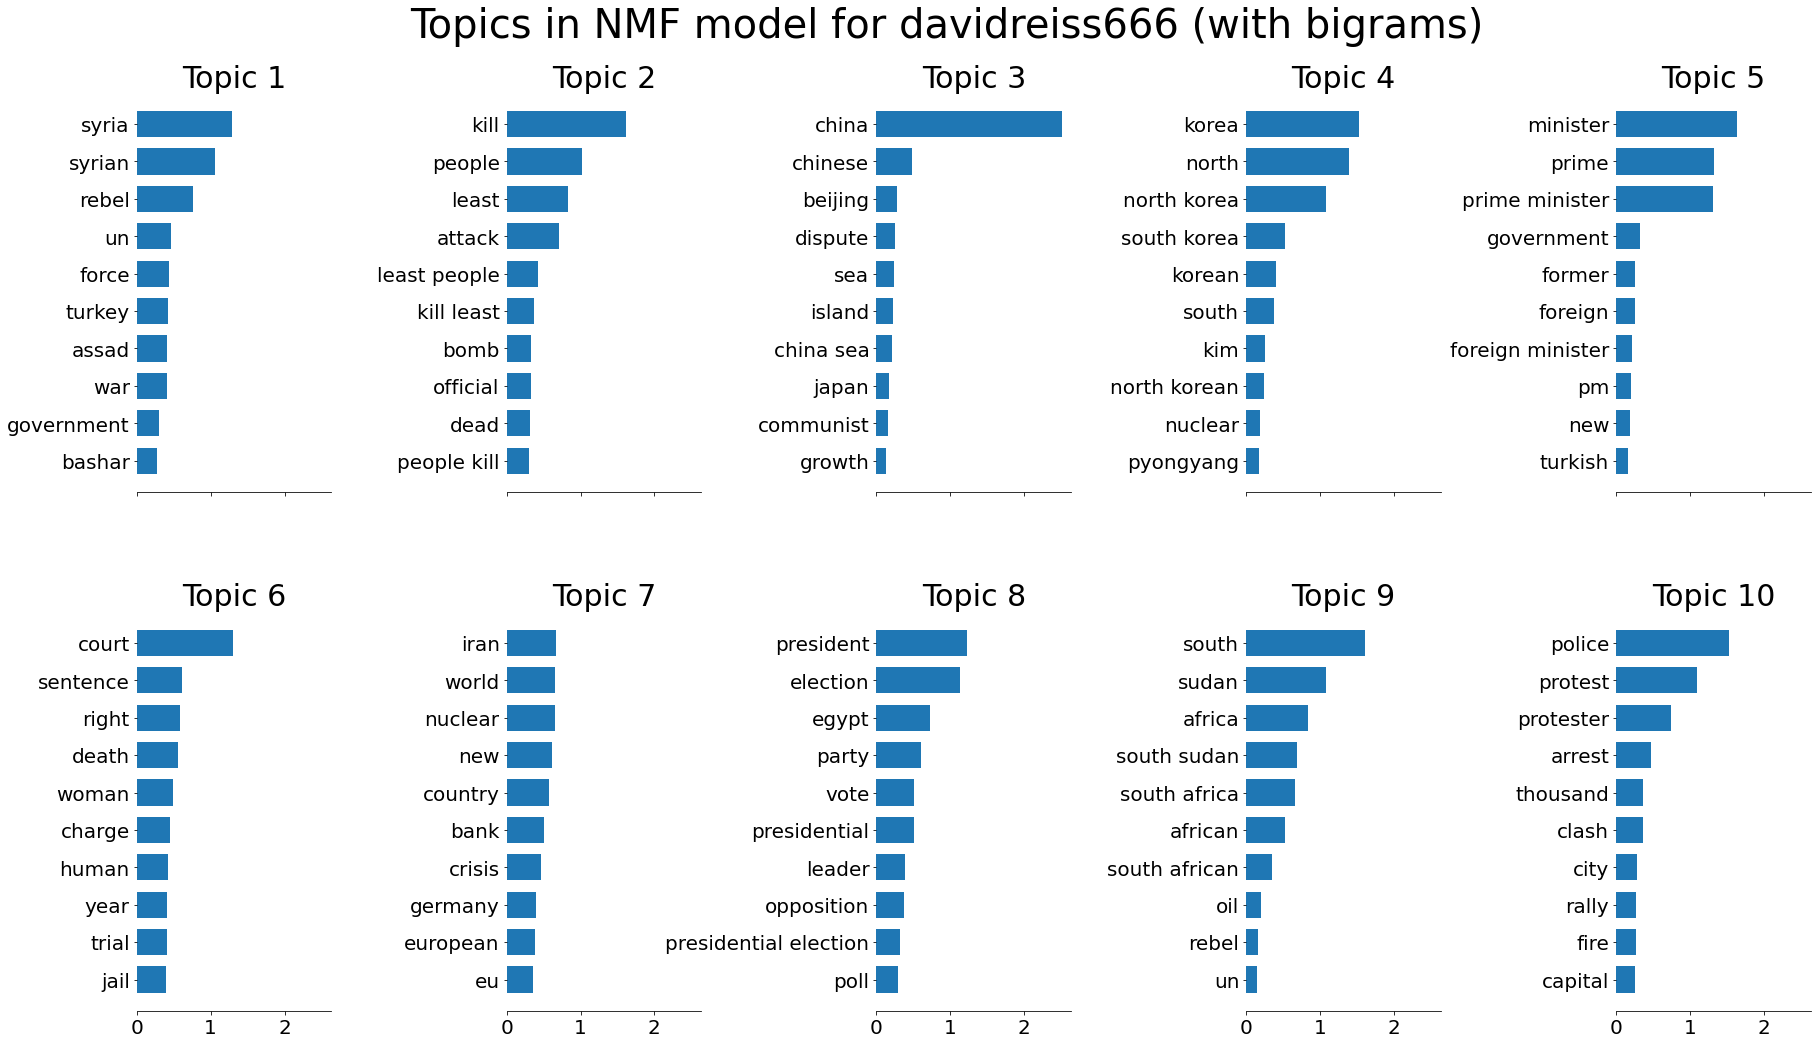

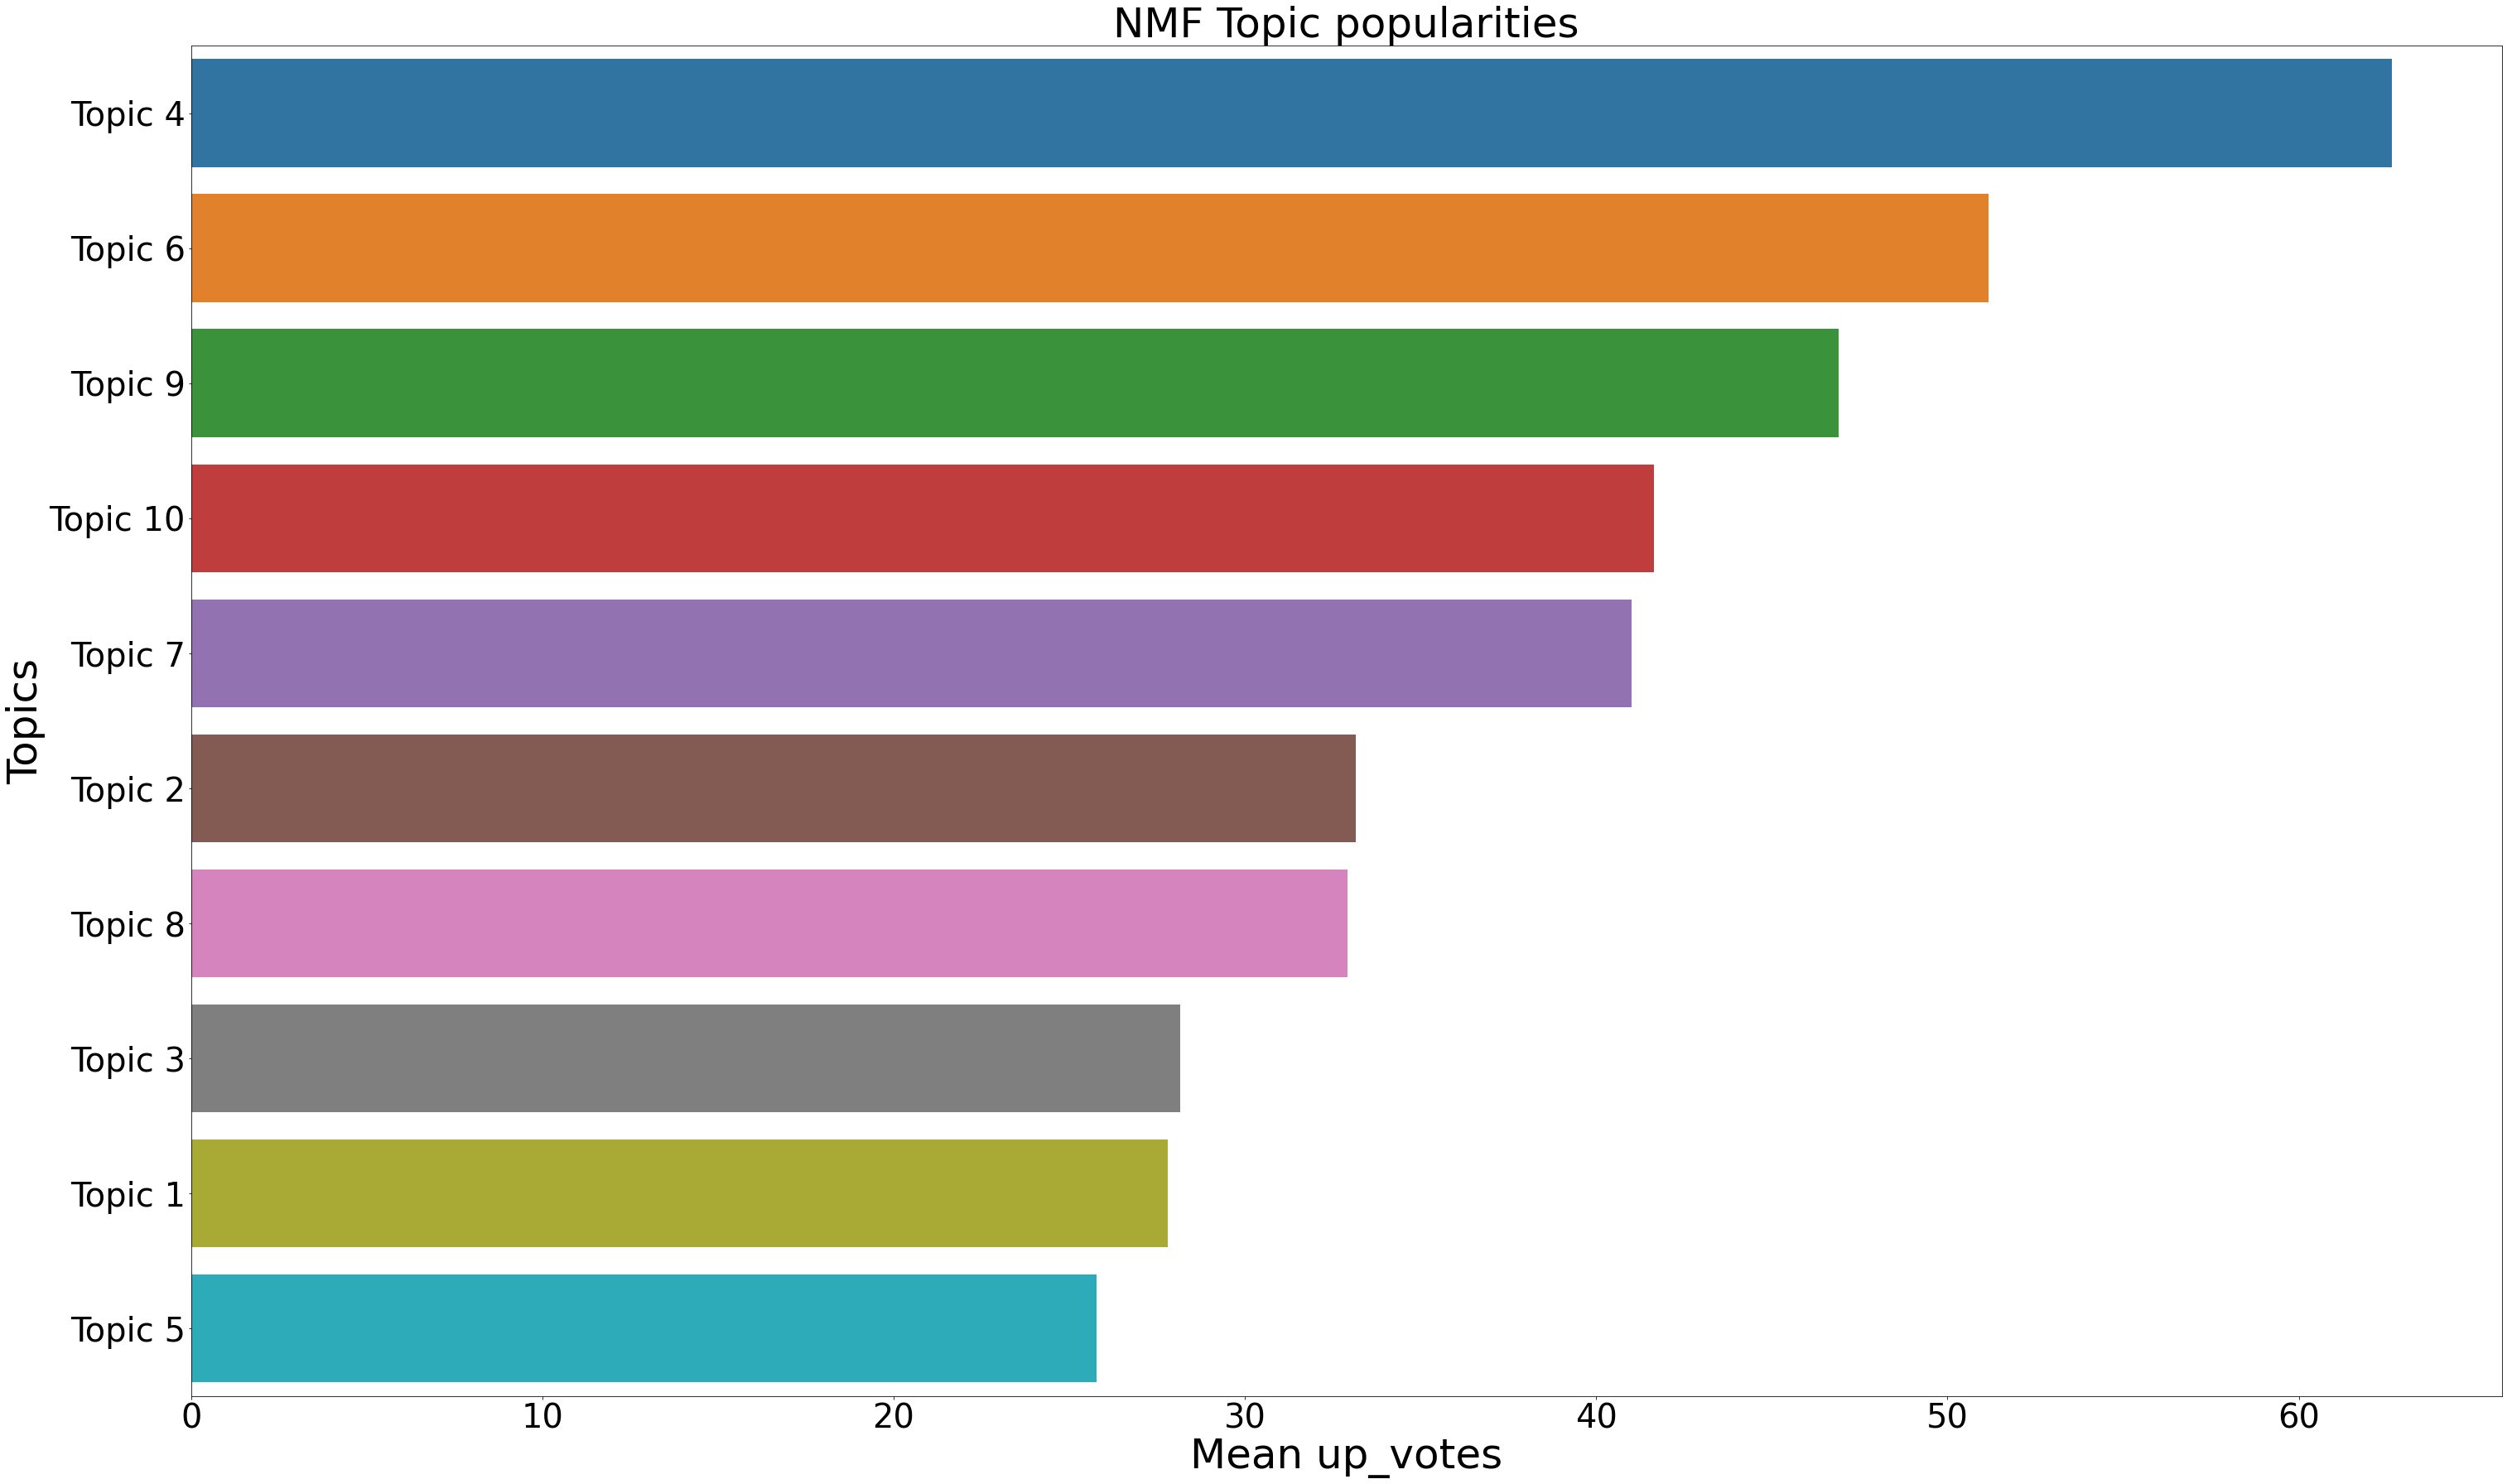

In [73]:
author = 'davidreiss666'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with bigrams)', author)

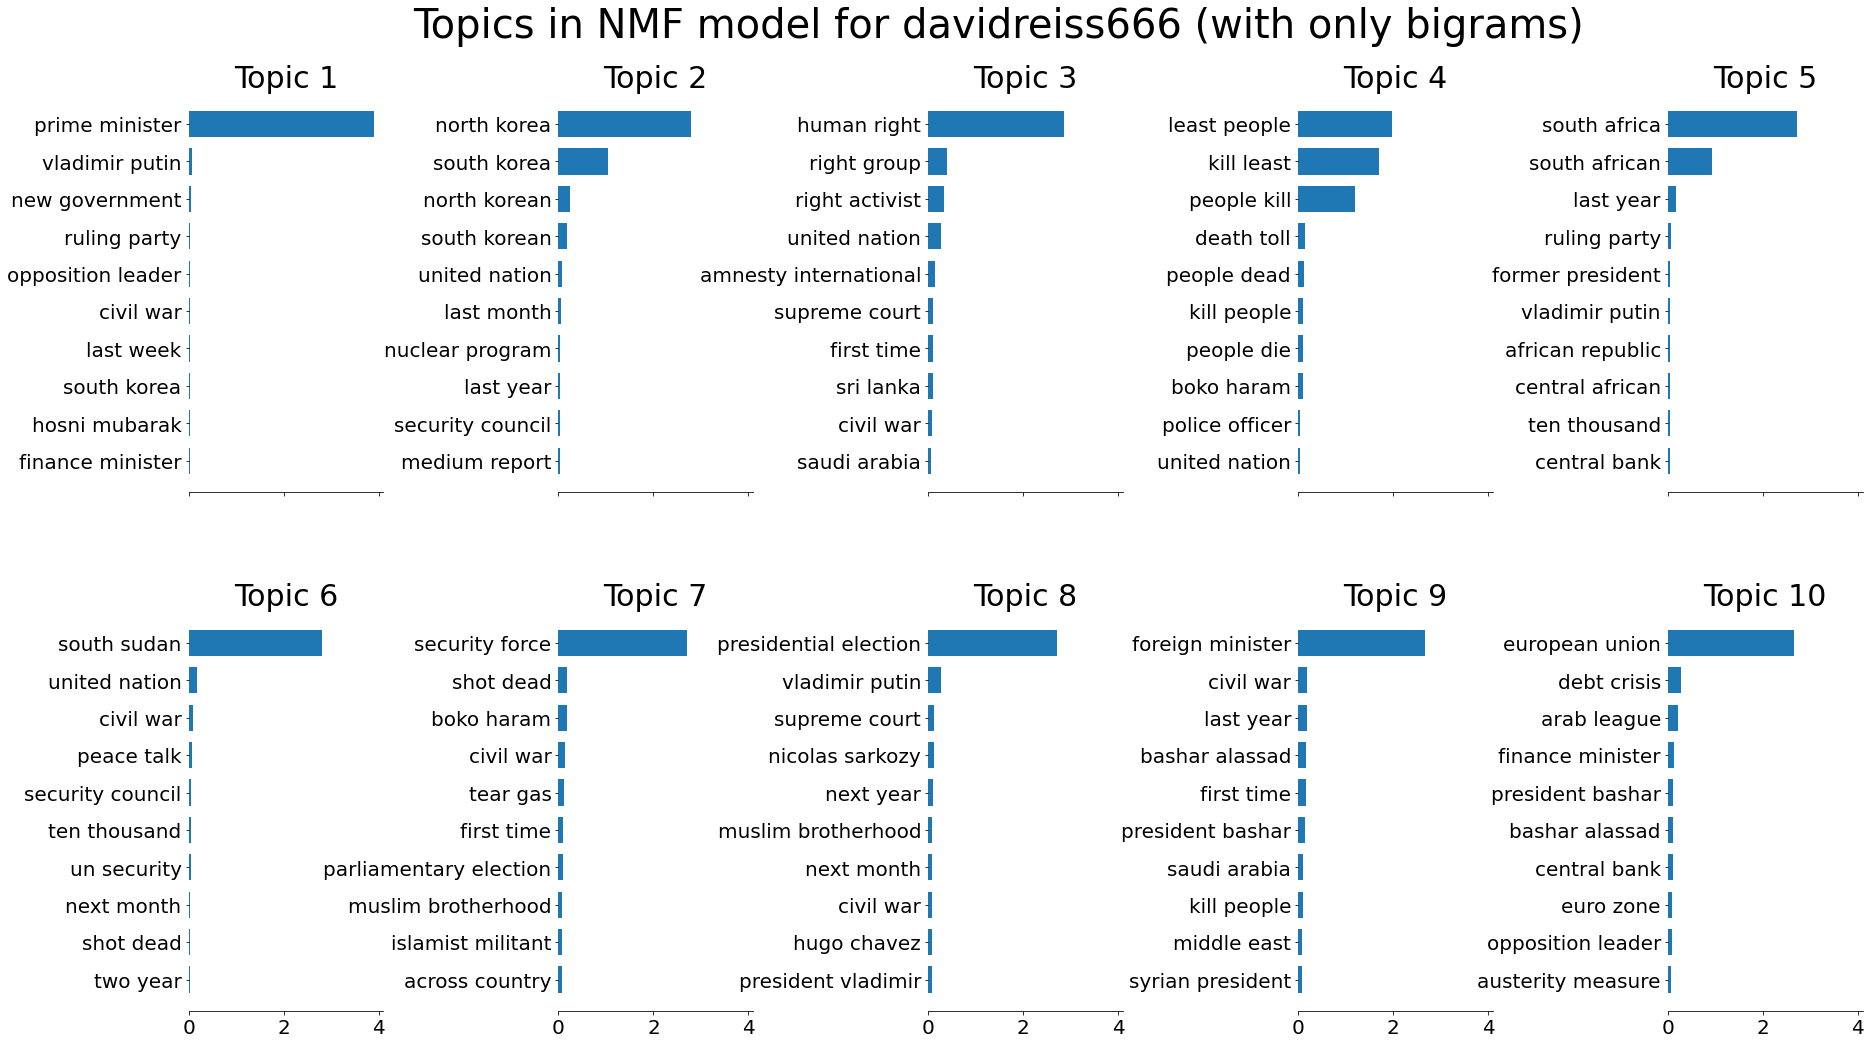

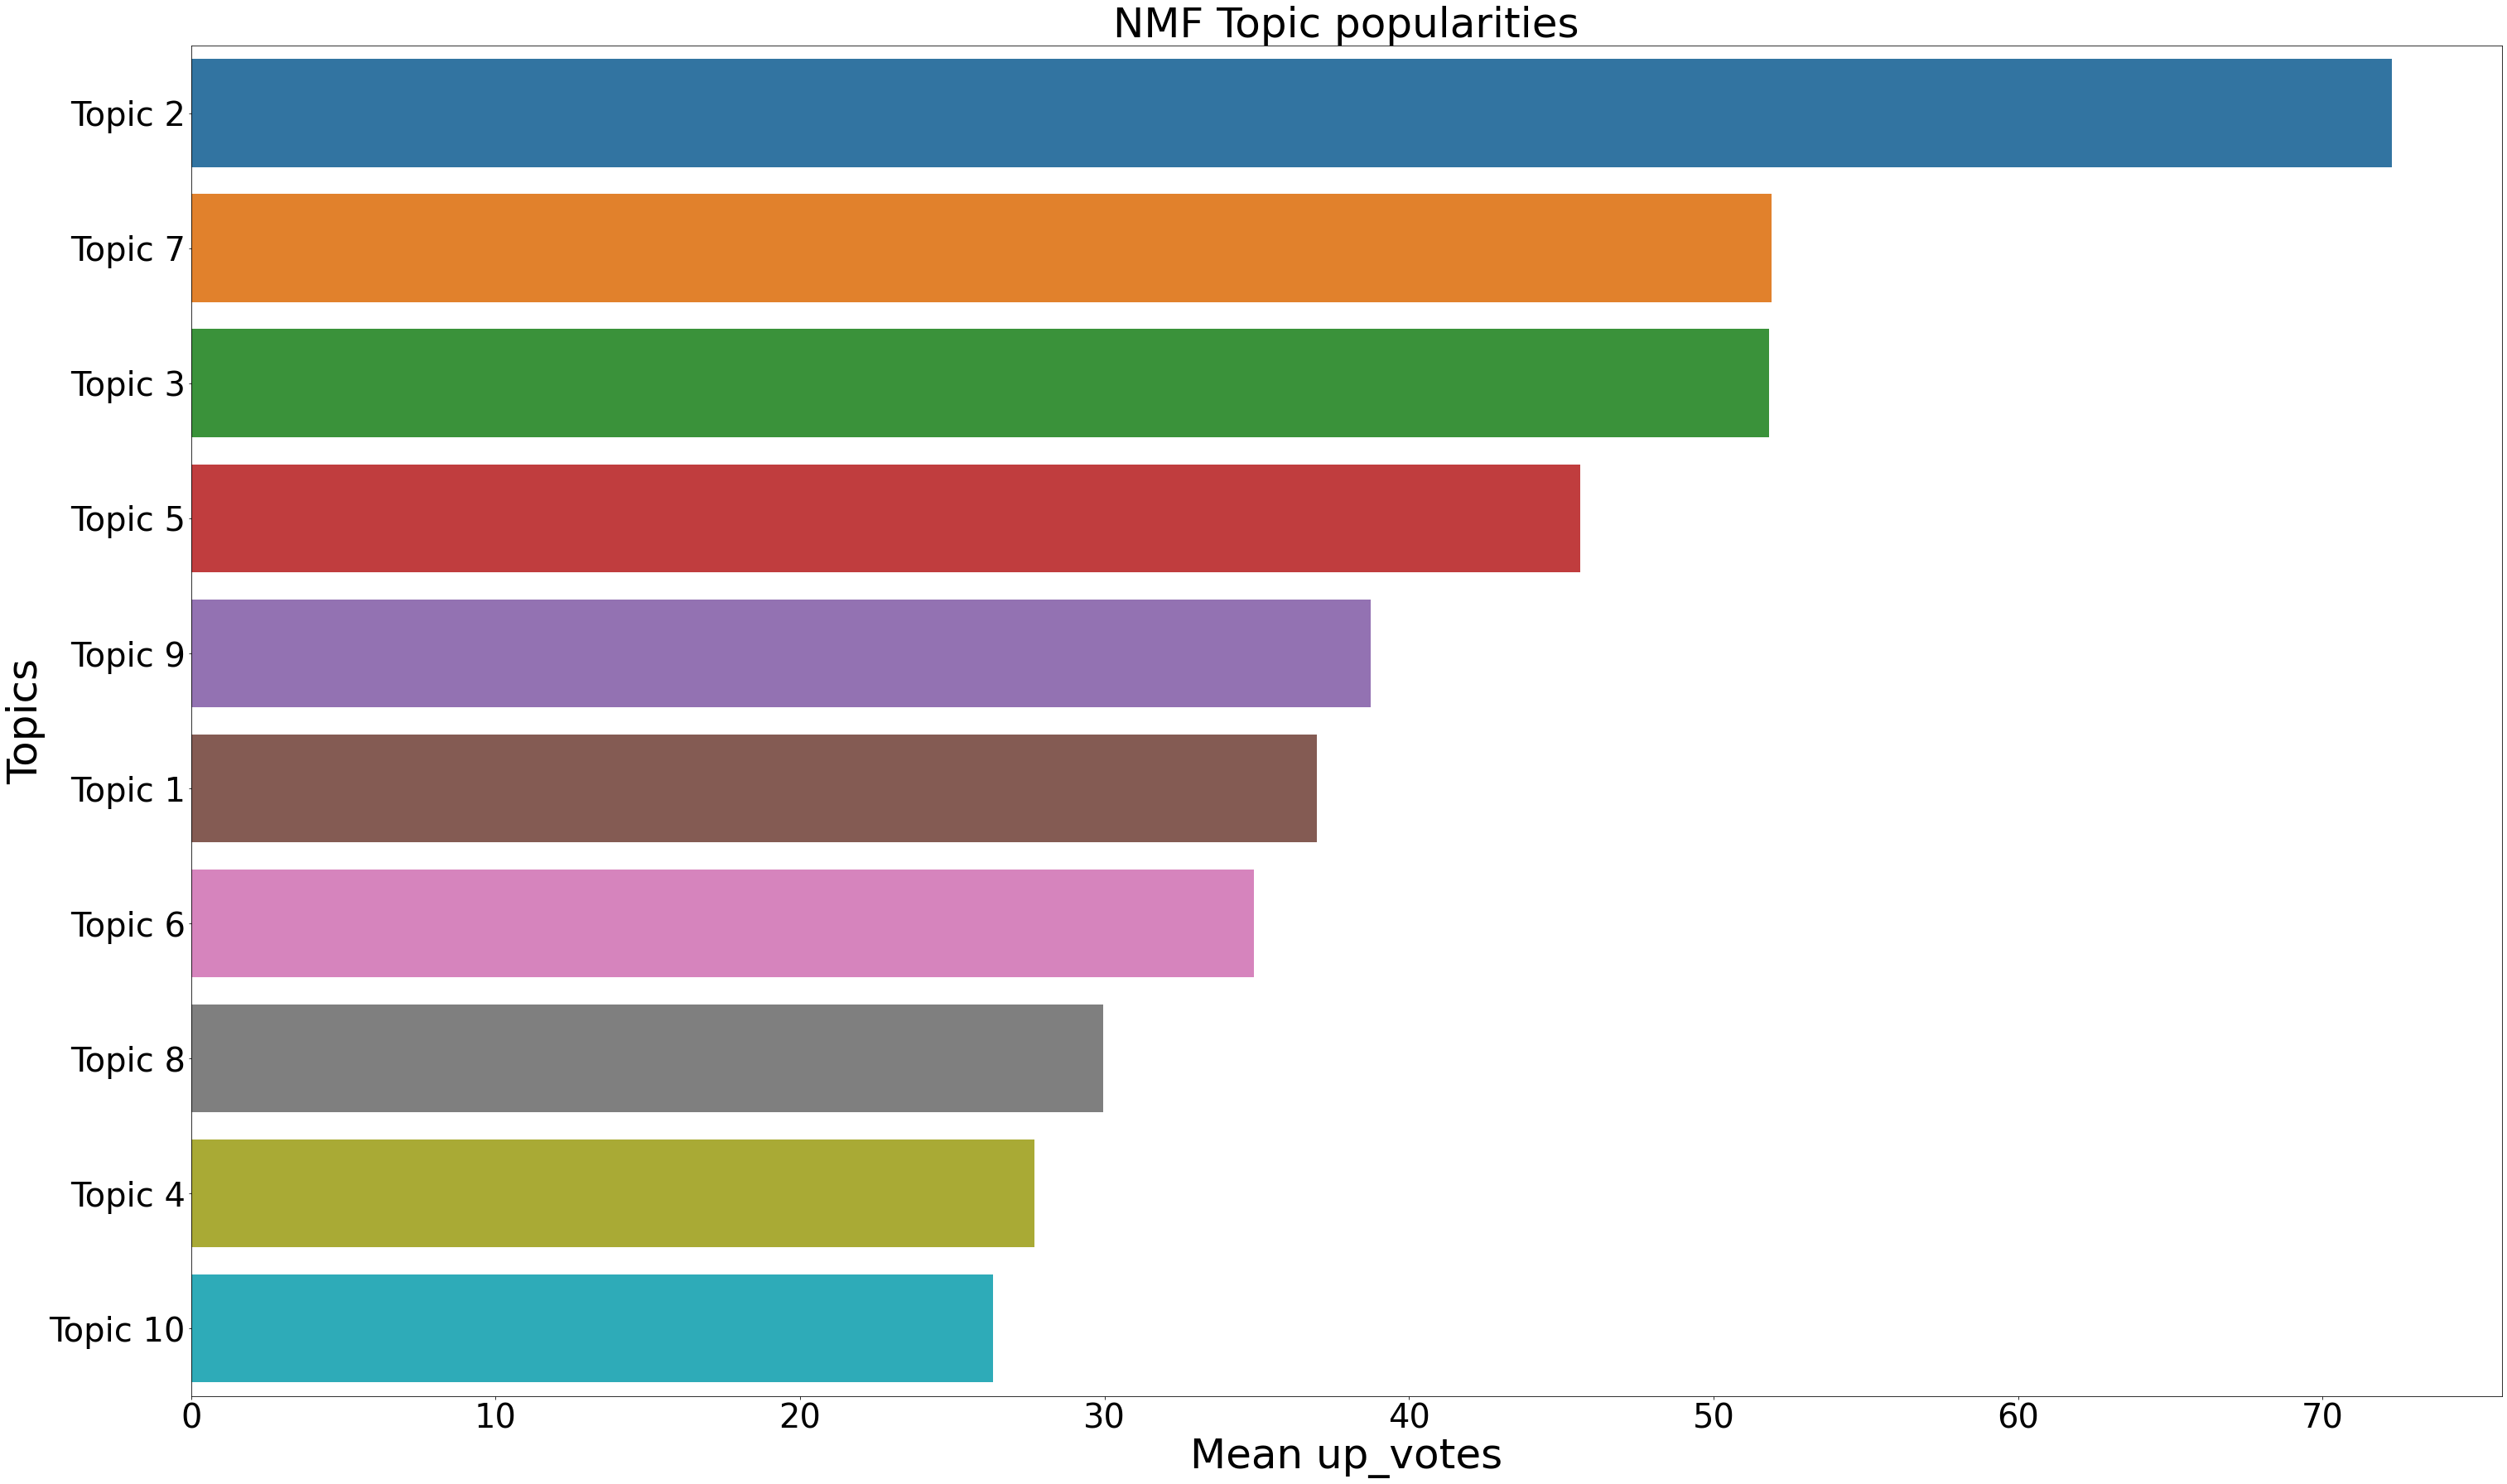

In [74]:
author = 'davidreiss666'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with only bigrams)', author)

### 'davidreiss666' mostly covers *terrorism*, *murders* , *killings*, etc.

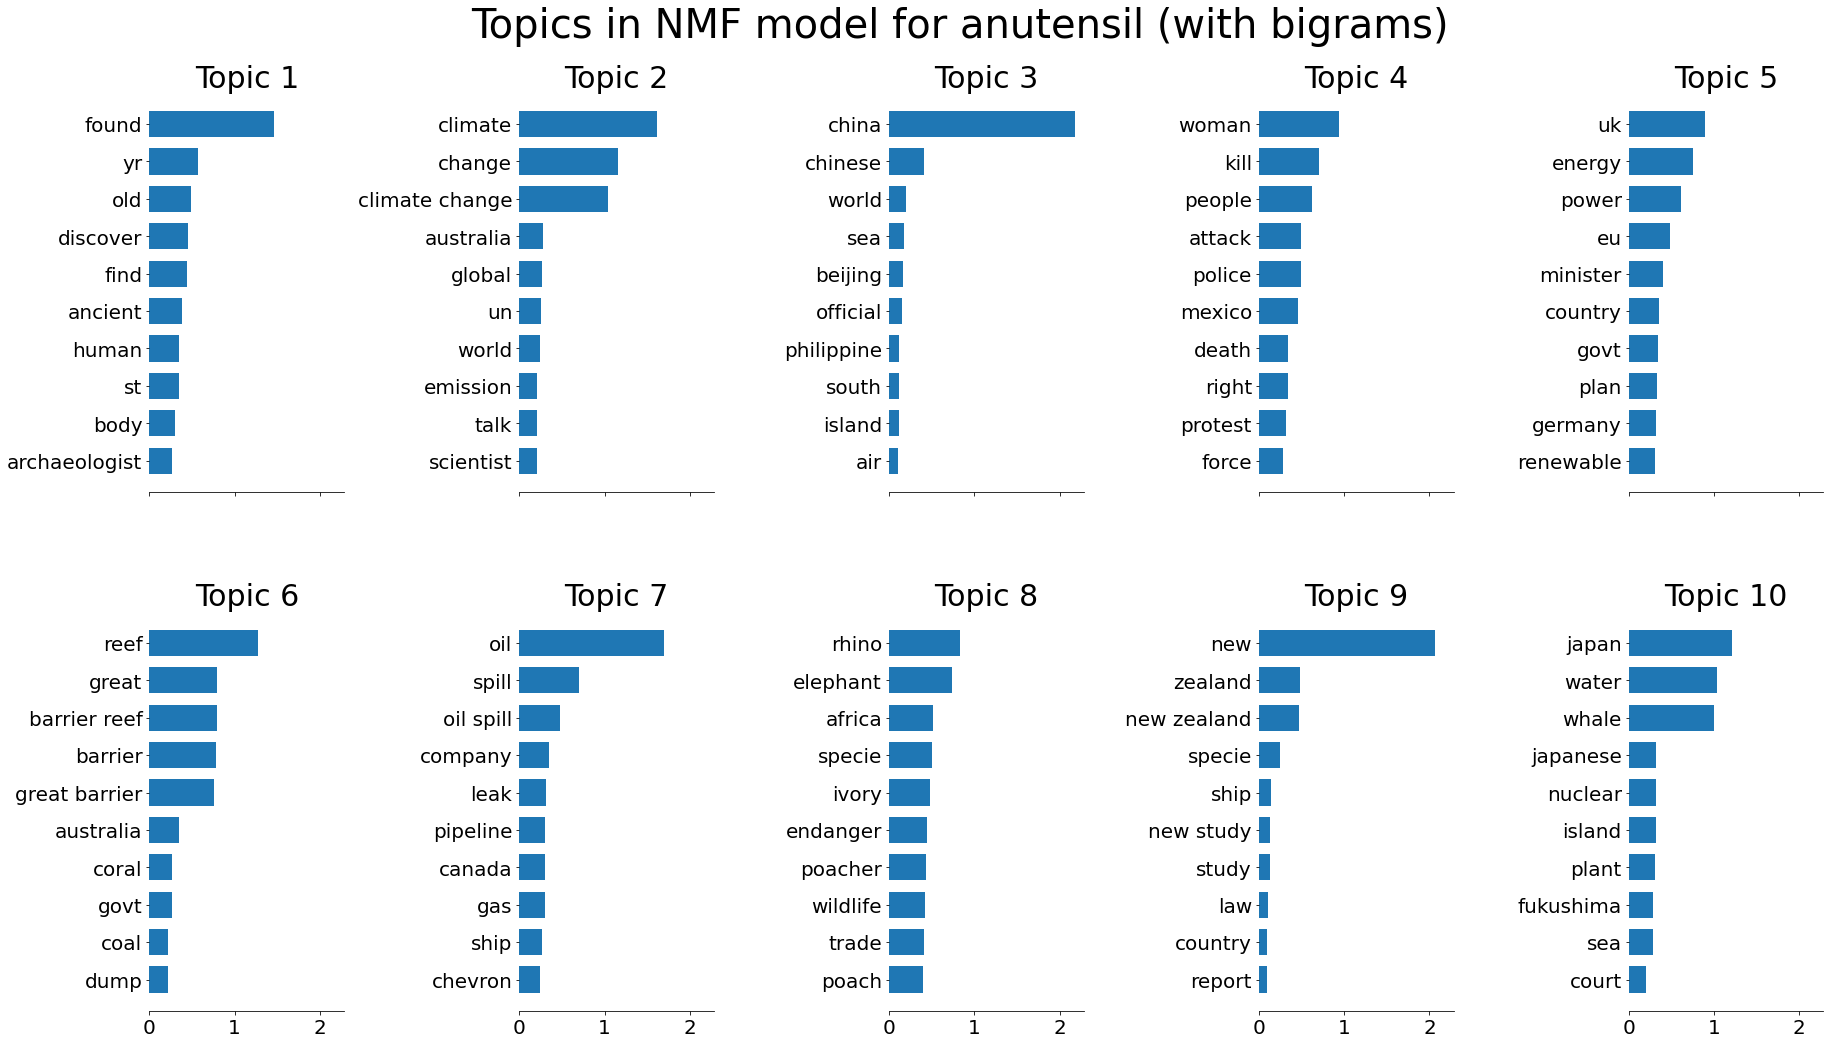

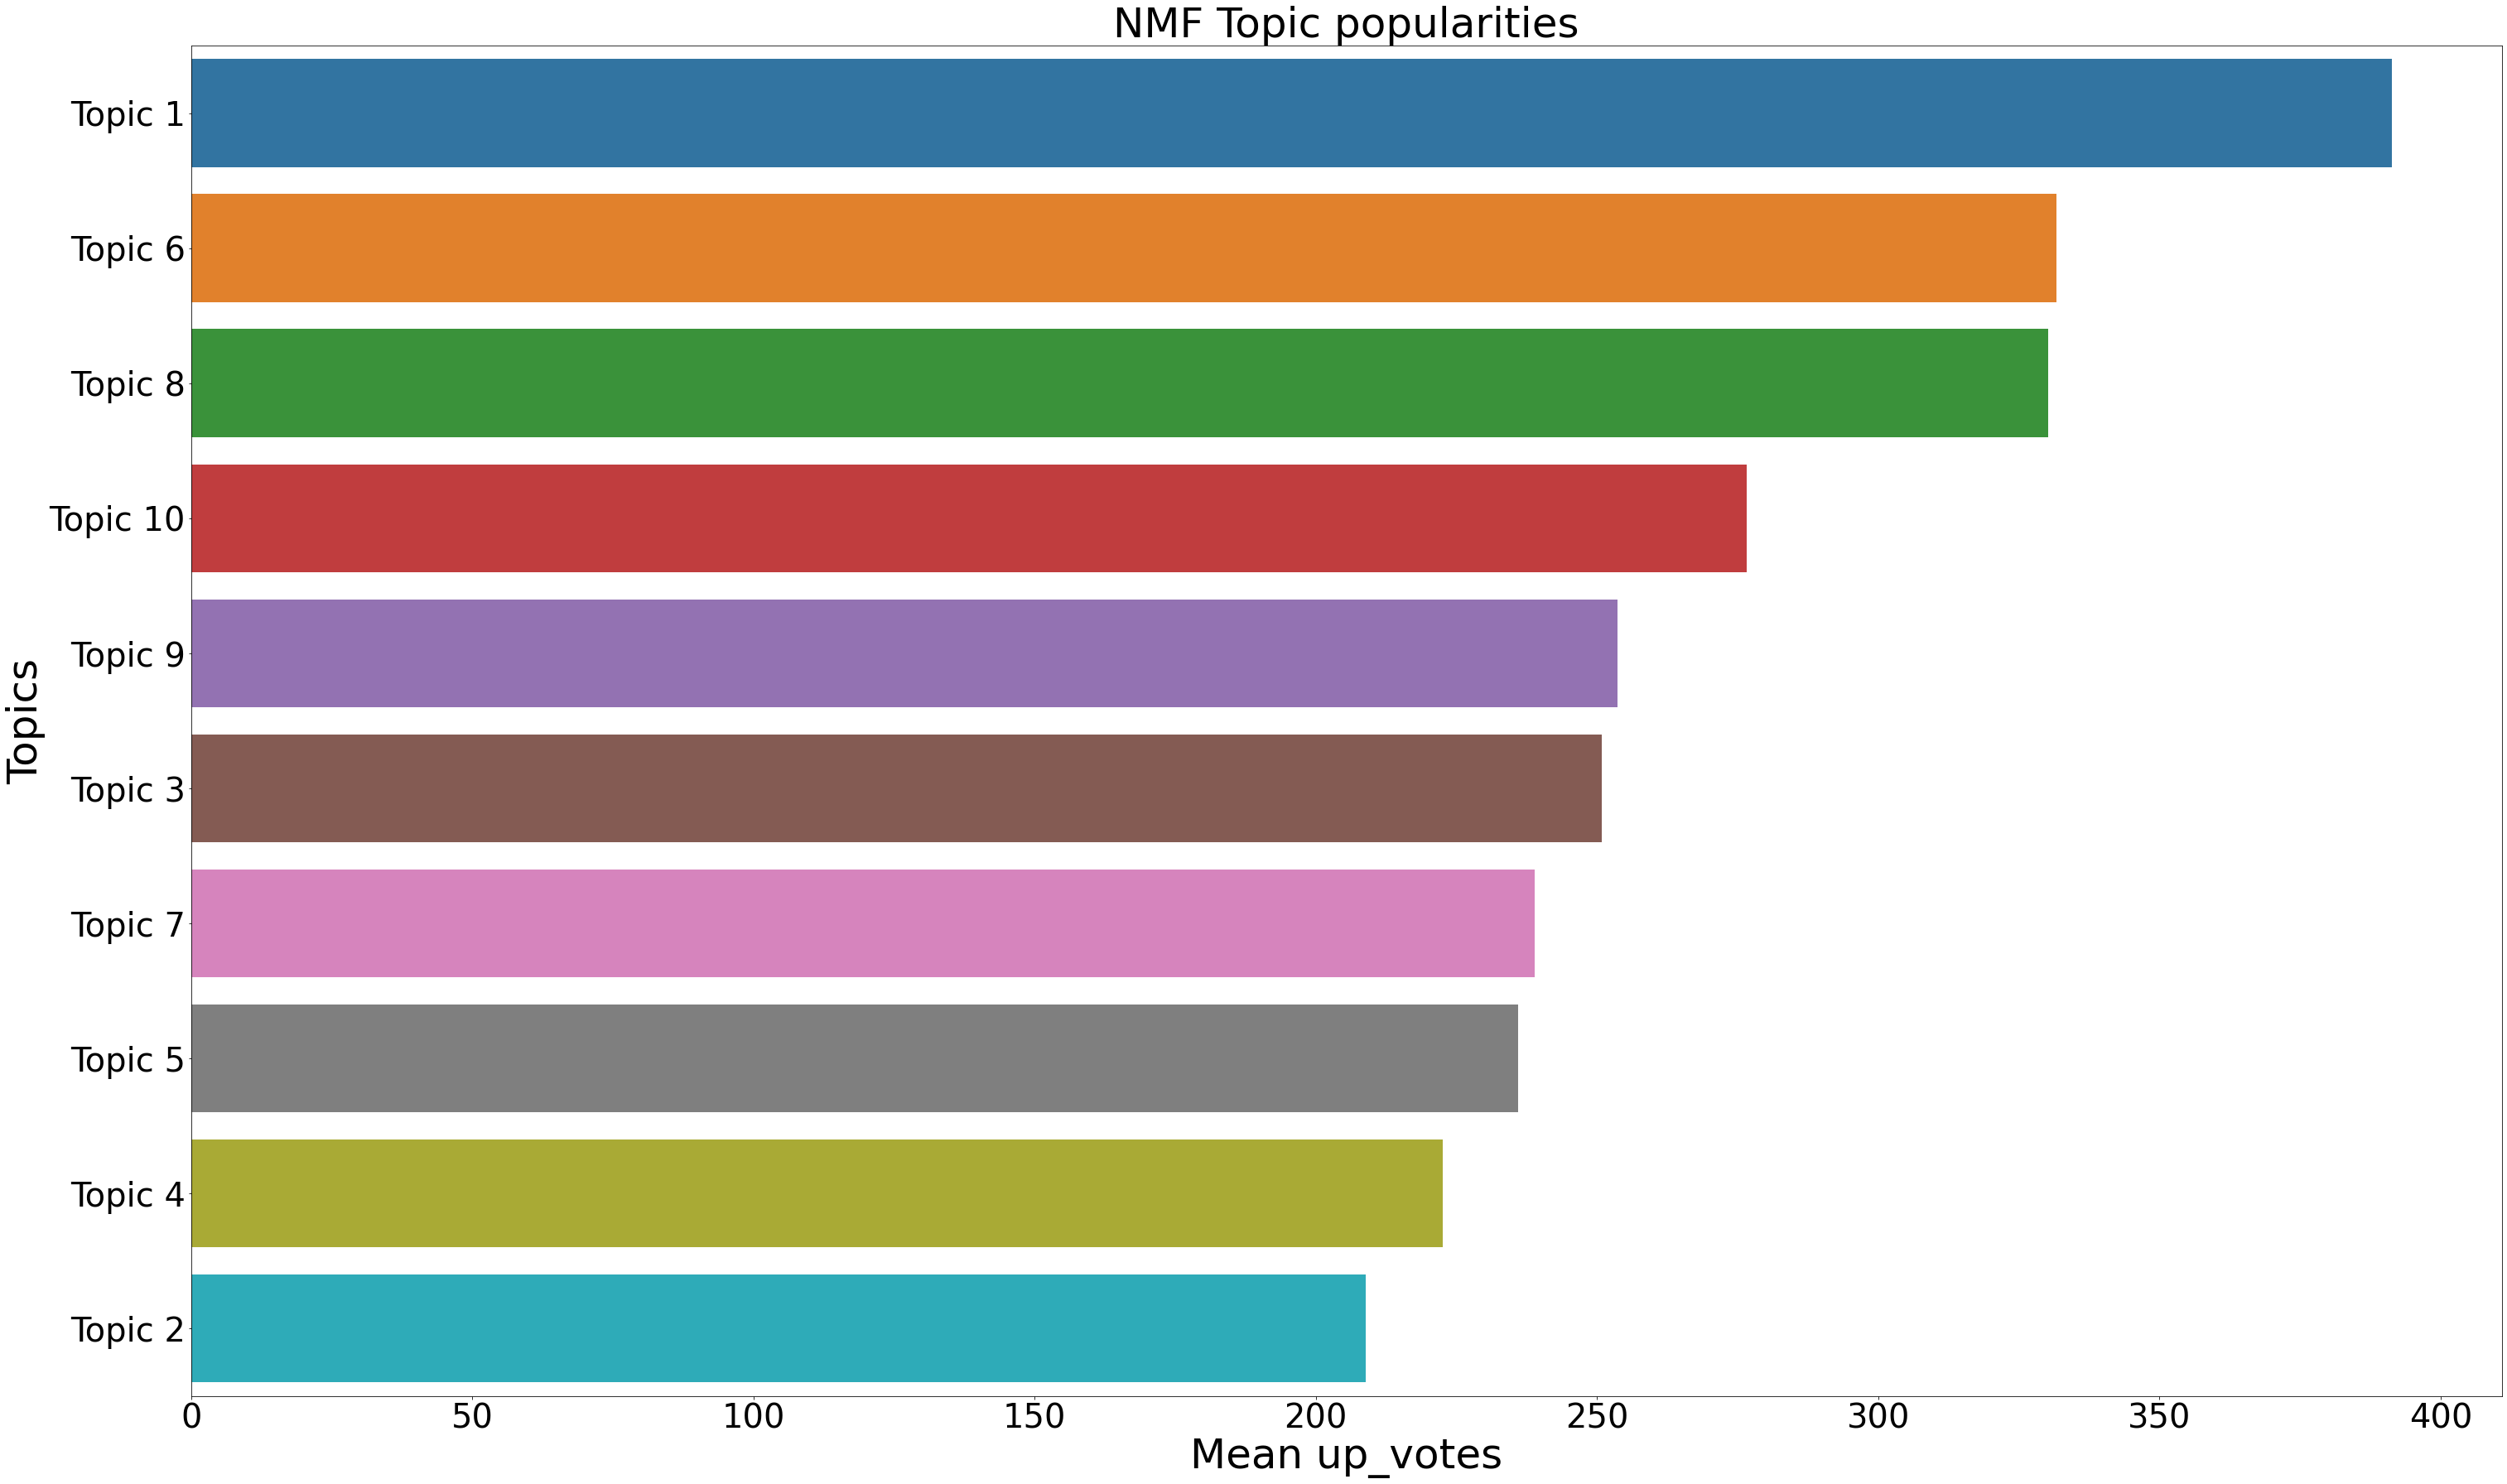

In [75]:
author = 'anutensil'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(1,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with bigrams)', author)

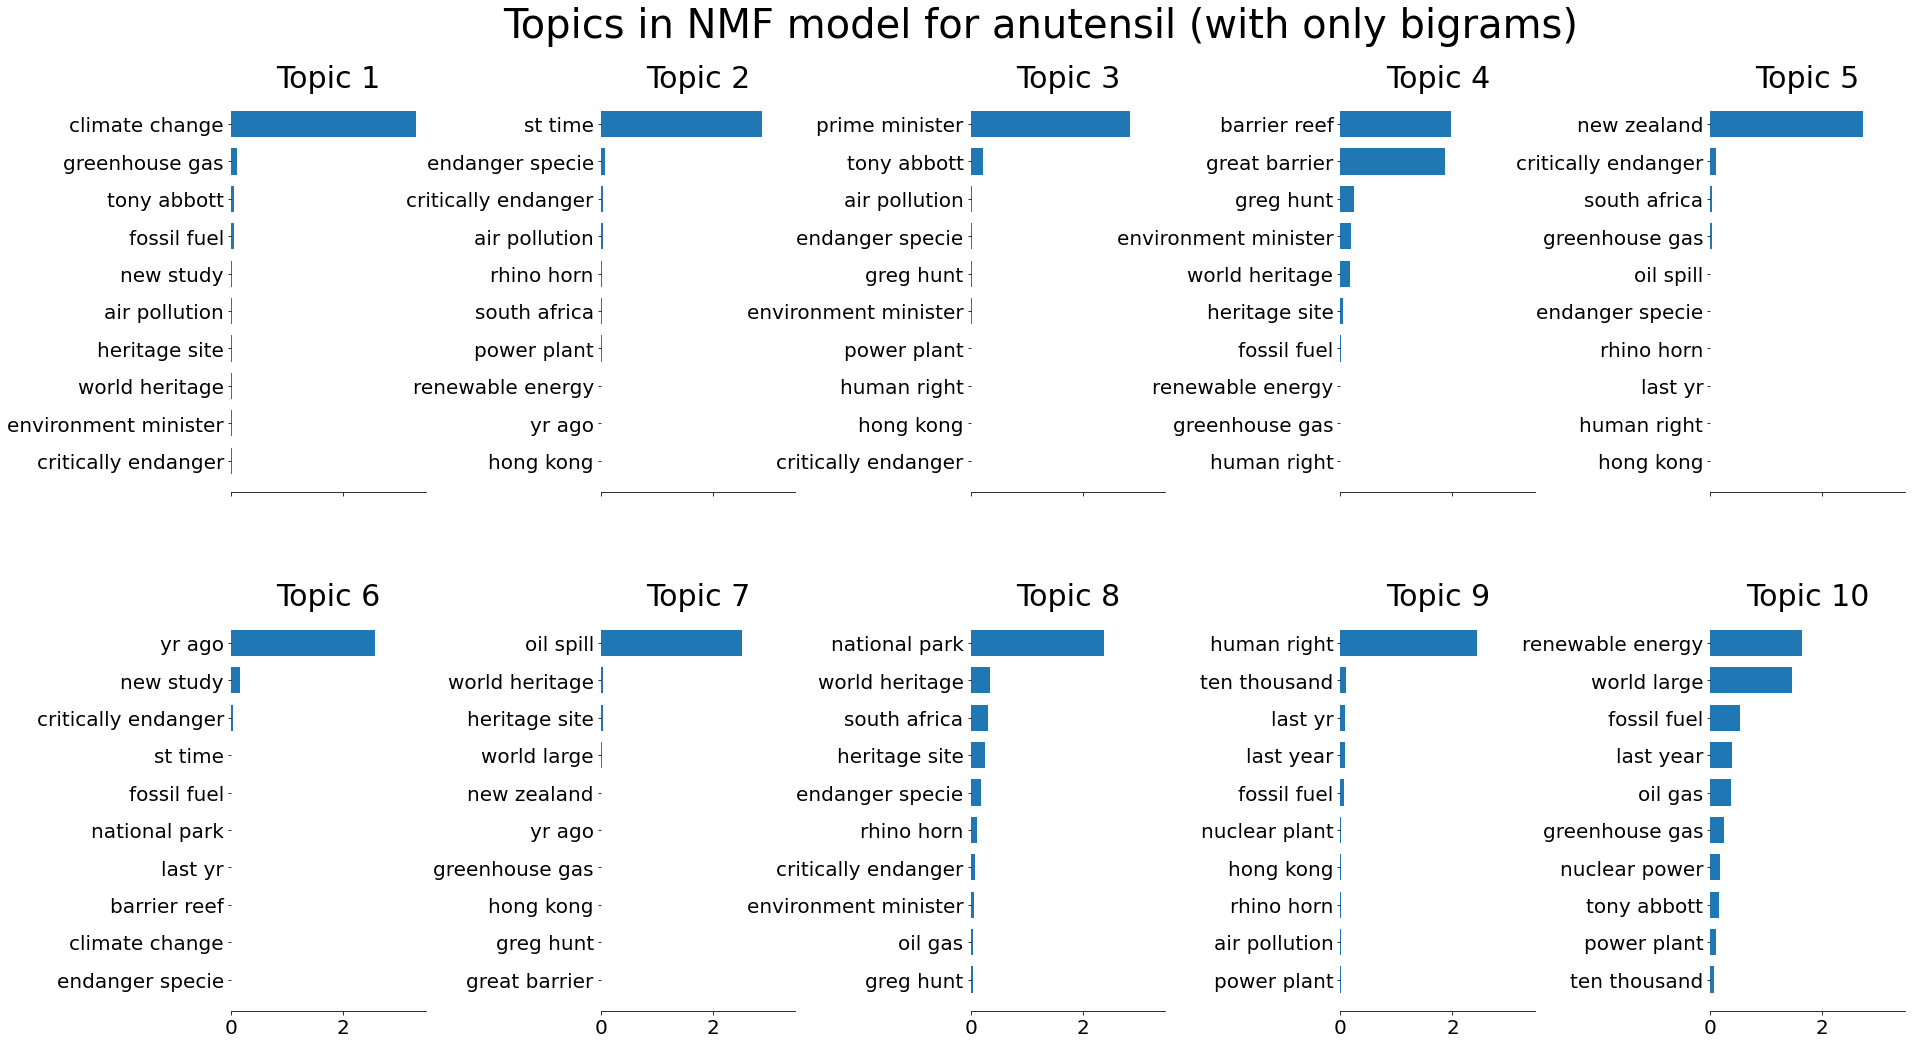

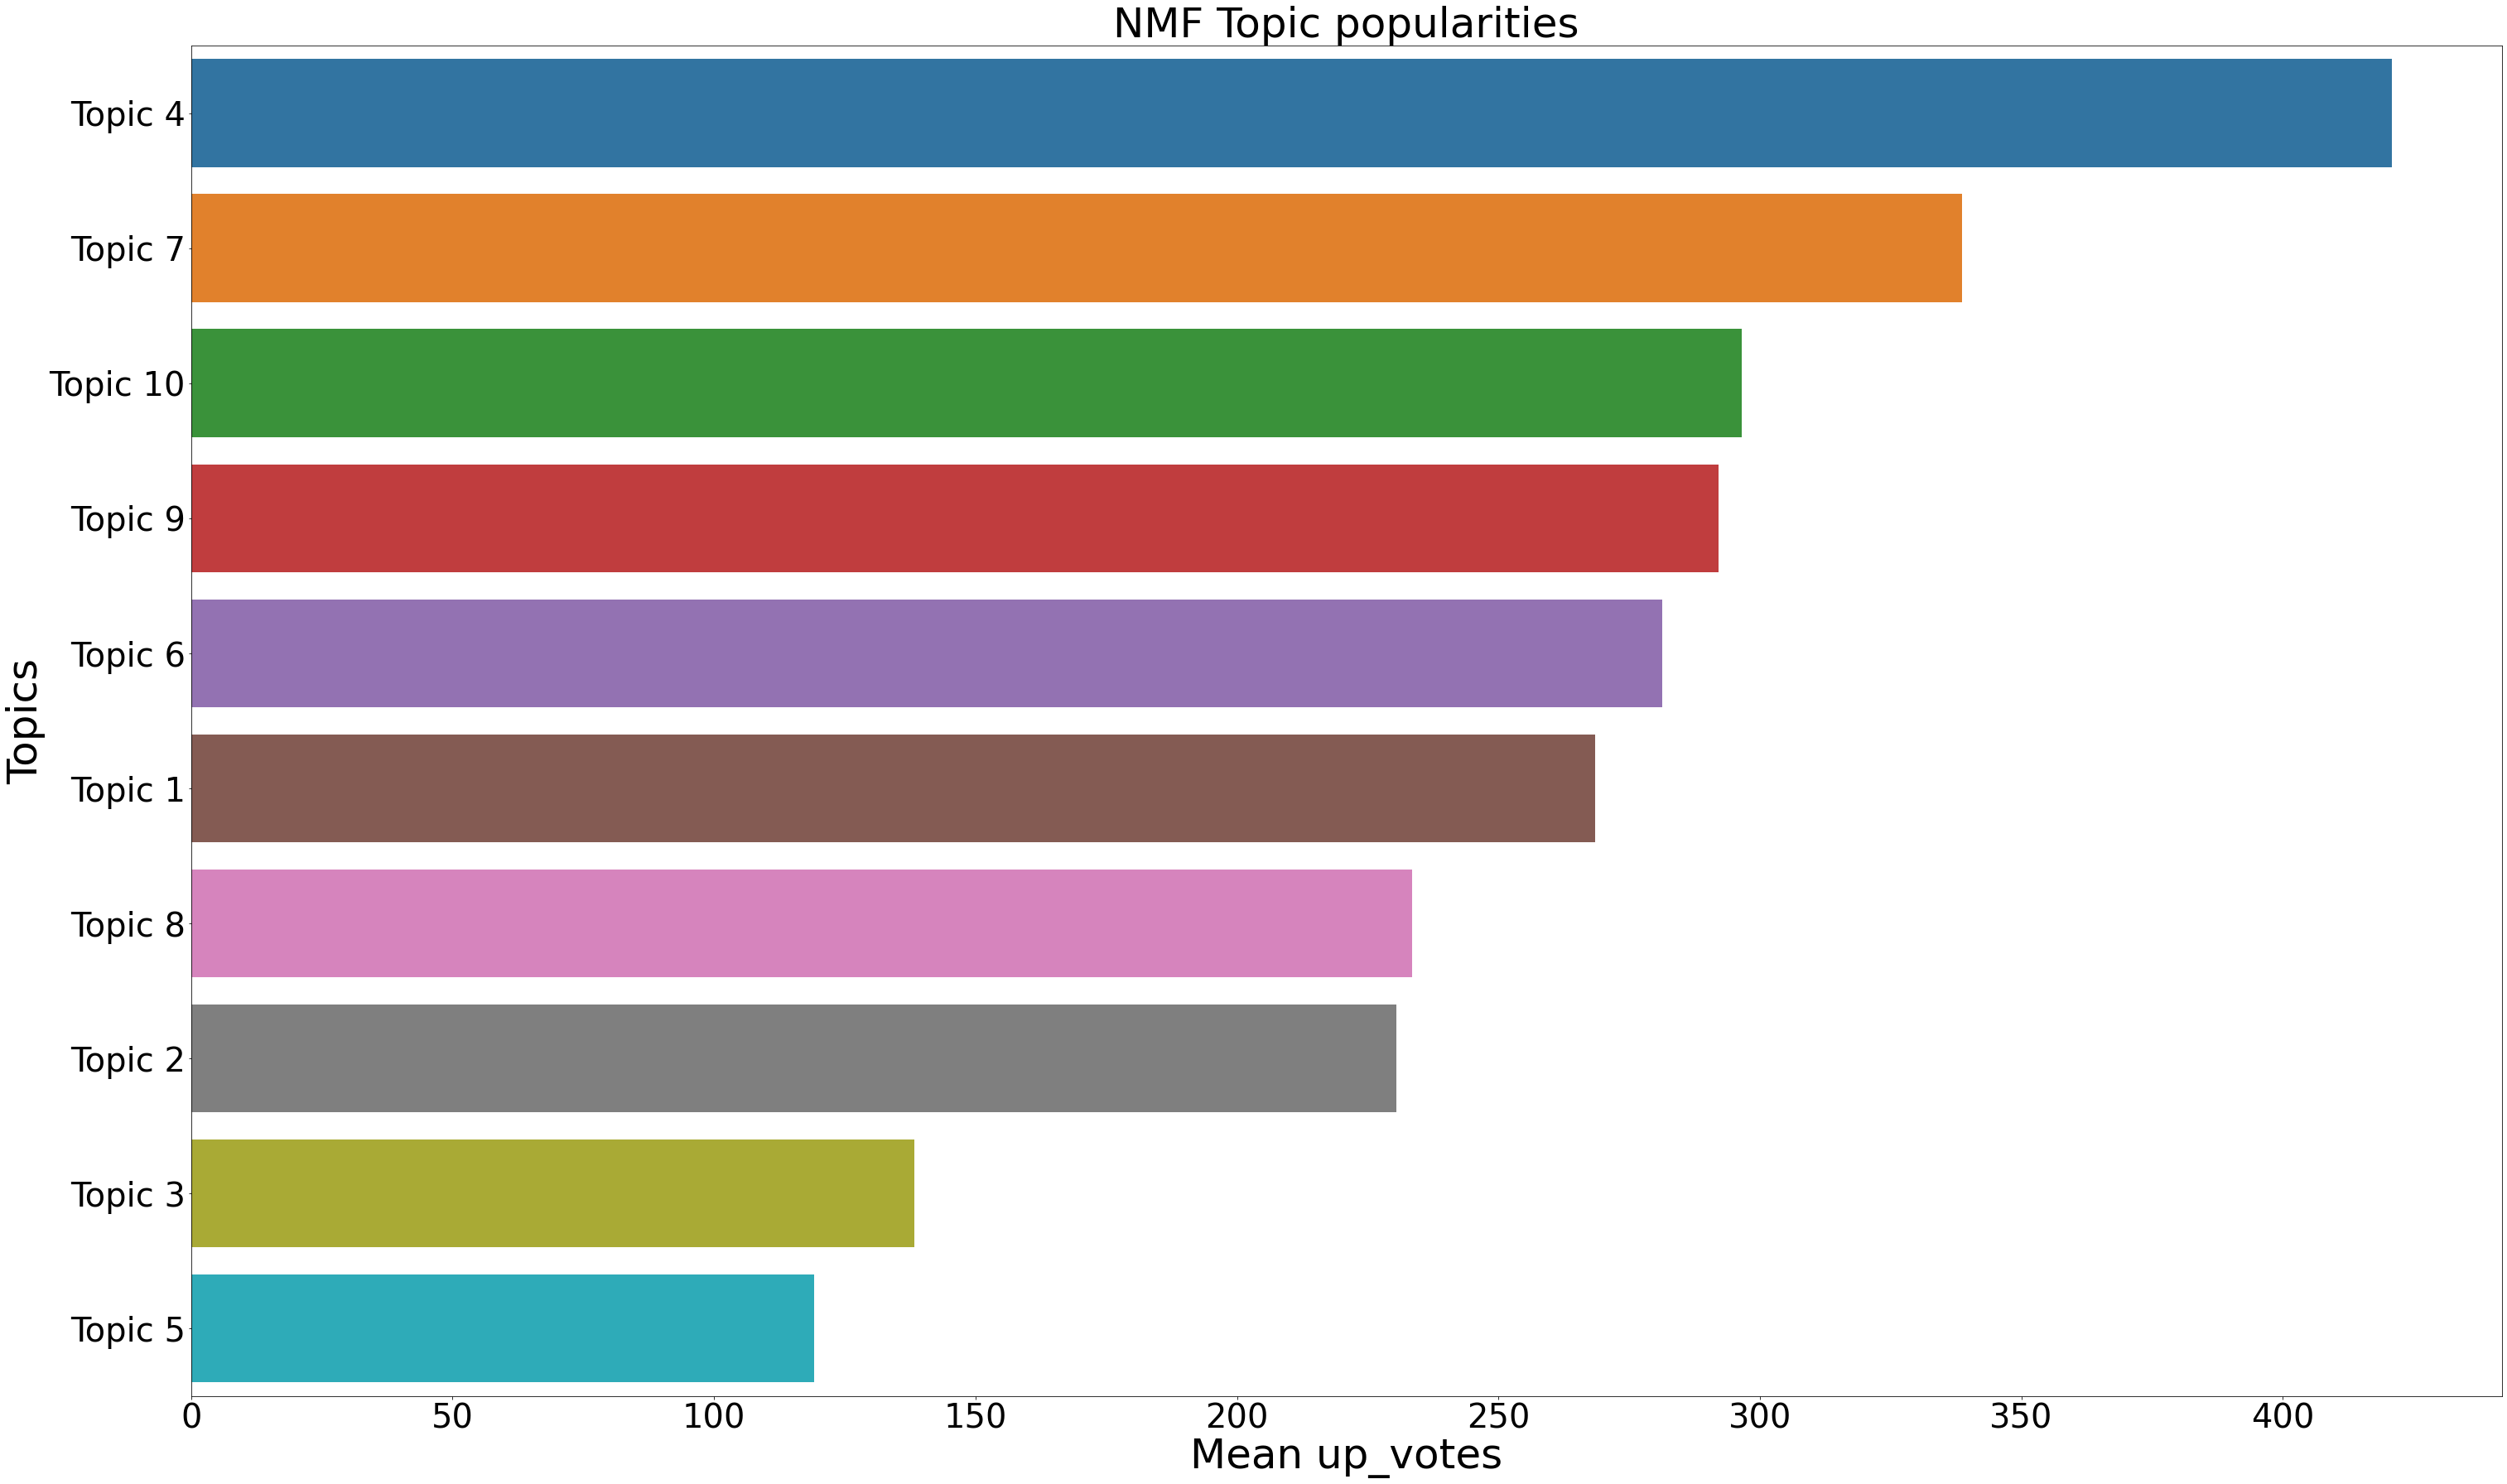

In [76]:
author = 'anutensil'

tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df =25, max_features=3000, ngram_range=(2,2))
tfidf = tfidf_vectorizer.fit_transform(df.loc[df['author']==author,'title_processed_joined'])

nmf = NMF(n_components=10, alpha=.1, init='nndsvd', max_iter=1000).fit(tfidf)

tfidf_feature_names = tfidf_vectorizer.get_feature_names()
plot_popular_topics_by_author(nmf, tfidf_feature_names, 10, f'Topics in NMF model for {author} (with only bigrams)', author)

### 'anutensil' mostly covers 'conservation' related topics like *climate change*, *renewables*, etc. 